# seg_lambda=0.3, alpha=0.5000
# use_eca=True, use_seg_guided=False

## 1. Paths & Training Hyperparameters

In [26]:
import os, sys, math, time, random, itertools
from typing import Tuple, List, Dict
import timm

IMG_ROOT = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images"
TRAIN_CSV = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv"
TEST_CSV  = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv"
MASK_ROOT = IMG_ROOT.replace("png_images", "png_masks")  

OUT_DIR   = "./Baseline+ECA(7000)_Output"

IMG_SIZE  = 576  
EPOCHS    = 120       
BATCH     = 4        
LR        = 2e-4
SEED      = 42
VAL_RATIO = 0.20       
SAMPLER   = "off"  
   
TTA_MODES = ("none", "hflip") 

print("IMG_ROOT:", IMG_ROOT)
print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV:", TEST_CSV)
print("OUT_DIR:", OUT_DIR)
print("EPOCHS/BATCH/LR:", EPOCHS, BATCH, LR)
print("VAL_RATIO/SAMPLER:", VAL_RATIO, SAMPLER)

IMG_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images
TRAIN_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv
TEST_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv
OUT_DIR: ./Baseline+ECA(7000)_Output
EPOCHS/BATCH/LR: 120 4 0.0002
VAL_RATIO/SAMPLER: 0.2 off


## 2. Imports & Device

In [27]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision.transforms import InterpolationMode
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"figure.dpi": 110})

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print(f"Using device: {device} | AMP: {'on' if device.type=='cuda' else 'off'}")

Using device: cuda | AMP: on


## 3. Read CSVs & Quick Preview

In [28]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

display(train_df.head(8))
display(test_df.head(8))

print("Train shape:", train_df.shape, "Columns:", list(train_df.columns))
print("Test  shape:", test_df.shape, "Columns:", list(test_df.columns))

print("Train label distribution:", train_df["has_pneumo"].value_counts().to_dict())
print("Test  label distribution:", test_df["has_pneumo"].value_counts().to_dict())

new_filename                                            ImageId  \
0  0_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...   
1  1_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...   
2  2_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   
3  3_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   
4  4_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.1314.151787516...   
5  5_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.11364.15178752...   
6  6_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.4541.151787518...   
7  7_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.4440.151787518...   

   has_pneumo  
0           0  
1           0  
2           1  
3           1  
4           1  
5           0  
6           0  
7           1

new_filename                                            ImageId  \
0  0_test_1_.png  1.2.276.0.7230010.3.1.4.8323329.5797.151787519...   
1  1_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5798.151787519...   
2  2_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5799.151787519...   
3  3_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.580.1517875163...   
4  4_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5800.151787519...   
5  5_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5801.151787519...   
6  6_test_1_.png  1.2.276.0.7230010.3.1.4.8323329.5802.151787519...   
7  7_test_1_.png  1.2.276.0.7230010.3.1.4.8323329.5803.151787519...   

   has_pneumo  
0           1  
1           0  
2           0  
3           0  
4           0  
5           0  
6           1  
7           1

Train shape: (10675, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Test  shape: (1372, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Train label distribution: {0: 8296, 1: 2379}
Test  label distribution: {0: 1082, 1: 290}


## 4. Full-path Resolution & Dataset 

In [29]:
IMG_MEAN = 0.4843
IMG_STD  = 0.2486

def resolve_full_paths(df: pd.DataFrame, img_root: str) -> pd.DataFrame:
    df = df.copy()
    def _resolve(row):
        name = str(row["new_filename"])
        name_png = name if name.lower().endswith(".png") else f"{name}.png"
        p1 = os.path.join(img_root, name_png)
        if os.path.exists(p1):
            return p1
        # fallback: ImageId.png
        alt = os.path.join(img_root, f"{row['ImageId']}.png")
        return alt if os.path.exists(alt) else p1
    df["full_path"] = df.apply(_resolve, axis=1)
    return df

train_df = resolve_full_paths(train_df, IMG_ROOT)
test_df  = resolve_full_paths(test_df,  IMG_ROOT)

missing_train = (~train_df["full_path"].apply(os.path.exists)).sum()
missing_test  = (~test_df["full_path"].apply(os.path.exists)).sum()
print(f"Missing files — Train: {missing_train} | Test: {missing_test}")

class PandasImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["full_path"]).convert("L")
        if self.transform: img = self.transform(img)
        y = int(row["has_pneumo"])
        return img, y
    
class JointImageMaskTransform:
    def __init__(self, out_size=IMG_SIZE):
        self.out_size = out_size

    def __call__(self, img, mask):
        # Resize + RandomResizedCrop + RandomHorizontalFlip + ToTensor + Normalize
        resize_to = int(self.out_size * 1.1)
        img  = TF.resize(img,  (resize_to, resize_to), interpolation=InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (resize_to, resize_to), interpolation=InterpolationMode.NEAREST)

        i, j, h, w = torchvision.transforms.RandomResizedCrop.get_params(
            img,
            scale=(0.8, 1.0),
            ratio=(0.9, 1.1)
        )
        img  = TF.resized_crop(img,  i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.BILINEAR)
        mask = TF.resized_crop(mask, i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.NEAREST)

        if random.random() < 0.5:
            img  = TF.hflip(img)
            mask = TF.hflip(mask)

        if random.random() < 0.5:
            angle = random.uniform(-7, 7)
            img  = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle, interpolation=InterpolationMode.NEAREST)

        if random.random() < 0.5:
            b_factor = 1.0 + random.uniform(-0.15, 0.15)
            c_factor = 1.0 + random.uniform(-0.15, 0.15)
            img = TF.adjust_brightness(img, b_factor)
            img = TF.adjust_contrast(img, c_factor)

        img  = TF.to_tensor(img)               # [1,H,W], [0,1]
        img  = TF.normalize(img, [IMG_MEAN], [IMG_STD])

        mask = TF.to_tensor(mask)              # [1,H,W], [0,1]
        mask = (mask > 0.5).float()            # Binarize

        return img, mask

class PandasImageMaskDataset(Dataset):
    def __init__(self, df: pd.DataFrame, mask_root: str, joint_transform: JointImageMaskTransform):
        self.df = df.reset_index(drop=True)
        self.mask_root = mask_root
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Images come from full_path
        img_path = row["full_path"]
        img = Image.open(img_path).convert("L")

        # Masks come from mask_root + basename
        basename = os.path.basename(img_path)
        mask_path = os.path.join(self.mask_root, basename)

        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask not found for {img_path} -> {mask_path}")

        mask = Image.open(mask_path).convert("L")

        img, mask = self.joint_transform(img, mask)

        y = float(row["has_pneumo"])
        return img, y, mask

Missing files — Train: 0 | Test: 0


## 5. Data visulization definition

### 5.1 Class distribution

In [30]:
os.makedirs(OUT_DIR, exist_ok=True)
EDA_DIR = os.path.join(OUT_DIR, "eda"); os.makedirs(EDA_DIR, exist_ok=True)

def eda_class_distribution(df: pd.DataFrame, label_col: str, out_path: str, title: str):
    counts = df[label_col].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    xs = [str(int(x)) for x in counts.index.tolist()]
    ys = counts.values.astype(int)
    plt.bar(xs, ys)
    for i, y in enumerate(ys):
        plt.text(i, y, str(y), ha="center", va="bottom", fontsize=9)
    plt.title(f"Class Distribution — {title}")
    plt.xlabel("Label"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(out_path); plt.show()

def eda_missing_files(df: pd.DataFrame, out_txt: str, title: str):
    missing_mask = ~df["full_path"].apply(os.path.exists)
    total = len(df); missing = missing_mask.sum()
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"Total rows: {total}\nMissing files: {missing}\n")
        if missing:
            f.write("First 50 missing examples:\n")
            f.write("\n".join(df.loc[missing_mask, "full_path"].head(50).tolist()))
    print(f"[{title}] Missing: {missing}/{total} — saved to {out_txt}")

def eda_sample_grid(df: pd.DataFrame, out_path: str, title: str, n_per_class: int = 8, size: int = 128):
    labels = sorted(df["has_pneumo"].unique().tolist())
    panels = []
    for lab in labels:
        subset = df[df["has_pneumo"] == lab]
        sample = subset.sample(min(n_per_class, len(subset)), random_state=0)
        panels.append(sample)

    cols = n_per_class; rows = len(labels)
    plt.figure(figsize=(cols*2, rows*2))
    idx = 1
    for r, panel in enumerate(panels):
        for _, row in panel.iterrows():
            fp = row["full_path"]
            plt.subplot(rows, cols, idx)
            try:
                img = Image.open(fp).convert("L").resize((size,size))
                plt.imshow(img, cmap="gray"); plt.axis("off")
            except Exception:
                plt.text(0.5,0.5,"missing",ha="center",va="center"); plt.axis("off")
            idx += 1
    plt.suptitle(f"Sample Grid — {title}", y=0.98)
    plt.tight_layout(); plt.savefig(out_path); plt.show()

### 5.2 Sample visulization

In [31]:
from pathlib import Path

def eda_sample_grid(df, out_path, split_name, n_per_class=6, size=128):
    label_col = "has_pneumo"
    path_col = "full_path" if "full_path" in df.columns else "filepath"

    classes = sorted(df[label_col].dropna().unique().tolist())
    nrows, ncols = len(classes), n_per_class
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.4))
    if nrows == 1:
        axes = np.array([axes])

    for r, c in enumerate(classes):
        sub = df[df[label_col] == c]
        sampled = sub.sample(n=min(n_per_class, len(sub)), random_state=42) if len(sub) > 0 else sub
        sampled = sampled.reset_index(drop=True)

        for i in range(ncols):
            ax = axes[r, i]
            ax.set_axis_off()

            if i < len(sampled):
                row = sampled.iloc[i]
                img_path = str(Path(row[path_col]))
                try:
                    im = Image.open(img_path).convert("L")
                    if size:
                        im = im.resize((size, size))
                    ax.imshow(im, cmap="gray")
                except Exception:
                    ax.imshow(np.zeros((size, size)), cmap="gray")

                ax.text(0.5, -0.08, str(row[label_col]),
                        transform=ax.transAxes, ha="center", va="top", fontsize=9)
            else:
                ax.imshow(np.zeros((size, size)), cmap="gray")

    plt.subplots_adjust(hspace=0.6, wspace=0.05)
    plt.show()
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    # fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

## 6. Data split (8:1:1)

In [32]:
# Combine train + test for splitting
full_df = pd.concat([train_df, test_df], ignore_index=True)

print("Original full size:", len(full_df))
print("Label distribution (full):", full_df["has_pneumo"].value_counts().to_dict())

# 20% of the data for val + test
from sklearn.model_selection import train_test_split

train_tmp, temp_df = train_test_split(
    full_df,
    test_size=0.2,
    stratify=full_df["has_pneumo"],
    random_state=SEED,
)

# 10% val, 10% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["has_pneumo"],
    random_state=SEED,
)

# raw train (before rebalancing)
tr_df = train_tmp

print("8:1:1 split sizes ->",
      "Train:", len(tr_df),
      "Val:",   len(val_df),
      "Test:",  len(test_df))

print("Train label dist (before rebalance):", tr_df["has_pneumo"].value_counts().to_dict())
print("Val   label dist:", val_df["has_pneumo"].value_counts().to_dict())
print("Test  label dist:", test_df["has_pneumo"].value_counts().to_dict())

# ------------------------------------------------------------------
# Class imbalance handling:
#   - oversample positive class (has_pneumo == 1) to 4000 samples
#   - downsample negative class (has_pneumo == 0) to 4000 samples
# ------------------------------------------------------------------
TARGET_POS = 3500
TARGET_NEG = 3500

pos_df = tr_df[tr_df["has_pneumo"] == 1]
neg_df = tr_df[tr_df["has_pneumo"] == 0]

n_pos = len(pos_df)
n_neg = len(neg_df)

print(f"Original Train counts -> pos: {n_pos}, neg: {n_neg}")

# 1) Positive class: oversample to TARGET_POS
if n_pos == 0:
    raise ValueError("No positive samples found in training set!")
elif n_pos >= TARGET_POS:
    pos_bal = pos_df.sample(TARGET_POS, replace=False, random_state=SEED)
else:
    factor_pos = TARGET_POS // n_pos
    rem_pos    = TARGET_POS % n_pos
    pos_bal = pd.concat(
        [pos_df] * factor_pos + [pos_df.sample(rem_pos, replace=True, random_state=SEED)],
        ignore_index=True,
    )

# 2) Negative class: downsample to TARGET_NEG
if n_neg == 0:
    raise ValueError("No negative samples found in training set!")
elif n_neg >= TARGET_NEG:
    neg_bal = neg_df.sample(TARGET_NEG, replace=False, random_state=SEED)
else:
    factor_neg = TARGET_NEG // n_neg
    rem_neg    = TARGET_NEG % n_neg
    neg_bal = pd.concat(
        [neg_df] * factor_neg + [neg_df.sample(rem_neg, replace=True, random_state=SEED)],
        ignore_index=True,
    )

# 3) Merge and shuffle
tr_df_bal = pd.concat([pos_bal, neg_bal], ignore_index=True)
tr_df_bal = tr_df_bal.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("After rebalancing Train label dist:",
      tr_df_bal["has_pneumo"].value_counts().to_dict())
print("Final Train size:", len(tr_df_bal))

# final training DataFrame to use downstream
tr_df = tr_df_bal

Original full size: 12047
Label distribution (full): {0: 9378, 1: 2669}
8:1:1 split sizes -> Train: 9637 Val: 1205 Test: 1205
Train label dist (before rebalance): {0: 7502, 1: 2135}
Val   label dist: {0: 938, 1: 267}
Test  label dist: {0: 938, 1: 267}
Original Train counts -> pos: 2135, neg: 7502
After rebalancing Train label dist: {0: 3500, 1: 3500}
Final Train size: 7000


## 7. Data augmentation

In [33]:
# Transforms
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[IMG_MEAN], std=[IMG_STD]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[IMG_MEAN], std=[IMG_STD]),
])

# Joint transforms for image + mask (training set)
joint_train_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

# Datasets
ds_train = PandasImageMaskDataset(tr_df, mask_root=MASK_ROOT, joint_transform=joint_train_tfms)
ds_val   = PandasImageDataset(val_df, transform=eval_tfms)
ds_test  = PandasImageDataset(test_df, transform=eval_tfms)

def make_weights_for_balancing(df: pd.DataFrame) -> np.ndarray:
    counts = df["has_pneumo"].value_counts().to_dict()
    return df["has_pneumo"].map(lambda y: 1.0 / counts[int(y)]).values.astype(np.float32)


if SAMPLER == "on":
    weights = make_weights_for_balancing(tr_df)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    shuffle = False
else:
    sampler = None; shuffle = True

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, shuffle=shuffle,
                      num_workers=0, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Use eval dataset for train_eval
ds_train_eval = PandasImageDataset(tr_df, transform=eval_tfms)
dl_train_eval = DataLoader(
    ds_train_eval, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True
)


len(ds_train), len(ds_val), len(ds_test)

(7000, 1205, 1205)

## 8. Comparison of before & after Standardizatin

In [34]:
# from torchvision import transforms
# from torch.utils.data import DataLoader

# raw_tf = transforms.ToTensor()

# ds_train_raw = PandasImageDataset(tr_df,  transform=raw_tf)
# ds_val_raw   = PandasImageDataset(val_df, transform=raw_tf)
# ds_test_raw  = PandasImageDataset(test_df, transform=raw_tf)

# dl_train_raw = DataLoader(ds_train_raw, batch_size=BATCH, shuffle=False,
#                           num_workers=0, pin_memory=True)
# dl_val_raw   = DataLoader(ds_val_raw,   batch_size=BATCH, shuffle=False,
#                           num_workers=0, pin_memory=True)
# dl_test_raw  = DataLoader(ds_test_raw,  batch_size=BATCH, shuffle=False,
#                           num_workers=0, pin_memory=True)


### 8.1 Calculate mean & std from dataloader

In [35]:
# import torch

# def compute_mean_std_from_loader(dataloader, max_batches=None, name=""):
#     sum_ = 0.0
#     sum_sq = 0.0
#     n_pixels = 0

#     for i, batch in enumerate(dataloader):
#         if isinstance(batch, (list, tuple)):
#             imgs = batch[0]
#         else:
#             imgs = batch
        
#         imgs = imgs.float()
#         b, c, h, w = imgs.shape
#         imgs = imgs.view(b, c, -1)   # [B, C, H*W]

#         sum_    += imgs.sum(dim=[0, 2])          # [C]
#         sum_sq  += (imgs ** 2).sum(dim=[0, 2])   # [C]
#         n_pixels += b * h * w

#         if (max_batches is not None) and (i + 1 >= max_batches):
#             break

#     mean = sum_ / n_pixels
#     std  = torch.sqrt(sum_sq / n_pixels - mean ** 2)

#     print(f"{name} mean:", mean)
#     print(f"{name} std :", std)
#     print("-" * 60)
#     return mean, std

### 8.2 Standardization checking

In [36]:
# print("========== BEFORE standardization (0-1, ToTensor only) ==========")
# train_raw_mean, train_raw_std = compute_mean_std_from_loader(dl_train_raw, name="Train raw")
# val_raw_mean,   val_raw_std   = compute_mean_std_from_loader(dl_val_raw,   name="Val raw")
# test_raw_mean,  test_raw_std  = compute_mean_std_from_loader(dl_test_raw,  name="Test raw")

# print("\n========== AFTER standardization (using current pipeline) ==========")
# train_std_mean, train_std_std = compute_mean_std_from_loader(dl_train, name="Train standardized")
# val_std_mean,   val_std_std   = compute_mean_std_from_loader(dl_val,   name="Val standardized")
# test_std_mean,  test_std_std  = compute_mean_std_from_loader(dl_test,  name="Test standardized")


### 8.3 Data visualization after standardization

In [37]:
# import numpy as np
# import matplotlib.pyplot as plt

# def collect_pixels(dataloader, max_batches=200):
#     all_pixels = []

#     for i, batch in enumerate(dataloader):
#         if isinstance(batch, (list, tuple)):
#             imgs = batch[0]
#         else:
#             imgs = batch

#         imgs = imgs.float().cpu()
#         all_pixels.append(imgs.view(-1).numpy())

#         if (max_batches is not None) and (i + 1 >= max_batches):
#             break

#     if len(all_pixels) == 0:
#         return np.array([])
#     return np.concatenate(all_pixels, axis=0)
# train_pixels_raw  = collect_pixels(dl_train_raw, max_batches=200) 
# train_pixels_std  = collect_pixels(dl_train,      max_batches=200) 

# print("Train pixels (raw)  shape:", train_pixels_raw.shape)
# print("Train pixels (std)  shape:", train_pixels_std.shape)

# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.title("Train — Before standardization (0-1)")
# plt.hist(train_pixels_raw, bins=50)
# plt.xlabel("Pixel value (0-1)")
# plt.ylabel("Count")

# plt.subplot(1, 2, 2)
# plt.title("Train — After standardization")
# plt.hist(train_pixels_std, bins=50)
# plt.xlabel("Pixel value (standardized)")
# plt.ylabel("Count")

# plt.tight_layout()
# plt.show()


In [38]:
import os
import numpy as np
from PIL import Image

first_pos_idx = 1  

row = tr_df.iloc[first_pos_idx]
img_path = row["full_path"]
basename = os.path.basename(img_path)

print("img_path:", img_path)
print("basename:", basename)

print("MASK_ROOT:", MASK_ROOT)
mask_path = os.path.join(MASK_ROOT, basename)
print("mask_path:", mask_path, "exists:", os.path.exists(mask_path))

mask_raw = Image.open(mask_path).convert("L")
mask_np = np.array(mask_raw)

print("raw mask shape:", mask_np.shape)
print("raw mask min/max:", mask_np.min(), mask_np.max())
print("raw mask positive pixels (>0):", (mask_np > 0).sum())


img_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images\1926_train_1_.png
basename: 1926_train_1_.png
MASK_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks
mask_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks\1926_train_1_.png exists: True
raw mask shape: (1024, 1024)
raw mask min/max: 0 255
raw mask positive pixels (>0): 18335


In [39]:
pos_indices = [i for i, v in enumerate(tr_df["has_pneumo"].values) if v == 1]
print("Positive sample number:", len(pos_indices))
first_pos_idx = pos_indices[0]

img, y, mask = ds_train[first_pos_idx]
print("index:", first_pos_idx)
print("label:", y)
print("mask shape:", mask.shape)
print("mask min/max:", mask.min().item(), mask.max().item())
print("mask positive pixels:", mask.sum().item())

Positive sample number: 3500
index: 1
label: 1.0
mask shape: torch.Size([1, 576, 576])
mask min/max: 0.0 1.0
mask positive pixels: 6665.0


## 9. ConvNeXt_V2

### 9.1 DropPath (Random Depth)

In [40]:
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1.0 - drop_prob
    # Only sample along batch dimension, broadcast others
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    return x * random_tensor / keep_prob

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

### 9.2 GRN

In [41]:
class GRN(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)                # [N,1,1,C]
        nx = gx / (gx.mean(dim=-1, keepdim=True) + 1e-6)                 # [N,1,1,C]
        return self.gamma * (x * nx) + self.beta + x                     # [N,H,W,C]

### 9.3 LayerNorm2d

In [42]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = (x - mean).pow(2).mean(dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1) * x + self.bias.view(1, -1, 1, 1)

### 9.4 ECA

In [43]:
class ECALayer(nn.Module):
    def __init__(self, channels: int, k_size: int = 3):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(
            in_channels=1,
            out_channels=1,
            kernel_size=k_size,
            padding=(k_size - 1) // 2,
            bias=False,
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [B, C, H, W]
        y = self.avg_pool(x)                    # [B, C, 1, 1]
        y = y.squeeze(-1).transpose(-1, -2)     # [B, 1, C]
        y = self.conv(y)                        # [B, 1, C]
        y = self.sigmoid(y)
        y = y.transpose(-1, -2).unsqueeze(-1)   # [B, C, 1, 1]
        return x * y


### 9.5 ConvNeXt_V2 block

In [44]:
class ConvNeXtV2Block(nn.Module):
    def __init__(
        self,
        dim: int,
        mlp_ratio: float = 4.0,
        drop_path: float = 0.0,
        layer_scale_init_value: float = 0.0,  
    ):
        super().__init__()
        # 7x7 depthwise convolution
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

        # Do LayerNorm in channels_last format
        self.norm = nn.LayerNorm(dim, eps=1e-6)

        hidden_dim = int(dim * mlp_ratio)
        self.pwconv1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.grn = GRN(hidden_dim)
        self.pwconv2 = nn.Linear(hidden_dim, dim)

        # LayerScale
        if layer_scale_init_value > 0:
            self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim))
        else:
            self.gamma = None

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        shortcut = x  # [N, C, H, W]

        x = self.dwconv(x)

        # NCHW -> NHWC
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = self.gamma.view(1, 1, 1, -1) * x

        # NHWC -> NCHW
        x = x.permute(0, 3, 1, 2)

        x = shortcut + self.drop_path(x)
        return x

## 10. U-Net Decoder Block

In [45]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int):
        super().__init__()
        self.has_skip = skip_ch > 0

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv1 = nn.Conv2d(in_ch + (skip_ch if skip_ch > 0 else 0),
                               out_ch, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.act   = nn.ReLU(inplace=True)

    def forward(self, x, skip=None):
        # Oversample
        x = self.upsample(x)

        if self.has_skip and skip is not None:
            if skip.shape[-2:] != x.shape[-2:]:
                skip = F.interpolate(skip, size=x.shape[-2:], mode="bilinear", align_corners=False)
            x = torch.cat([x, skip], dim=1)

        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        return x


## 11. ConvNeXt_V2 tiny

In [46]:
class ConvNeXtV2Tiny(nn.Module):
    def __init__(
        self,
        in_chans: int = 3,
        num_classes: int = 1000,
        drop_path_rate: float = 0.0,
        layer_scale_init_value: float = 0.0, 
    ):
        super().__init__()

        # 4 deepths and dims for each stage
        depths = [3, 3, 9, 3]
        dims = [96, 192, 384, 768]

        self.downsample_layers = nn.ModuleList()
        self.stages = nn.ModuleList()

        # Constructing the stem: patch embedding with stride=4
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0]),
        )
        self.downsample_layers.append(stem)

        # Constructing the blocks and downsampling layers for each stage
        total_blocks = sum(depths)
        dpr_values = torch.linspace(0, drop_path_rate, total_blocks).tolist()
        block_idx = 0

        for stage_idx in range(4):
            depth = depths[stage_idx]
            dim = dims[stage_idx]

            # Every stage begins with a downsampling layer (except the first)
            if stage_idx > 0:
                down = nn.Sequential(
                    LayerNorm2d(dims[stage_idx - 1]),
                    nn.Conv2d(dims[stage_idx - 1], dim, kernel_size=2, stride=2),
                )
                self.downsample_layers.append(down)

            blocks = []
            for i in range(depth):
                blocks.append(
                    ConvNeXtV2Block(
                        dim=dim,
                        mlp_ratio=4.0,
                        drop_path=dpr_values[block_idx + i],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                )
            block_idx += depth

            self.stages.append(nn.Sequential(*blocks))

        # The last classification head: LN + Linear
        self.norm_head = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = (
            nn.Linear(dims[-1], num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        # Downsampling through stages
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        # Global average pooling and normalization
        x = x.mean(dim=[2, 3])
        x = self.norm_head(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # [N, num_classes]
        return x
    
class ConvNeXtV2TinyScratch(nn.Module):
    def __init__(
        self,
        in_chans: int = 1,
        n_classes: int = 1,
        drop_path_rate: float = 0.1,
        use_seg_guided: bool = True,  
    ):
        super().__init__()

        self.backbone = ConvNeXtV2Tiny(
            in_chans=in_chans,
            num_classes=n_classes,
            drop_path_rate=drop_path_rate,
            layer_scale_init_value=0.0,
        )

        # Channel dims at each stage of ConvNeXtV2Tiny
        dims = [96, 192, 384, 768]
        last_dim = dims[-1]   # The deepest 768

        # ===== ECA on deepest feature map =====
        self.eca4 = ECALayer(last_dim, k_size=3)

        # ===== Segmentation guidance =====
        self.use_seg_guided  = use_seg_guided   # ★ 改成用入参
        self.seg_guided_scale = 0.5             

        # ===== Classification head =====
        self.cls_head = nn.Linear(last_dim, n_classes)

        # ===== U-Net decoder =====
        # encoder output: x1(1/4, 96), x2(1/8, 192), x3(1/16,384), x4(1/32,768)
        self.dec3 = DecoderBlock(in_ch=dims[3], skip_ch=dims[2], out_ch=dims[2])   # 1/32 -> 1/16
        self.dec2 = DecoderBlock(in_ch=dims[2], skip_ch=dims[1], out_ch=dims[1])   # 1/16 -> 1/8
        self.dec1 = DecoderBlock(in_ch=dims[1], skip_ch=dims[0], out_ch=dims[0])   # 1/8  -> 1/4
        self.dec0 = DecoderBlock(in_ch=dims[0], skip_ch=0,        out_ch=max(dims[0] // 2, 32))  # 1/4 -> 1/2

        # Segmentation head：convalution to 1 channel
        self.seg_head = nn.Conv2d(max(dims[0] // 2, 32), 1, kernel_size=1)



    def forward_backbone_pyramid(self, x):
        """
        Return feature pyramid from backbone
        x1: 1/4,  x2: 1/8,  x3: 1/16, x4: 1/32
        """
        feats = []
        for i in range(4):
            x = self.backbone.downsample_layers[i](x)
            x = self.backbone.stages[i](x)

            if i == 3:
                x = self.eca4(x)    # x4: [B, 768, H/32, W/32]

            feats.append(x)
        return feats  # [x1, x2, x3, x4]


    def forward(self, x):
        # ---- Encoder ----
        x1, x2, x3, x4 = self.forward_backbone_pyramid(x)

        # ---- U-Net Decoder + Segmentation head ----
        d3 = self.dec3(x4, x3)    # 1/32 -> 1/16
        d2 = self.dec2(d3, x2)    # 1/16 -> 1/8
        d1 = self.dec1(d2, x1)    # 1/8  -> 1/4
        d0 = self.dec0(d1, None)  # 1/4  -> 1/2

        seg_logits = self.seg_head(d0)  # [B,1,H_dec,W_dec]

        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        # ---- Segmentation-guided Classification ----
        x4_for_cls = x4 

        if self.use_seg_guided:
            seg_prob = torch.sigmoid(seg_logits)

            seg_down = F.adaptive_avg_pool2d(seg_prob, output_size=x4.shape[-2:])

            x4_for_cls = x4 * (1.0 + self.seg_guided_scale * seg_down)

        # ---- Classification branch ----
        gap = x4_for_cls.mean(dim=[2, 3])          # [B, C4]
        gap = self.backbone.norm_head(gap)
        cls_logits = self.cls_head(gap)           # [B, 1]
        cls_logits = cls_logits.squeeze(1)        # [B]

        return cls_logits, seg_logits


model = ConvNeXtV2TinyScratch(
    in_chans=1,
    n_classes=1,
    drop_path_rate=0.1,
    use_seg_guided=False, 
).to(device)


## 12. Model loading

In [47]:
# import torch
# import os

# model = ConvNeXtV2TinyScratch(
#     in_chans=1,
#     n_classes=1,
#     drop_path_rate=0.1,
#     use_seg_guided=False, 
# ).to(device)

# ckpt_path = os.path.join("./Baseline+ECA(7000)_Output", "best_cnn.pt")
# print("Loading checkpoint from:", ckpt_path)

# state = torch.load(ckpt_path, map_location=device)

# missing, unexpected = model.load_state_dict(state, strict=False)
# print("Missing keys:", missing)
# print("Unexpected keys:", unexpected)

# model.eval()


## 13. Parameter counts

In [48]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params:      {total:,}")
    print(f"Trainable params:  {trainable:,}")
    print(f"Total params (M):  {total / 1e6:.2f} M")
    print(f"Trainable (M):     {trainable / 1e6:.2f} M")

count_parameters(model)


Total params:      34,898,838
Trainable params:  34,898,838
Total params (M):  34.90 M
Trainable (M):     34.90 M


## 14. Loss：Tversky + Focal

### 14.1 Tversky Loss

In [49]:
# Weights initialization
LAMBDA_SEG = 0.3

class TverskyLoss(nn.Module):
    def __init__(self, alpha: float = 0.3, beta: float = 0.7,
                 smooth: float = 1e-6, pos_only: bool = True):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
        self.pos_only = pos_only

    def forward(self, logits, targets):
        """
        logits: [B,1,H,W]
        targets: [B,1,H,W] (0/1)
        """
        probs = torch.sigmoid(logits)
        targets = targets.float()

        B = probs.size(0)
        probs_flat   = probs.view(B, -1)
        targets_flat = targets.view(B, -1)

        # Only calculate positive sample using Tversky
        if self.pos_only:
            pos_mask = (targets_flat.sum(dim=1) > 0)
            if pos_mask.any():
                probs_flat   = probs_flat[pos_mask]
                targets_flat = targets_flat[pos_mask]
            else:
                return logits.new_tensor(0.0)

        TP = (probs_flat * targets_flat).sum(dim=1)
        FP = (probs_flat * (1.0 - targets_flat)).sum(dim=1)
        FN = ((1.0 - probs_flat) * targets_flat).sum(dim=1)

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        loss = 1.0 - tversky
        return loss.mean()

### 14.2 Focal Loss

In [50]:
# Calculate class weights for Focal Loss
pos = (np.array(tr_df["has_pneumo"]) == 1).sum()
neg = (np.array(tr_df["has_pneumo"]) == 0).sum()

alpha = neg / (pos + neg + 1e-8)  

print(f"Train pos={pos}, neg={neg}, alpha={alpha:.4f}")

# Define Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        if logits.dim() > targets.dim():
            targets = targets.view_as(logits)
        targets = targets.float()

        # Probabilities for the true class
        prob = torch.sigmoid(logits)
        pt = prob * targets + (1 - prob) * (1 - targets)  

        # Weighted alpha factor
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Focal weight
        focal_weight = alpha_t * (1 - pt).pow(self.gamma)

        # Basic BCE with logits
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none"
        )
        loss = focal_weight * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Create criterion, optimizer, scheduler, scaler
criterion_cls  = BinaryFocalLoss(alpha=alpha, gamma=2.0)   # clf
criterion_segF = BinaryFocalLoss(alpha=0.5,   gamma=2.0)   # seg
criterion_segT = TverskyLoss(alpha=0.3, beta=0.7, pos_only=True)

# Optimizer / Scheduler / AMP
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Train pos=3500, neg=3500, alpha=0.5000


C:\Users\Steven\AppData\Local\Temp\ipykernel_3920\3234299231.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


## 15. Model eval function

### 15.1 TTA

In [51]:
import torch

def apply_tta_to_images(xb: torch.Tensor, mode: str) -> torch.Tensor:
    if mode == "none":
        return xb
    elif mode == "hflip":
        return torch.flip(xb, dims=[3])
    elif mode == "vflip":
        return torch.flip(xb, dims=[2])
    elif mode == "rot90":
        return torch.rot90(xb, k=1, dims=(2, 3))
    elif mode == "rot270":
        return torch.rot90(xb, k=3, dims=(2, 3))
    else:
        raise ValueError(f"Unknown TTA mode: {mode}")

def invert_tta_for_segmentation(seg_logits: torch.Tensor, mode: str) -> torch.Tensor:
    if seg_logits is None:
        return None

    if mode == "none":
        return seg_logits
    elif mode == "hflip":
        return torch.flip(seg_logits, dims=[3])
    elif mode == "vflip":
        return torch.flip(seg_logits, dims=[2])
    elif mode == "rot90":
        return torch.rot90(seg_logits, k=3, dims=(2, 3))
    elif mode == "rot270":
        return torch.rot90(seg_logits, k=1, dims=(2, 3))
    else:
        raise ValueError(f"Unknown TTA mode: {mode}")

def forward_with_tta_logits(
    model: torch.nn.Module,
    xb: torch.Tensor,
    device: torch.device,
    tta_modes=None,
):
    if tta_modes is None:
        tta_modes = TTA_MODES

    model.eval()
    xb = xb.to(device, non_blocking=True)

    cls_logits_list = []
    seg_logits_list = []

    for mode in tta_modes:
        xb_aug = apply_tta_to_images(xb, mode)

        out = model(xb_aug)
        if isinstance(out, tuple):
            cls_logits, seg_logits = out
        else:
            cls_logits, seg_logits = out, None

        cls_logits_list.append(cls_logits)

        if seg_logits is not None:
            seg_logits_orig = invert_tta_for_segmentation(seg_logits, mode)
            seg_logits_list.append(seg_logits_orig)

    cls_logits_mean = torch.stack(cls_logits_list, dim=0).mean(dim=0)

    if len(seg_logits_list) > 0:
        seg_logits_mean = torch.stack(seg_logits_list, dim=0).mean(dim=0)
    else:
        seg_logits_mean = None

    return cls_logits_mean, seg_logits_mean

### 15.2 Calibration function

In [52]:
from tqdm.auto import tqdm

@torch.no_grad()
def collect_logits_and_labels(
    model,
    loader,
    device,
    use_tta: bool = False,
    desc: str = "Collect logits",
):
    model.eval()
    all_logits, all_labels = [], []

    for xb, yb in tqdm(loader, desc=desc, leave=False):
        yb = yb.to(device, non_blocking=True).float()

        if use_tta:
            logits, _ = forward_with_tta_logits(
                model, xb, device, tta_modes=TTA_MODES
            )
        else:
            xb = xb.to(device, non_blocking=True)
            out = model(xb)
            if isinstance(out, tuple):
                logits, _ = out
            else:
                logits = out

        all_logits.append(logits.detach())
        all_labels.append(yb.detach())

    logits = torch.cat(all_logits, dim=0)
    labels = torch.cat(all_labels, dim=0)
    return logits, labels


def tune_temperature(model, loader, device,
                     init_temp: float = 1.0,
                     max_iter: int = 50,
                     lr: float = 0.01):

    logits, labels = collect_logits_and_labels(model, loader, device)
    logits = logits.to(device)
    labels = labels.to(device)

    # Initialize temperature parameter
    temperature = torch.ones(1, device=device) * init_temp
    temperature = torch.nn.Parameter(temperature)

    optimizer = torch.optim.LBFGS([temperature], lr=lr, max_iter=max_iter)

    def closure():
        optimizer.zero_grad()
        temp = torch.clamp(temperature, min=1e-3)
        loss = F.binary_cross_entropy_with_logits(logits / temp, labels)
        loss.backward()
        return loss

    optimizer.step(closure)
    temp_final = torch.clamp(temperature.detach(), min=1e-3)
    print(f"[Calib] Optimal temperature T = {temp_final.item():.4f}")
    return float(temp_final.item())


def compute_calibration_metrics(y_true, y_prob, n_bins: int = 10):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).ravel()
    assert y_true.shape == y_prob.shape

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1

    total = len(y_true)
    ece = 0.0
    mce = 0.0
    bin_acc = []
    bin_conf = []
    bin_centers = []
    bin_counts = []

    for i in range(n_bins):
        idx = binids == i
        if not np.any(idx):
            bin_acc.append(np.nan)
            bin_conf.append(np.nan)
            bin_centers.append(0.5 * (bins[i] + bins[i+1]))
            bin_counts.append(0)
            continue

        p = y_prob[idx]
        t = y_true[idx]
        acc = t.mean()
        conf = p.mean()
        w = len(t) / total

        ece += w * abs(acc - conf)
        mce = max(mce, abs(acc - conf))

        bin_acc.append(acc)
        bin_conf.append(conf)
        bin_centers.append(0.5 * (bins[i] + bins[i+1]))
        bin_counts.append(len(t))

    brier = np.mean((y_prob - y_true) ** 2)

    return {
        "ece": float(ece),
        "mce": float(mce),
        "brier": float(brier),
        "bin_acc": np.array(bin_acc),
        "bin_conf": np.array(bin_conf),
        "bin_centers": np.array(bin_centers),
        "bin_counts": np.array(bin_counts),
    }


def plot_reliability_diagram(y_true, y_prob, out_path,
                             n_bins: int = 10,
                             title: str = "Reliability diagram"):
    res = compute_calibration_metrics(y_true, y_prob, n_bins=n_bins)
    centers = res["bin_centers"]
    acc = res["bin_acc"]
    conf = res["bin_conf"]

    mask = ~np.isnan(acc)

    plt.figure(figsize=(5, 4))
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect")
    plt.bar(centers[mask],
            acc[mask],
            width=1.0 / n_bins,
            edgecolor="k",
            alpha=0.6,
            label="Empirical")
    plt.plot(centers[mask],
             conf[mask],
             marker="o",
             linestyle="-",
             label="Mean conf")

    plt.xlabel("Predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title + f"\n(ECE={res['ece']:.3f}, Brier={res['brier']:.3f})")
    plt.legend()
    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=300)
    plt.show()
    return res

### 15.3 Evaluate function

In [53]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

@torch.no_grad()
def evaluate(
    model,
    loader,
    device,
    cls_threshold: float = 0.5,
    temperature: float = None,
    desc: str = "Eval",
    use_tta: bool = False, 
):
    model.eval()
    ys, preds, scores = [], [], []

    for xb, yb in tqdm(loader, desc=desc, leave=False):
        yb = yb.to(device, non_blocking=True)

        if use_tta:
            logits, _ = forward_with_tta_logits(
                model, xb, device, tta_modes=TTA_MODES
            )
        else:
            xb = xb.to(device, non_blocking=True)
            out = model(xb)
            if isinstance(out, tuple):
                logits, _ = out          # (cls_logits, seg_logits)
            else:
                logits = out

        if temperature is not None:
            logits = logits / float(temperature)

        probs = torch.sigmoid(logits)   # [B]
        pred  = (probs >= cls_threshold).long()

        ys.extend(yb.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
        scores.extend(probs.cpu().numpy().tolist())

    y_true  = np.asarray(ys).astype(int).ravel()
    y_pred  = np.asarray(preds).astype(int).ravel()
    y_score = np.asarray(scores).ravel()

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    try:
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")
    except Exception:
        spec = float("nan")

    try:
        roc = roc_auc_score(y_true, y_score)
    except Exception:
        roc = float("nan")

    try:
        pr  = average_precision_score(y_true, y_score)
    except Exception:
        pr  = float("nan")

    metrics = {
        "acc":    acc,
        "prec":   prec,
        "rec":    rec,
        "f1":     f1,
        "spec":   spec,
        "roc_auc": roc,
        "pr_auc":  pr,
    }
    return metrics, y_true, y_pred, y_score
    
def plot_confusion_matrix(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['0','1']); plt.yticks(ticks, ['0','1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

def plot_roc_pr(y_true, y_score, out_dir, prefix="eval",
                roc_auc=None, pr_auc=None):
    os.makedirs(out_dir, exist_ok=True)

    # ROC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})" if roc_auc is not None else "ROC")
        plt.plot([0,1],[0,1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_roc.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("ROC failed:", e)

    # PR
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, label=f"PR (AP={pr_auc:.3f})" if pr_auc is not None else "PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_pr.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("PR failed:", e)

def plot_roc_compare_splits(
    y_train, s_train,
    y_val,   s_val,
    y_test,  s_test,
    out_dir,
    prefix="convnextv2_tiny_focal",
):
    os.makedirs(out_dir, exist_ok=True)

    plt.figure(figsize=(6, 5))
    for y, s, name in [
        (y_train, s_train, "Train"),
        (y_val,   s_val,   "Val"),
        (y_test,  s_test,  "Test"),
    ]:
        try:
            fpr, tpr, _ = roc_curve(y, s)
            auc = roc_auc_score(y, s)
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        except Exception as e:
            print(f"ROC for {name} failed:", e)

    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC: Train vs Val vs Test")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_roc_train_val_test.png"), dpi=300)
    plt.show()

def plot_pr_compare_splits(
    y_train, s_train,
    y_val,   s_val,
    y_test,  s_test,
    out_dir,
    prefix="convnextv2_tiny_focal",
):
    os.makedirs(out_dir, exist_ok=True)

    plt.figure(figsize=(6, 5))
    for y, s, name in [
        (y_train, s_train, "Train"),
        (y_val,   s_val,   "Val"),
        (y_test,  s_test,  "Test"),
    ]:
        try:
            prec, rec, _ = precision_recall_curve(y, s)
            ap = average_precision_score(y, s)
            plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
        except Exception as e:
            print(f"PR for {name} failed:", e)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall: Train vs Val vs Test")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_pr_train_val_test.png"), dpi=300)
    plt.show()


def plot_learning_curves(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs = np.arange(1, best_epoch + 1)

    train_loss = history["train_loss"][:best_epoch]
    val_loss   = history["val_loss"][:best_epoch]
    val_f1     = np.array(history["val_f1"][:best_epoch]) * 100.0

    # --- Loss Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve (Loss, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_loss_best.png"), dpi=300)
    plt.show()

    # --- F1 Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_f1, marker="o", label="Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Val F1 (%)")
    plt.title(f"Learning Curve (Val F1, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_f1_best.png"), dpi=300)
    plt.show()

def plot_accuracy_curve(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs  = np.arange(1, best_epoch + 1)
    val_acc = np.array(history["val_acc"][:best_epoch]) * 100.0

    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_acc, marker="o", label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy (%)")
    plt.title(f"Learning Curve (Val Accuracy, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_acc_best.png"), dpi=300)
    plt.show()

def plot_split_metrics_bar(train_metrics, val_metrics, test_metrics,
                           out_dir, prefix="convnextv2_tiny_focal"):
    os.makedirs(out_dir, exist_ok=True)

    metric_keys = ["acc", "prec", "rec", "f1", "spec", "roc_auc", "pr_auc"]
    metric_names = [
        "Accuracy", "Precision", "Recall", "F1-score",
        "Specificity", "ROC-AUC", "PR-AUC"
    ]

    x = np.arange(len(metric_keys))
    width = 0.25

    train_vals = [train_metrics[k] * 100.0 for k in metric_keys]
    val_vals   = [val_metrics[k]   * 100.0 for k in metric_keys]
    test_vals  = [test_metrics[k]  * 100.0 for k in metric_keys]

    plt.figure(figsize=(10, 5))
    plt.bar(x - width, train_vals, width, label="Train")
    plt.bar(x,         val_vals,   width, label="Val")
    plt.bar(x + width, test_vals,  width, label="Test")

    plt.xticks(x, metric_names, rotation=25)
    plt.ylabel("Score (%)")
    plt.title("Chart of metrics: Train vs Val vs Test")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_metrics_train_val_test.png"), dpi=300)
    plt.show()


In [54]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

backbone.downsample_layers.0.0.weight
backbone.downsample_layers.0.0.bias
backbone.downsample_layers.0.1.weight
backbone.downsample_layers.0.1.bias
backbone.downsample_layers.1.0.weight
backbone.downsample_layers.1.0.bias
backbone.downsample_layers.1.1.weight
backbone.downsample_layers.1.1.bias
backbone.downsample_layers.2.0.weight
backbone.downsample_layers.2.0.bias
backbone.downsample_layers.2.1.weight
backbone.downsample_layers.2.1.bias
backbone.downsample_layers.3.0.weight
backbone.downsample_layers.3.0.bias
backbone.downsample_layers.3.1.weight
backbone.downsample_layers.3.1.bias
backbone.stages.0.0.dwconv.weight
backbone.stages.0.0.dwconv.bias
backbone.stages.0.0.norm.weight
backbone.stages.0.0.norm.bias
backbone.stages.0.0.pwconv1.weight
backbone.stages.0.0.pwconv1.bias
backbone.stages.0.0.grn.gamma
backbone.stages.0.0.grn.beta
backbone.stages.0.0.pwconv2.weight
backbone.stages.0.0.pwconv2.bias
backbone.stages.0.1.dwconv.weight
backbone.stages.0.1.dwconv.bias
backbone.stages.0.1

## 16. Model training

In [55]:
from tqdm.auto import tqdm

# Early Stopping parameters
MONITOR    = "pr_auc" 
MODE       = "max"
PATIENCE   = 8
MIN_EPOCHS = 10
DELTA      = 1e-4

best_score   = -float('inf')
best_epoch   = 0
epochs_bad   = 0
BEST_STATE   = None

history = {
    "train_loss": [],
    "val_loss":   [],
    "val_acc":    [],
    "val_prec":   [],
    "val_rec":    [],
    "val_f1":     [],
    "val_spec":   [],
    "val_roc":    [],
    "val_pr":     [],
}

print("[Info] Start training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running, running_cls, running_seg, nb = 0.0, 0.0, 0.0, 0 
    bar = tqdm(total=len(dl_train), leave=True, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb, mb in dl_train:   # clf + seg
        xb = xb.to(device, non_blocking=True)         # [B, 1, H, W]
        yb = yb.to(device, non_blocking=True).float() # [B]
        mb = mb.to(device, non_blocking=True).float() # [B, 1, H, W]

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision
        with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
            cls_logits, seg_logits = model(xb)   # cls_logits: [B], seg_logits: [B,1,H,W]

            # Classification branch：Focal Loss
            cls_loss = criterion_cls(cls_logits, yb)

            # Segmentation branch：Focal Loss + Tversky Loss
            seg_loss_focal   = criterion_segF(seg_logits, mb)
            seg_loss_tversky = criterion_segT(seg_logits, mb)
            seg_loss = seg_loss_focal + seg_loss_tversky

            # Total loss
            loss = cls_loss + LAMBDA_SEG * seg_loss



        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Sum of three losses
        running      += loss.item()
        running_cls  += cls_loss.item()
        running_seg  += seg_loss.item()
        nb           += 1

        try:
            curr_lr = scheduler.get_last_lr()[0]
        except Exception:
            curr_lr = optimizer.param_groups[0]["lr"]

        bar.set_postfix(
            loss=f"{running / max(nb, 1):.4f}",
            cls=f"{running_cls / max(nb, 1):.4f}",
            seg=f"{running_seg / max(nb, 1):.8f}",
            lr=f"{curr_lr:.2e}",
        )
        bar.update(1)

    scheduler.step()
    bar.close()

    # Calculate train and val loss for the epoch
    train_loss_epoch = running / max(nb, 1)

    model.eval()
    val_running, val_nb = 0.0, 0
    with torch.no_grad():
        for xb, yb in dl_val:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True).float()

            with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
                out = model(xb)
                if isinstance(out, tuple):
                    logits, _ = out
                else:
                    logits = out
                loss_val = criterion_cls(logits, yb)

            val_running += loss_val.item()
            val_nb += 1
    val_loss_epoch = val_running / max(val_nb, 1)

    metrics, yv, pv, sv = evaluate(model, dl_val, device)
    score = float(metrics.get(MONITOR, float('nan')))
    improved = score > (best_score + DELTA)

    history["train_loss"].append(train_loss_epoch)
    history["val_loss"].append(val_loss_epoch)
    history["val_acc"].append(metrics["acc"])
    history["val_prec"].append(metrics["prec"])
    history["val_rec"].append(metrics["rec"])
    history["val_f1"].append(metrics["f1"])
    history["val_spec"].append(metrics["spec"])
    history["val_roc"].append(metrics["roc_auc"])
    history["val_pr"].append(metrics["pr_auc"])

    if improved:
        best_score = score
        best_epoch = epoch
        BEST_STATE = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_bad = 0
    else:
        epochs_bad += 1

    tqdm.write(
        f"Epoch {epoch:02d}/{EPOCHS} "
        f"train_loss={train_loss_epoch:.4f} val_loss={val_loss_epoch:.4f} "
        f"val_acc={metrics['acc']:.4f} val_prec={metrics['prec']:.4f} "
        f"val_rec={metrics['rec']:.4f} val_f1={metrics['f1']:.4f} "
        f"val_spec={metrics['spec']:.4f} "
        f"val_roc={metrics['roc_auc']:.4f} val_pr={metrics['pr_auc']:.4f} "
        f"| val_{MONITOR}={score:.4f} best_{MONITOR}={best_score:.4f} (epoch {best_epoch})"
    )

    if epoch >= MIN_EPOCHS and epochs_bad >= PATIENCE:
        tqdm.write(f"[EarlyStop] Stop at epoch {epoch}. Best {MONITOR}={best_score:.4f} @ epoch {best_epoch}.")
        break

# Save best model
if BEST_STATE is not None:
    torch.save(BEST_STATE, os.path.join(OUT_DIR, "best_cnn.pt"))
    model.load_state_dict(BEST_STATE)

[Info] Start training...


Epoch 1/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 01/120 train_loss=0.3428 val_loss=0.0837 val_acc=0.7743 val_prec=0.1429 val_rec=0.0037 val_f1=0.0073 val_spec=0.9936 val_roc=0.6268 val_pr=0.2845 | val_pr_auc=0.2845 best_pr_auc=0.2845 (epoch 1)


Epoch 2/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 02/120 train_loss=0.2962 val_loss=0.0996 val_acc=0.2216 val_prec=0.2216 val_rec=1.0000 val_f1=0.3628 val_spec=0.0000 val_roc=0.6556 val_pr=0.3040 | val_pr_auc=0.3040 best_pr_auc=0.3040 (epoch 2)


Epoch 3/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 03/120 train_loss=0.2860 val_loss=0.0820 val_acc=0.7726 val_prec=0.4186 val_rec=0.0674 val_f1=0.1161 val_spec=0.9733 val_roc=0.7145 val_pr=0.3793 | val_pr_auc=0.3793 best_pr_auc=0.3793 (epoch 3)


Epoch 4/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 04/120 train_loss=0.2750 val_loss=0.0780 val_acc=0.6871 val_prec=0.3744 val_rec=0.6142 val_f1=0.4652 val_spec=0.7079 val_roc=0.7242 val_pr=0.4174 | val_pr_auc=0.4174 best_pr_auc=0.4174 (epoch 4)


Epoch 5/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 05/120 train_loss=0.2630 val_loss=0.0578 val_acc=0.7917 val_prec=0.5482 val_rec=0.3408 val_f1=0.4203 val_spec=0.9200 val_roc=0.7840 val_pr=0.5124 | val_pr_auc=0.5124 best_pr_auc=0.5124 (epoch 5)


Epoch 6/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 06/120 train_loss=0.2536 val_loss=0.0550 val_acc=0.7925 val_prec=0.5252 val_rec=0.6629 val_f1=0.5861 val_spec=0.8294 val_roc=0.8322 val_pr=0.5747 | val_pr_auc=0.5747 best_pr_auc=0.5747 (epoch 6)


Epoch 7/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 07/120 train_loss=0.2492 val_loss=0.0933 val_acc=0.5685 val_prec=0.3346 val_rec=0.9588 val_f1=0.4961 val_spec=0.4574 val_roc=0.8259 val_pr=0.5551 | val_pr_auc=0.5551 best_pr_auc=0.5747 (epoch 6)


Epoch 8/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 08/120 train_loss=0.2433 val_loss=0.0645 val_acc=0.7560 val_prec=0.4712 val_rec=0.8277 val_f1=0.6005 val_spec=0.7356 val_roc=0.8512 val_pr=0.6134 | val_pr_auc=0.6134 best_pr_auc=0.6134 (epoch 8)


Epoch 9/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 09/120 train_loss=0.2410 val_loss=0.0563 val_acc=0.8025 val_prec=0.5438 val_rec=0.6742 val_f1=0.6020 val_spec=0.8390 val_roc=0.8501 val_pr=0.6234 | val_pr_auc=0.6234 best_pr_auc=0.6234 (epoch 9)


Epoch 10/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 10/120 train_loss=0.2326 val_loss=0.0631 val_acc=0.7743 val_prec=0.4939 val_rec=0.7640 val_f1=0.6000 val_spec=0.7772 val_roc=0.8493 val_pr=0.6198 | val_pr_auc=0.6198 best_pr_auc=0.6234 (epoch 9)


Epoch 11/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 11/120 train_loss=0.2289 val_loss=0.0654 val_acc=0.7394 val_prec=0.4490 val_rec=0.7753 val_f1=0.5687 val_spec=0.7292 val_roc=0.8279 val_pr=0.6079 | val_pr_auc=0.6079 best_pr_auc=0.6234 (epoch 9)


Epoch 12/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 12/120 train_loss=0.2256 val_loss=0.0518 val_acc=0.8207 val_prec=0.6154 val_rec=0.5094 val_f1=0.5574 val_spec=0.9094 val_roc=0.8339 val_pr=0.6137 | val_pr_auc=0.6137 best_pr_auc=0.6234 (epoch 9)


Epoch 13/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 13/120 train_loss=0.2202 val_loss=0.0694 val_acc=0.7328 val_prec=0.4460 val_rec=0.8502 val_f1=0.5851 val_spec=0.6994 val_roc=0.8601 val_pr=0.6448 | val_pr_auc=0.6448 best_pr_auc=0.6448 (epoch 13)


Epoch 14/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 14/120 train_loss=0.2169 val_loss=0.0632 val_acc=0.7759 val_prec=0.4966 val_rec=0.8240 val_f1=0.6197 val_spec=0.7623 val_roc=0.8565 val_pr=0.6244 | val_pr_auc=0.6244 best_pr_auc=0.6448 (epoch 13)


Epoch 15/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 15/120 train_loss=0.2151 val_loss=0.0475 val_acc=0.8357 val_prec=0.6024 val_rec=0.7603 val_f1=0.6722 val_spec=0.8571 val_roc=0.8888 val_pr=0.7074 | val_pr_auc=0.7074 best_pr_auc=0.7074 (epoch 15)


Epoch 16/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 16/120 train_loss=0.2107 val_loss=0.0594 val_acc=0.7876 val_prec=0.5141 val_rec=0.7528 val_f1=0.6109 val_spec=0.7974 val_roc=0.8677 val_pr=0.6612 | val_pr_auc=0.6612 best_pr_auc=0.7074 (epoch 15)


Epoch 17/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 17/120 train_loss=0.2064 val_loss=0.0510 val_acc=0.8224 val_prec=0.5688 val_rec=0.8202 val_f1=0.6718 val_spec=0.8230 val_roc=0.8909 val_pr=0.7090 | val_pr_auc=0.7090 best_pr_auc=0.7090 (epoch 17)


Epoch 18/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 18/120 train_loss=0.2036 val_loss=0.0573 val_acc=0.8025 val_prec=0.5353 val_rec=0.8240 val_f1=0.6490 val_spec=0.7964 val_roc=0.8788 val_pr=0.6986 | val_pr_auc=0.6986 best_pr_auc=0.7090 (epoch 17)


Epoch 19/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 19/120 train_loss=0.1985 val_loss=0.0673 val_acc=0.7402 val_prec=0.4549 val_rec=0.8689 val_f1=0.5972 val_spec=0.7036 val_roc=0.8796 val_pr=0.6825 | val_pr_auc=0.6825 best_pr_auc=0.7090 (epoch 17)


Epoch 20/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 20/120 train_loss=0.1956 val_loss=0.0615 val_acc=0.7784 val_prec=0.5000 val_rec=0.8614 val_f1=0.6327 val_spec=0.7548 val_roc=0.8895 val_pr=0.7142 | val_pr_auc=0.7142 best_pr_auc=0.7142 (epoch 20)


Epoch 21/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 21/120 train_loss=0.1921 val_loss=0.0496 val_acc=0.8166 val_prec=0.5665 val_rec=0.7341 val_f1=0.6395 val_spec=0.8401 val_roc=0.8822 val_pr=0.6875 | val_pr_auc=0.6875 best_pr_auc=0.7142 (epoch 20)


Epoch 22/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 22/120 train_loss=0.1931 val_loss=0.0471 val_acc=0.8415 val_prec=0.6092 val_rec=0.7940 val_f1=0.6894 val_spec=0.8550 val_roc=0.8918 val_pr=0.7081 | val_pr_auc=0.7081 best_pr_auc=0.7142 (epoch 20)


Epoch 23/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 23/120 train_loss=0.1855 val_loss=0.0563 val_acc=0.8116 val_prec=0.5485 val_rec=0.8464 val_f1=0.6657 val_spec=0.8017 val_roc=0.8983 val_pr=0.7134 | val_pr_auc=0.7134 best_pr_auc=0.7142 (epoch 20)


Epoch 24/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 24/120 train_loss=0.1817 val_loss=0.0540 val_acc=0.8141 val_prec=0.5533 val_rec=0.8352 val_f1=0.6657 val_spec=0.8081 val_roc=0.8881 val_pr=0.7107 | val_pr_auc=0.7107 best_pr_auc=0.7142 (epoch 20)


Epoch 25/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 25/120 train_loss=0.1818 val_loss=0.0568 val_acc=0.8174 val_prec=0.5595 val_rec=0.8277 val_f1=0.6677 val_spec=0.8145 val_roc=0.8862 val_pr=0.6743 | val_pr_auc=0.6743 best_pr_auc=0.7142 (epoch 20)


Epoch 26/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 26/120 train_loss=0.1780 val_loss=0.0597 val_acc=0.8050 val_prec=0.5362 val_rec=0.8876 val_f1=0.6685 val_spec=0.7814 val_roc=0.8918 val_pr=0.6978 | val_pr_auc=0.6978 best_pr_auc=0.7142 (epoch 20)


Epoch 27/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 27/120 train_loss=0.1740 val_loss=0.0542 val_acc=0.8149 val_prec=0.5516 val_rec=0.8801 val_f1=0.6782 val_spec=0.7964 val_roc=0.8996 val_pr=0.7244 | val_pr_auc=0.7244 best_pr_auc=0.7244 (epoch 27)


Epoch 28/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 28/120 train_loss=0.1704 val_loss=0.0604 val_acc=0.8191 val_prec=0.5620 val_rec=0.8315 val_f1=0.6707 val_spec=0.8156 val_roc=0.8868 val_pr=0.6932 | val_pr_auc=0.6932 best_pr_auc=0.7244 (epoch 27)


Epoch 29/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 29/120 train_loss=0.1662 val_loss=0.0656 val_acc=0.7817 val_prec=0.5043 val_rec=0.8876 val_f1=0.6431 val_spec=0.7516 val_roc=0.9012 val_pr=0.7226 | val_pr_auc=0.7226 best_pr_auc=0.7244 (epoch 27)


Epoch 30/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 30/120 train_loss=0.1648 val_loss=0.0481 val_acc=0.8481 val_prec=0.6429 val_rec=0.7079 val_f1=0.6738 val_spec=0.8881 val_roc=0.8967 val_pr=0.7160 | val_pr_auc=0.7160 best_pr_auc=0.7244 (epoch 27)


Epoch 31/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 31/120 train_loss=0.1610 val_loss=0.0604 val_acc=0.8041 val_prec=0.5368 val_rec=0.8464 val_f1=0.6570 val_spec=0.7921 val_roc=0.8918 val_pr=0.6953 | val_pr_auc=0.6953 best_pr_auc=0.7244 (epoch 27)


Epoch 32/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 32/120 train_loss=0.1577 val_loss=0.0530 val_acc=0.8423 val_prec=0.6091 val_rec=0.8052 val_f1=0.6935 val_spec=0.8529 val_roc=0.9034 val_pr=0.7173 | val_pr_auc=0.7173 best_pr_auc=0.7244 (epoch 27)


Epoch 33/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 33/120 train_loss=0.1528 val_loss=0.0514 val_acc=0.8324 val_prec=0.6045 val_rec=0.7041 val_f1=0.6505 val_spec=0.8689 val_roc=0.8910 val_pr=0.6913 | val_pr_auc=0.6913 best_pr_auc=0.7244 (epoch 27)


Epoch 34/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 34/120 train_loss=0.1515 val_loss=0.0507 val_acc=0.8365 val_prec=0.6006 val_rec=0.7828 val_f1=0.6797 val_spec=0.8518 val_roc=0.8928 val_pr=0.7022 | val_pr_auc=0.7022 best_pr_auc=0.7244 (epoch 27)


Epoch 35/120:   0%|          | 0/1750 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Epoch 35/120 train_loss=0.1461 val_loss=0.0563 val_acc=0.8465 val_prec=0.6228 val_rec=0.7790 val_f1=0.6922 val_spec=0.8657 val_roc=0.9037 val_pr=0.7224 | val_pr_auc=0.7224 best_pr_auc=0.7244 (epoch 27)
[EarlyStop] Stop at epoch 35. Best pr_auc=0.7244 @ epoch 27.


## 17. Save & load history

In [56]:
# import json

# history_path = os.path.join(OUT_DIR, "history_convnextv2_tiny_focal.json")
# with open(history_path, "w") as f:
#     json.dump(
#         {
#             "history": history,
#             "best_epoch": best_epoch,
#         },
#         f
#     )

# print(f"[Info] Saved training history to: {history_path}")


In [57]:
# import json

# history_path = os.path.join(OUT_DIR, "history_convnextv2_tiny_focal.json")
# with open(history_path, "r") as f:
#     data = json.load(f)

# history = data["history"]
# best_epoch = data["best_epoch"]

# print(f"[Info] Loaded history from: {history_path}")
# print(f"[Info] best_epoch = {best_epoch}")


## 18. Model evaluation

### 18.1.1 Evaluation (train)

In [58]:
train_metrics_best, ytr_best, ptr_best, str_best = evaluate(
    model,
    dl_train_eval,
    device,
    desc="[Eval Train]",
    use_tta=False,         
)

train_pct = {k: round(v * 100, 3) for k, v in train_metrics_best.items()}

print("\n[Best model @ Train]")
print("Accuracy (%)        :", train_pct["acc"])
print("Precision (%)       :", train_pct["prec"])
print("Recall (%)          :", train_pct["rec"])
print("F1-Score (%)        :", train_pct["f1"])
print("Specificity (%)     :", train_pct["spec"])
print("ROC-AUC (%)         :", train_pct["roc_auc"])
print("Precision-recall (%):", train_pct["pr_auc"])

[Eval Train]:   0%|          | 0/1750 [00:00<?, ?it/s]


[Best model @ Train]
Accuracy (%)        : 90.529
Precision (%)       : 87.143
Recall (%)          : 95.086
F1-Score (%)        : 90.941
Specificity (%)     : 85.971
ROC-AUC (%)         : 97.044
Precision-recall (%): 96.909


### 18.1.2 Evaluation (val/test) notta

In [59]:
val_metrics_notta, yv_notta, pv_notta, sv_notta = evaluate(
    model,
    dl_val,
    device,
    desc="[Eval Val noTTA]",
    use_tta=False,      
)

test_metrics_notta, yt_notta, pt_notta, st_notta = evaluate(
    model,
    dl_test,
    device,
    desc="[Eval Test noTTA]",
    use_tta=False,
)

val_pct   = {k: round(v * 100, 3) for k, v in val_metrics_notta.items()}
test_pct  = {k: round(v * 100, 3) for k, v in test_metrics_notta.items()}

print("\n[No TTA model @ Val]")
print("Accuracy (%)        :", val_pct["acc"])
print("Precision (%)       :", val_pct["prec"])
print("Recall (%)          :", val_pct["rec"])
print("F1-Score (%)        :", val_pct["f1"])
print("Specificity (%)     :", val_pct["spec"])
print("ROC-AUC (%)         :", val_pct["roc_auc"])
print("Precision-recall (%):", val_pct["pr_auc"])

print("\n[No TTA model @ Test]")
print("Accuracy (%)        :", test_pct["acc"])
print("Precision (%)       :", test_pct["prec"])
print("Recall (%)          :", test_pct["rec"])
print("F1-Score (%)        :", test_pct["f1"])
print("Specificity (%)     :", test_pct["spec"])
print("ROC-AUC (%)         :", test_pct["roc_auc"])
print("Precision-recall (%):", test_pct["pr_auc"])

[Eval Val noTTA]:   0%|          | 0/302 [00:00<?, ?it/s]

[Eval Test noTTA]:   0%|          | 0/302 [00:00<?, ?it/s]


[No TTA model @ Val]
Accuracy (%)        : 81.494
Precision (%)       : 55.164
Recall (%)          : 88.015
F1-Score (%)        : 67.821
Specificity (%)     : 79.638
ROC-AUC (%)         : 89.959
Precision-recall (%): 72.442

[No TTA model @ Test]
Accuracy (%)        : 81.577
Precision (%)       : 55.639
Recall (%)          : 83.146
F1-Score (%)        : 66.667
Specificity (%)     : 81.13
ROC-AUC (%)         : 90.85
Precision-recall (%): 74.754


### 18.1.3 Evaluation (val/test)

In [60]:
val_metrics_tta,   yv_tta,  pv_tta,  sv_tta  = evaluate(
    model,
    dl_val,
    device,
    desc="[Eval Val TTA]",
    use_tta=True,        
)

test_metrics_tta,   yt_tta,  pt_tta,  st_tta  = evaluate(
    model,
    dl_test,
    device,
    desc="[Eval Test TTA]",
    use_tta=True,
)

val_pct_TTA   = {k: round(v * 100, 3) for k, v in val_metrics_tta.items()}
test_pct_TTA  = {k: round(v * 100, 3) for k, v in test_metrics_tta.items()}

print("\n[TTA model @ Val]")
print("Accuracy (%)        :", val_pct_TTA["acc"])
print("Precision (%)       :", val_pct_TTA["prec"])
print("Recall (%)          :", val_pct_TTA["rec"])
print("F1-Score (%)        :", val_pct_TTA["f1"])
print("Specificity (%)     :", val_pct_TTA["spec"])
print("ROC-AUC (%)         :", val_pct_TTA["roc_auc"])
print("Precision-recall (%):", val_pct_TTA["pr_auc"])

print("\n[TTA model @ Test]")
print("Accuracy (%)        :", test_pct_TTA["acc"])
print("Precision (%)       :", test_pct_TTA["prec"])
print("Recall (%)          :", test_pct_TTA["rec"])
print("F1-Score (%)        :", test_pct_TTA["f1"])
print("Specificity (%)     :", test_pct_TTA["spec"])
print("ROC-AUC (%)         :", test_pct_TTA["roc_auc"])
print("Precision-recall (%):", test_pct_TTA["pr_auc"])

[Eval Val TTA]:   0%|          | 0/302 [00:00<?, ?it/s]

[Eval Test TTA]:   0%|          | 0/302 [00:00<?, ?it/s]


[TTA model @ Val]
Accuracy (%)        : 83.237
Precision (%)       : 58.186
Recall (%)          : 86.517
F1-Score (%)        : 69.578
Specificity (%)     : 82.303
ROC-AUC (%)         : 91.381
Precision-recall (%): 75.391

[TTA model @ Test]
Accuracy (%)        : 82.822
Precision (%)       : 57.463
Recall (%)          : 86.517
F1-Score (%)        : 69.058
Specificity (%)     : 81.77
ROC-AUC (%)         : 91.689
Precision-recall (%): 76.795


In [61]:
def print_compare(split, m_no, m_tta, label1="noTTA", label2="TTA"):
    print(f"\n[{split}] {label1} vs {label2}")
    for k in ["acc", "prec", "rec", "f1", "spec", "roc_auc", "pr_auc"]:
        v1 = m_no[k]
        v2 = m_tta[k]
        print(f"{k:10s}: {label1} = {v1:.4f},  {label2} = {v2:.4f},  Δ = {v2 - v1:+.4f}")

print_compare("Val",  val_metrics_notta,  val_metrics_tta)
print_compare("Test", test_metrics_notta, test_metrics_tta)


[Val] noTTA vs TTA
acc       : noTTA = 0.8149,  TTA = 0.8324,  Δ = +0.0174
prec      : noTTA = 0.5516,  TTA = 0.5819,  Δ = +0.0302
rec       : noTTA = 0.8801,  TTA = 0.8652,  Δ = -0.0150
f1        : noTTA = 0.6782,  TTA = 0.6958,  Δ = +0.0176
spec      : noTTA = 0.7964,  TTA = 0.8230,  Δ = +0.0267
roc_auc   : noTTA = 0.8996,  TTA = 0.9138,  Δ = +0.0142
pr_auc    : noTTA = 0.7244,  TTA = 0.7539,  Δ = +0.0295

[Test] noTTA vs TTA
acc       : noTTA = 0.8158,  TTA = 0.8282,  Δ = +0.0124
prec      : noTTA = 0.5564,  TTA = 0.5746,  Δ = +0.0182
rec       : noTTA = 0.8315,  TTA = 0.8652,  Δ = +0.0337
f1        : noTTA = 0.6667,  TTA = 0.6906,  Δ = +0.0239
spec      : noTTA = 0.8113,  TTA = 0.8177,  Δ = +0.0064
roc_auc   : noTTA = 0.9085,  TTA = 0.9169,  Δ = +0.0084
pr_auc    : noTTA = 0.7475,  TTA = 0.7679,  Δ = +0.0204


### 18.2 FIt T_opt on val, getting ECE/Brier

Collect logits:   0%|          | 0/302 [00:00<?, ?it/s]

[Calib] Optimal temperature T = 0.9368
[Calib] Saved temperature to: ./Baseline+ECA(7000)_Output\best_temperature.txt


c:\Users\Steven\anaconda3\envs\pytorch-gpu\lib\site-packages\torch\optim\lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  loss = float(closure())


Eval:   0%|          | 0/302 [00:00<?, ?it/s]

Eval:   0%|          | 0/302 [00:00<?, ?it/s]


[Val noTTA]  before calibration: {'acc': 0.8149377593360996, 'prec': 0.5516431924882629, 'rec': 0.8801498127340824, 'f1': 0.6782106782106783, 'spec': np.float64(0.7963752665160301), 'roc_auc': np.float64(0.8995871365483977), 'pr_auc': np.float64(0.7244226541619257)}
[Val noTTA]  after  calibration: {'acc': 0.8149377593360996, 'prec': 0.5516431924882629, 'rec': 0.8801498127340824, 'f1': 0.6782106782106783, 'spec': np.float64(0.7963752665160301), 'roc_auc': np.float64(0.8995871365483977), 'pr_auc': np.float64(0.7244226541619257)}

[Test noTTA] before calibration: {'acc': 0.8157676348547718, 'prec': 0.556390977443609, 'rec': 0.8314606741573034, 'f1': 0.6666666666666666, 'spec': np.float64(0.8113006396501994), 'roc_auc': np.float64(0.9085032302372568), 'pr_auc': np.float64(0.7475440444529518)}
[Test noTTA] after  calibration: {'acc': 0.8157676348547718, 'prec': 0.556390977443609, 'rec': 0.8314606741573034, 'f1': 0.6666666666666666, 'spec': np.float64(0.8113006396501994), 'roc_auc': np.flo

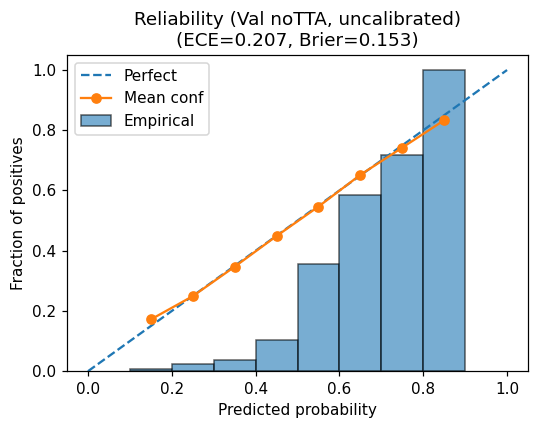

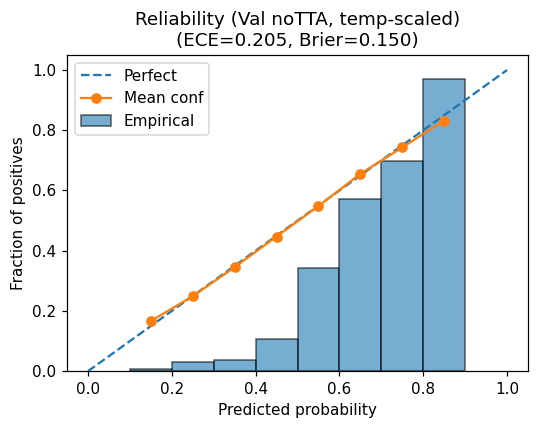

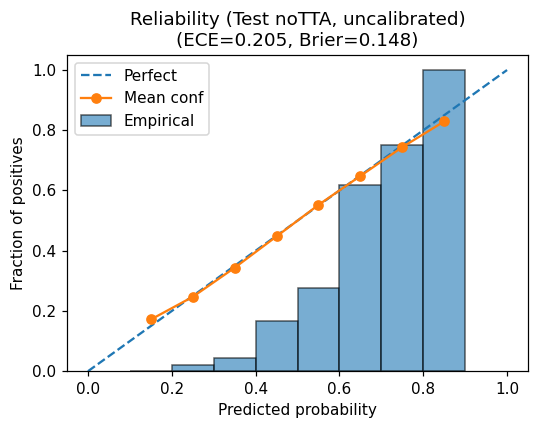

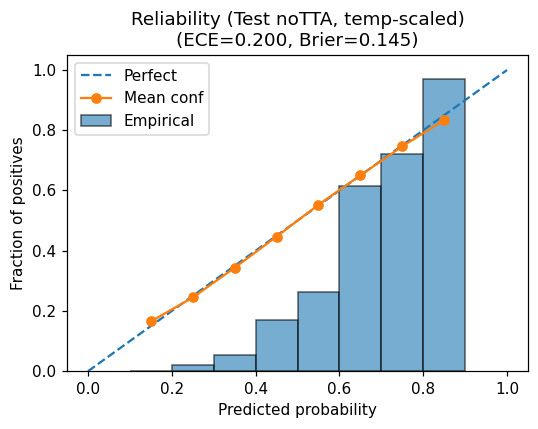


[Val TTA]  before calibration: {'acc': 0.8323651452282158, 'prec': 0.5818639798488665, 'rec': 0.8651685393258427, 'f1': 0.6957831325301205, 'spec': np.float64(0.8230277185413323), 'roc_auc': np.float64(0.9138057705054184), 'pr_auc': np.float64(0.7539101992415163)}
[Val TTA]  after  calibration: {'acc': 0.8323651452282158, 'prec': 0.5818639798488665, 'rec': 0.8651685393258427, 'f1': 0.6957831325301205, 'spec': np.float64(0.8230277185413323), 'roc_auc': np.float64(0.9138057705054184), 'pr_auc': np.float64(0.7539101992415163)}

[Test TTA] before calibration: {'acc': 0.8282157676348548, 'prec': 0.5746268656716418, 'rec': 0.8651685393258427, 'f1': 0.6905829596412556, 'spec': np.float64(0.8176972281362719), 'roc_auc': np.float64(0.9168882713239581), 'pr_auc': np.float64(0.767946356992047)}
[Test TTA] after  calibration: {'acc': 0.8282157676348548, 'prec': 0.5746268656716418, 'rec': 0.8651685393258427, 'f1': 0.6905829596412556, 'spec': np.float64(0.8176972281362719), 'roc_auc': np.float64(0.

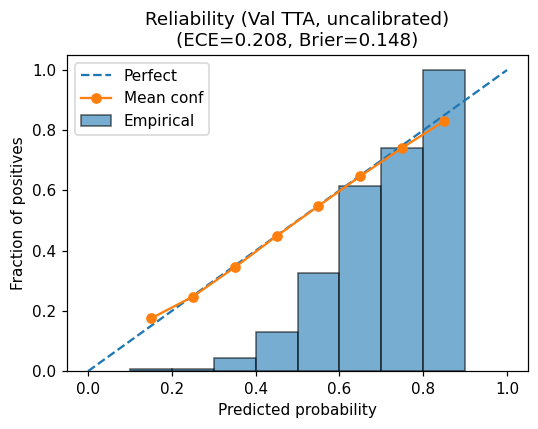

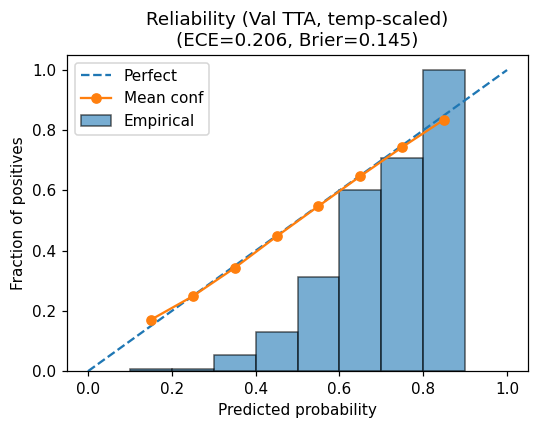

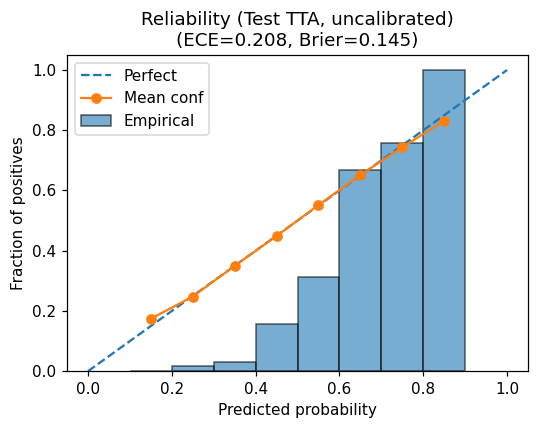

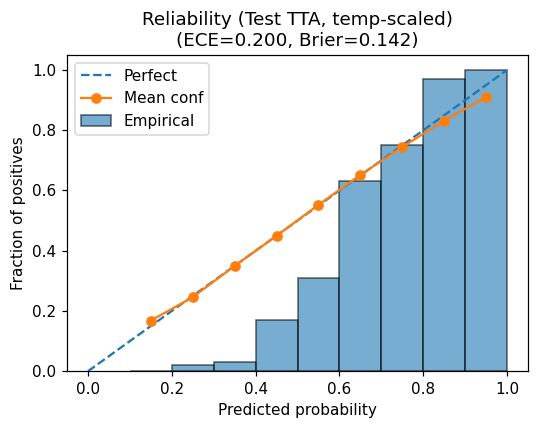

{'ece': 0.2003105676861759,
 'mce': 0.3203164651910952,
 'brier': 0.1417573387712653,
 'bin_acc': array([       nan, 0.        , 0.02040816, 0.02955665, 0.17021277,
        0.31034483, 0.63114754, 0.75      , 0.97058824, 1.        ]),
 'bin_conf': array([       nan, 0.1681283 , 0.24582654, 0.34987312, 0.449418  ,
        0.55239151, 0.65168685, 0.74431763, 0.83214654, 0.9099371 ]),
 'bin_centers': array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]),
 'bin_counts': array([  0, 165, 294, 203, 141, 145, 122, 100,  34,   1])}

In [62]:
T_opt = tune_temperature(model, dl_val, device)

temp_path = os.path.join(OUT_DIR, "best_temperature.txt")
with open(temp_path, "w") as f:
    f.write(f"{T_opt:.6f}\n")
print(f"[Calib] Saved temperature to: {temp_path}")

def apply_temperature_to_probs(probs, T):
    probs = np.asarray(probs, dtype=np.float64).ravel()
    eps = 1e-7
    probs = np.clip(probs, eps, 1.0 - eps)
    logits = np.log(probs / (1.0 - probs))
    logits_T = logits / float(T)
    probs_T = 1.0 / (1.0 + np.exp(-logits_T))
    return probs_T


def compute_metrics_from_probs(y_true, y_prob, threshold=0.5):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).ravel()
    y_pred = (y_prob >= threshold).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # specificity
    try:
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")
    except Exception:
        spec = float("nan")

    try:
        roc = roc_auc_score(y_true, y_prob)
    except Exception:
        roc = float("nan")

    try:
        pr  = average_precision_score(y_true, y_prob)
    except Exception:
        pr  = float("nan")

    return {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "spec": spec,
        "roc_auc": roc,
        "pr_auc": pr,
    }

val_metrics_cal_notta,  yv_cal_notta,  pv_cal_notta,  sv_cal_notta  = evaluate(
    model, dl_val,  device, cls_threshold=0.5, temperature=T_opt
)
test_metrics_cal_notta, yt_cal_notta, pt_cal_notta, st_cal_notta = evaluate(
    model, dl_test, device, cls_threshold=0.5, temperature=T_opt
)

print("\n[Val noTTA]  before calibration:", val_metrics_notta)
print("[Val noTTA]  after  calibration:",  val_metrics_cal_notta)

print("\n[Test noTTA] before calibration:", test_metrics_notta)
print("[Test noTTA] after  calibration:",  test_metrics_cal_notta)

# ECE / Brier
cal_val_notta_before = compute_calibration_metrics(yv_notta,      sv_notta,      n_bins=10)
cal_val_notta_after  = compute_calibration_metrics(yv_cal_notta,  sv_cal_notta,  n_bins=10)

cal_test_notta_before = compute_calibration_metrics(yt_notta,     st_notta,     n_bins=10)
cal_test_notta_after  = compute_calibration_metrics(yt_cal_notta, st_cal_notta, n_bins=10)

print("\n[Val noTTA]  ECE before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_val_notta_before["ece"], cal_val_notta_after["ece"],
    cal_val_notta_before["ece"] - cal_val_notta_after["ece"]
))
print("[Val noTTA]  Brier before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_val_notta_before["brier"], cal_val_notta_after["brier"],
    cal_val_notta_before["brier"] - cal_val_notta_after["brier"]
))

print("\n[Test noTTA] ECE before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_test_notta_before["ece"], cal_test_notta_after["ece"],
    cal_test_notta_before["ece"] - cal_test_notta_after["ece"]
))
print("[Test noTTA] Brier before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_test_notta_before["brier"], cal_test_notta_after["brier"],
    cal_test_notta_before["brier"] - cal_test_notta_after["brier"]
))

# Reliability (noTTA）
plot_reliability_diagram(
    yv_notta, sv_notta,
    out_path=os.path.join(OUT_DIR, "val_notta_reliability_before.png"),
    n_bins=10,
    title="Reliability (Val noTTA, uncalibrated)"
)

plot_reliability_diagram(
    yv_cal_notta, sv_cal_notta,
    out_path=os.path.join(OUT_DIR, "val_notta_reliability_after_temp.png"),
    n_bins=10,
    title="Reliability (Val noTTA, temp-scaled)"
)

plot_reliability_diagram(
    yt_notta, st_notta,
    out_path=os.path.join(OUT_DIR, "test_notta_reliability_before.png"),
    n_bins=10,
    title="Reliability (Test noTTA, uncalibrated)"
)

plot_reliability_diagram(
    yt_cal_notta, st_cal_notta,
    out_path=os.path.join(OUT_DIR, "test_notta_reliability_after_temp.png"),
    n_bins=10,
    title="Reliability (Test noTTA, temp-scaled)"
)

sv_val_tta_cal  = apply_temperature_to_probs(sv_tta,  T_opt)
st_test_tta_cal = apply_temperature_to_probs(st_tta, T_opt)

val_metrics_cal_tta  = compute_metrics_from_probs(yv_tta, sv_val_tta_cal,  threshold=0.5)
test_metrics_cal_tta = compute_metrics_from_probs(yt_tta, st_test_tta_cal, threshold=0.5)

print("\n[Val TTA]  before calibration:", val_metrics_tta)
print("[Val TTA]  after  calibration:",  val_metrics_cal_tta)

print("\n[Test TTA] before calibration:", test_metrics_tta)
print("[Test TTA] after  calibration:",  test_metrics_cal_tta)

# ECE / Brier（TTA）
cal_val_tta_before = compute_calibration_metrics(yv_tta,      sv_tta,         n_bins=10)
cal_val_tta_after  = compute_calibration_metrics(yv_tta,      sv_val_tta_cal, n_bins=10)

cal_test_tta_before = compute_calibration_metrics(yt_tta,     st_tta,        n_bins=10)
cal_test_tta_after  = compute_calibration_metrics(yt_tta,     st_test_tta_cal, n_bins=10)

print("\n[Val TTA]  ECE before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_val_tta_before["ece"], cal_val_tta_after["ece"],
    cal_val_tta_before["ece"] - cal_val_tta_after["ece"]
))
print("[Val TTA]  Brier before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_val_tta_before["brier"], cal_val_tta_after["brier"],
    cal_val_tta_before["brier"] - cal_val_tta_after["brier"]
))

print("\n[Test TTA] ECE before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_test_tta_before["ece"], cal_test_tta_after["ece"],
    cal_test_tta_before["ece"] - cal_test_tta_after["ece"]
))
print("[Test TTA] Brier before={:.4f}, after={:.4f}, Δ={:.4f}".format(
    cal_test_tta_before["brier"], cal_test_tta_after["brier"],
    cal_test_tta_before["brier"] - cal_test_tta_after["brier"]
))

# Reliability（TTA）
plot_reliability_diagram(
    yv_tta, sv_tta,
    out_path=os.path.join(OUT_DIR, "val_tta_reliability_before.png"),
    n_bins=10,
    title="Reliability (Val TTA, uncalibrated)"
)

plot_reliability_diagram(
    yv_tta, sv_val_tta_cal,
    out_path=os.path.join(OUT_DIR, "val_tta_reliability_after_temp.png"),
    n_bins=10,
    title="Reliability (Val TTA, temp-scaled)"
)

plot_reliability_diagram(
    yt_tta, st_tta,
    out_path=os.path.join(OUT_DIR, "test_tta_reliability_before.png"),
    n_bins=10,
    title="Reliability (Test TTA, uncalibrated)"
)

plot_reliability_diagram(
    yt_tta, st_test_tta_cal,
    out_path=os.path.join(OUT_DIR, "test_tta_reliability_after_temp.png"),
    n_bins=10,
    title="Reliability (Test TTA, temp-scaled)"
)

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ece_brier_comparison(
    cal_notta_before: dict,
    cal_notta_after: dict,
    cal_tta_before: dict,
    cal_tta_after: dict,
    split_name: str,
    out_dir: str,
):
    labels = ["noTTA-before", "noTTA-after", "TTA-before", "TTA-after"]

    eces = [
        cal_notta_before["ece"],
        cal_notta_after["ece"],
        cal_tta_before["ece"],
        cal_tta_after["ece"],
    ]
    briers = [
        cal_notta_before["brier"],
        cal_notta_after["brier"],
        cal_tta_before["brier"],
        cal_tta_after["brier"],
    ]

    x = np.arange(len(labels))

    # ECA comparison
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x, eces)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=20)
    ax.set_ylabel("ECE")
    ax.set_title(f"{split_name} ECE (noTTA vs TTA, before/after calibration)")
    ax.grid(axis="y", alpha=0.3)
    plt.show()
    plt.tight_layout()

    ece_path = os.path.join(out_dir, f"{split_name.lower()}_ece_notta_vs_tta.png")
    plt.savefig(ece_path, dpi=300)
    plt.show()
    plt.close(fig)
    print(f"[Plot] Saved ECE comparison to: {ece_path}")

    # Brier comparison
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x, briers)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=20)
    ax.set_ylabel("Brier score")
    ax.set_title(f"{split_name} Brier (noTTA vs TTA, before/after calibration)")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()

    brier_path = os.path.join(out_dir, f"{split_name.lower()}_brier_notta_vs_tta.png")
    plt.savefig(brier_path, dpi=300)
    plt.show
    plt.close(fig)
    print(f"[Plot] Saved Brier comparison to: {brier_path}")

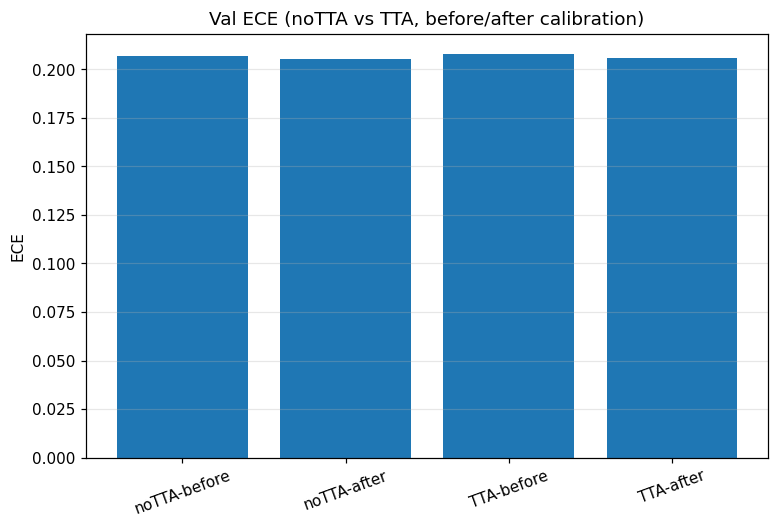

<Figure size 704x528 with 0 Axes>

[Plot] Saved ECE comparison to: ./Baseline+ECA(7000)_Output\val_ece_notta_vs_tta.png
[Plot] Saved Brier comparison to: ./Baseline+ECA(7000)_Output\val_brier_notta_vs_tta.png


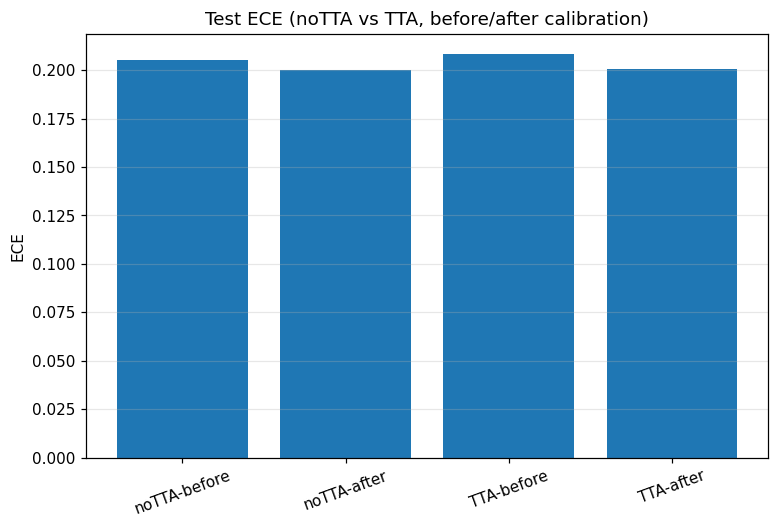

<Figure size 704x528 with 0 Axes>

[Plot] Saved ECE comparison to: ./Baseline+ECA(7000)_Output\test_ece_notta_vs_tta.png
[Plot] Saved Brier comparison to: ./Baseline+ECA(7000)_Output\test_brier_notta_vs_tta.png


In [64]:
# ECE/Brier on Val
plot_ece_brier_comparison(
    cal_notta_before=cal_val_notta_before,
    cal_notta_after=cal_val_notta_after,
    cal_tta_before=cal_val_tta_before,
    cal_tta_after=cal_val_tta_after,
    split_name="Val",
    out_dir=OUT_DIR,
)

# ECE/Brier on Test
plot_ece_brier_comparison(
    cal_notta_before=cal_test_notta_before,
    cal_notta_after=cal_test_notta_after,
    cal_tta_before=cal_test_tta_before,
    cal_tta_after=cal_test_tta_after,
    split_name="Test",
    out_dir=OUT_DIR,
)

### 18.3 Plots

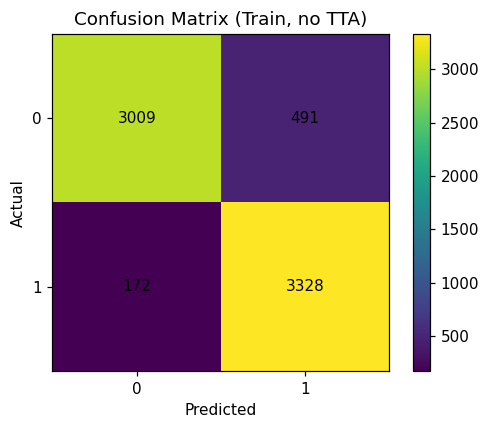

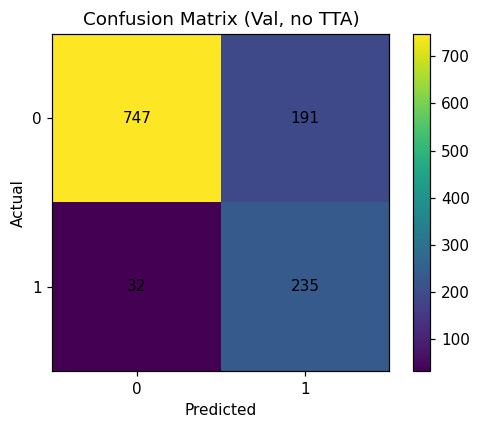

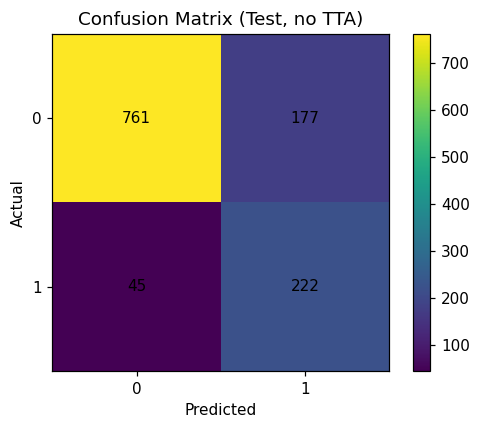

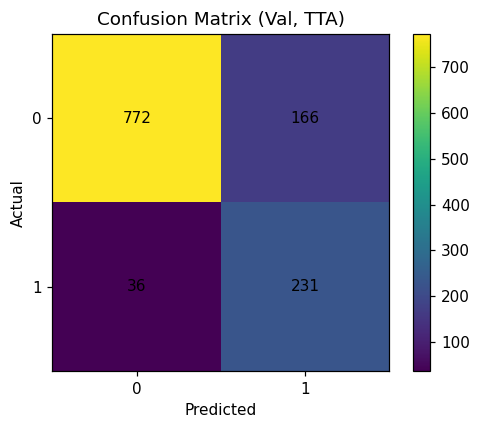

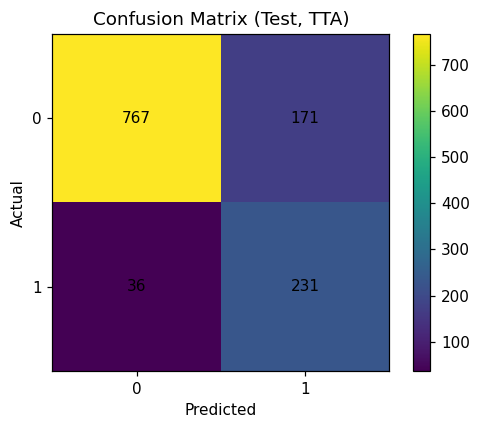

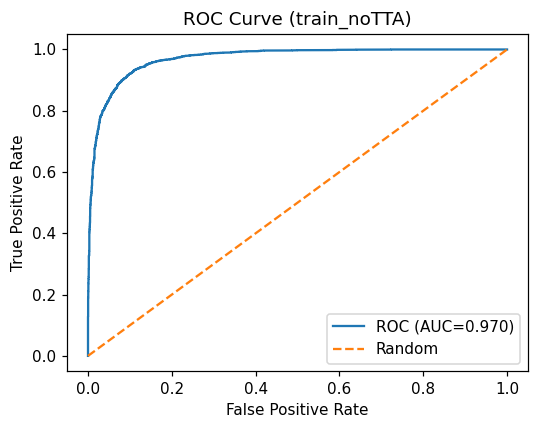

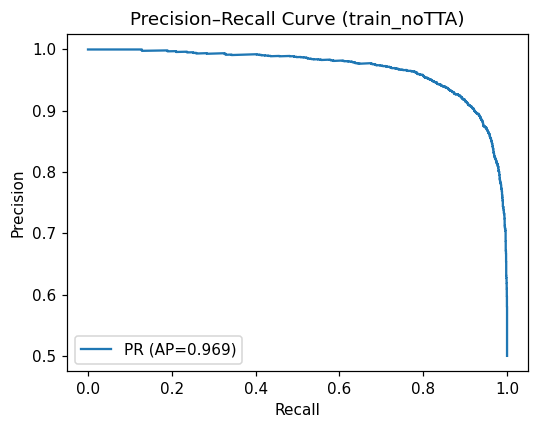

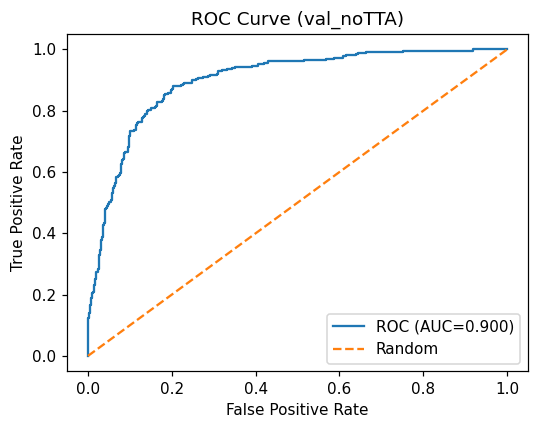

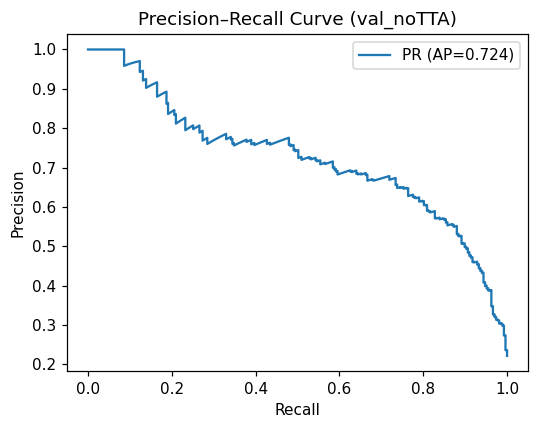

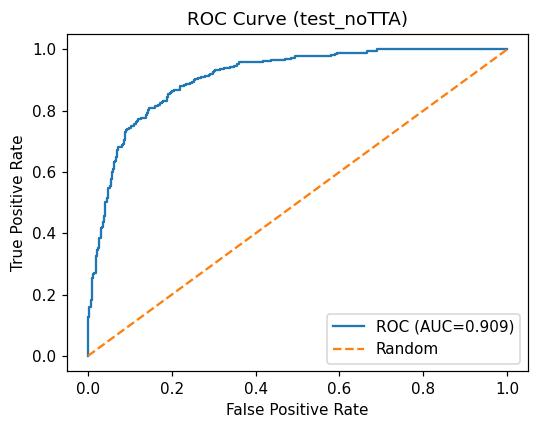

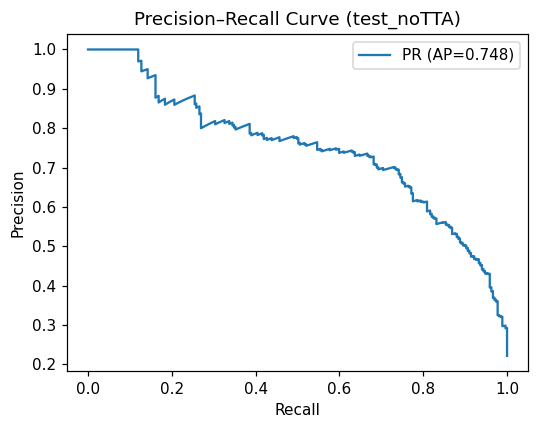

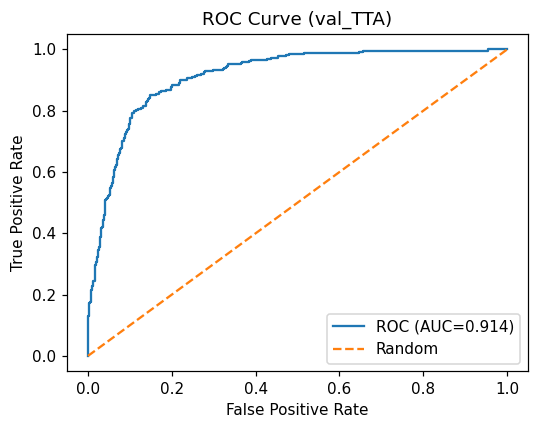

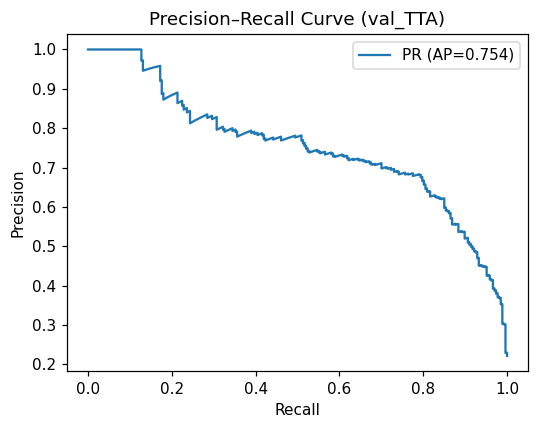

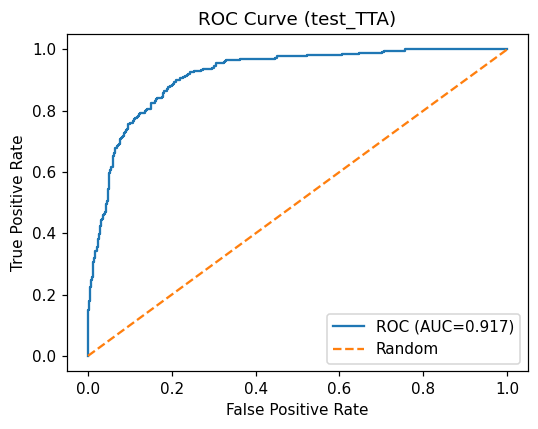

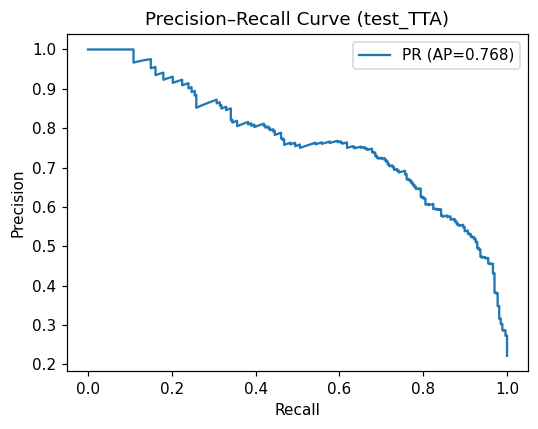

In [65]:
# ==========================
# Confusion matrices
# ==========================
plot_confusion_matrix(
    ytr_best, ptr_best,
    out_path=os.path.join(OUT_DIR, "confmat_train_notta.png"),
    title="Confusion Matrix (Train, no TTA)"
)

plot_confusion_matrix(
    yv_notta, pv_notta,
    out_path=os.path.join(OUT_DIR, "confmat_val_notta.png"),
    title="Confusion Matrix (Val, no TTA)"
)

plot_confusion_matrix(
    yt_notta, pt_notta,
    out_path=os.path.join(OUT_DIR, "confmat_test_notta.png"),
    title="Confusion Matrix (Test, no TTA)"
)

plot_confusion_matrix(
    yv_tta, pv_tta,
    out_path=os.path.join(OUT_DIR, "confmat_val_tta.png"),
    title="Confusion Matrix (Val, TTA)"
)

plot_confusion_matrix(
    yt_tta, pt_tta,
    out_path=os.path.join(OUT_DIR, "confmat_test_tta.png"),
    title="Confusion Matrix (Test, TTA)"
)

# ==========================
# ROC / PR curves
# ==========================

# 1) Train（本来就没 TTA）
plot_roc_pr(
    y_true=ytr_best,
    y_score=str_best,
    out_dir=OUT_DIR,
    prefix="train_noTTA",
    roc_auc=train_metrics_best["roc_auc"],
    pr_auc=train_metrics_best["pr_auc"],
)

# 2) Val / Test：no TTA
plot_roc_pr(
    y_true=yv_notta,
    y_score=sv_notta,
    out_dir=OUT_DIR,
    prefix="val_noTTA",
    roc_auc=val_metrics_notta["roc_auc"],
    pr_auc=val_metrics_notta["pr_auc"],
)

plot_roc_pr(
    y_true=yt_notta,
    y_score=st_notta,
    out_dir=OUT_DIR,
    prefix="test_noTTA",
    roc_auc=test_metrics_notta["roc_auc"],
    pr_auc=test_metrics_notta["pr_auc"],
)

# 3) Val / Test：TTA
plot_roc_pr(
    y_true=yv_tta,
    y_score=sv_tta,
    out_dir=OUT_DIR,
    prefix="val_TTA",
    roc_auc=val_metrics_tta["roc_auc"],
    pr_auc=val_metrics_tta["pr_auc"],
)

plot_roc_pr(
    y_true=yt_tta,
    y_score=st_tta,
    out_dir=OUT_DIR,
    prefix="test_TTA",
    roc_auc=test_metrics_tta["roc_auc"],
    pr_auc=test_metrics_tta["pr_auc"],
)


### 18.3 Train/Val/Test Comparison

[Debug] metrics_df columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
[Info] Saved metrics summary to: ./Baseline+ECA(7000)_Output\metrics_summary_base6.csv


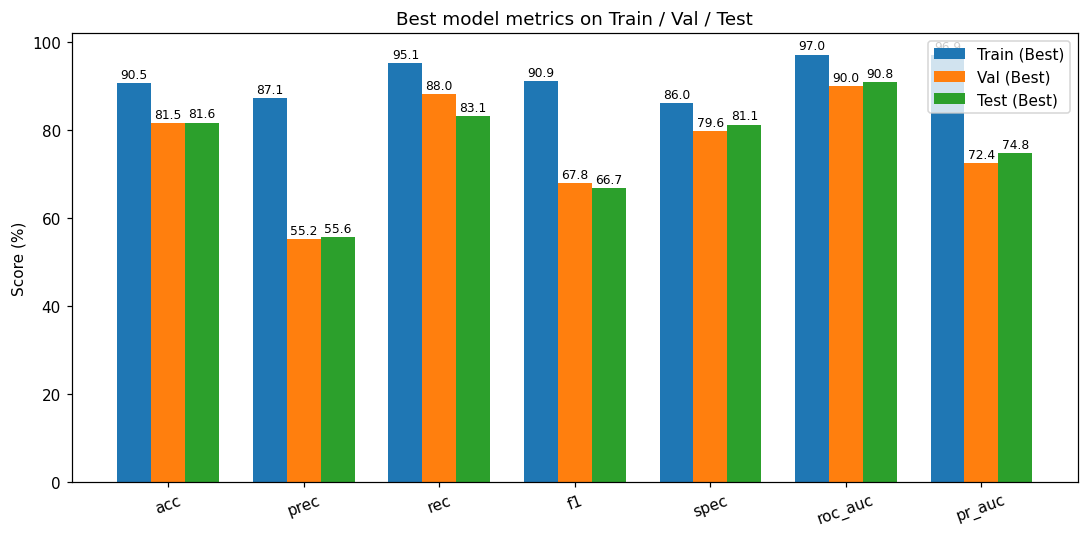

[Info] Saved: ./Baseline+ECA(7000)_Output\metrics_bar_train_val_test_best.png


In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rows = [
    {"Split": "Train (Best)", **train_pct},
    {"Split": "Val (Best)",   **val_pct},
    {"Split": "Test (Best)",  **test_pct},
]

metrics_df = pd.DataFrame(rows)

metric_cols = [c for c in metrics_df.columns if c != "Split"]
metrics_df = metrics_df[["Split"] + metric_cols]

print("[Debug] metrics_df columns:", list(metrics_df.columns))

metrics_csv_path = os.path.join(OUT_DIR, "metrics_summary_base6.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"[Info] Saved metrics summary to: {metrics_csv_path}")

x = np.arange(len(metric_cols)) 
width = 0.25                 

plt.figure(figsize=(10, 5))

for i, split in enumerate(metrics_df["Split"]):
    values = metrics_df.loc[i, metric_cols].values.astype(float)
    offset = (i - 1) * width  
    bars = plt.bar(x + offset, values, width, label=split)

    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=8)

xtick_labels = [
    c.replace("(%)", "").replace("%", "").strip()
    for c in metric_cols
]

plt.xticks(x, xtick_labels, rotation=20)
plt.ylabel("Score (%)")
plt.title("Best model metrics on Train / Val / Test")
plt.legend()
plt.tight_layout()

bar_fig_path = os.path.join(OUT_DIR, "metrics_bar_train_val_test_best.png")
plt.savefig(bar_fig_path, dpi=300)
plt.show()
print(f"[Info] Saved: {bar_fig_path}")


### 18.4 Seg

In [67]:
def compute_dice_iou(preds: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6):
    preds_f   = preds.view(preds.size(0), -1)
    targets_f = targets.view(targets.size(0), -1)

    inter = (preds_f * targets_f).sum(dim=1)
    union = preds_f.sum(dim=1) + targets_f.sum(dim=1)

    dice = (2.0 * inter + eps) / (union + eps)

    iou_den = (preds_f + targets_f - preds_f * targets_f).sum(dim=1)
    iou = (inter + eps) / (iou_den + eps)

    return dice, iou


def denormalize(img_tensor: torch.Tensor):
    img = img_tensor.detach().cpu().clone()
    img = img * 0.25 + 0.5   # x * std + mean
    img = img.clamp(0.0, 1.0)
    return img.squeeze(0).numpy()

@torch.no_grad()
def visualize_segmentation_examples(
    model,
    loader,
    device,
    threshold: float = 0.5,
    num_pos: int = 2,
    num_neg: int = 2,
    num_hard: int = 2,
    save_dir: str = None,
    prefix: str = "seg_example",
):

    model.eval()
    pos_shown = neg_shown = hard_shown = 0
    example_idx = 0 

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    for xb, yb, mb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        mb = mb.to(device, non_blocking=True)

        out = model(xb)
        if isinstance(out, tuple):
            _, seg_logits = out  # (cls_logits, seg_logits)
        else:
            raise ValueError("Model output must be (cls_logits, seg_logits)")

        # [B,1,H,W]
        probs = torch.sigmoid(seg_logits)
        preds = (probs >= threshold).float()

        dice_batch, iou_batch = compute_dice_iou(preds, mb)

        for i in range(xb.size(0)):
            dice_val = float(dice_batch[i].cpu().item())
            iou_val  = float(iou_batch[i].cpu().item())
            label    = int(yb[i].cpu().item())

            category = None
            title_suffix = ""

            if label == 1 and dice_val >= 0.8 and pos_shown < num_pos:
                category = "pos"
                title_suffix = f"Positive, easy (Dice={dice_val:.2f}, IoU={iou_val:.2f})"

            elif label == 0 and dice_val >= 0.95 and neg_shown < num_neg:
                category = "neg"
                title_suffix = f"Negative (Dice={dice_val:.2f}, IoU={iou_val:.2f})"

            elif label == 1 and 0.3 <= dice_val <= 0.7 and hard_shown < num_hard:
                category = "hard"
                title_suffix = f"Positive, hard (Dice={dice_val:.2f}, IoU={iou_val:.2f})"

            if category is None:
                continue

            img_np  = denormalize(xb[i])                # [H,W]
            gt_mask = mb[i].detach().cpu().numpy().squeeze()   # [H,W]
            pr_mask = preds[i].detach().cpu().numpy().squeeze() # [H,W]

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))

            axes[0].imshow(img_np, cmap="gray")
            axes[0].set_title(f"Image (label={label})")
            axes[0].axis("off")

            axes[1].imshow(img_np, cmap="gray")
            axes[1].imshow(gt_mask, cmap="jet", alpha=0.4)
            axes[1].set_title("Ground Truth mask (overlay)")
            axes[1].axis("off")

            axes[2].imshow(img_np, cmap="gray")
            axes[2].imshow(pr_mask, cmap="jet", alpha=0.4)
            axes[2].set_title(f"Predicted mask\nDice={dice_val:.2f}, IoU={iou_val:.2f}")
            axes[2].axis("off")

            plt.suptitle(title_suffix)
            plt.tight_layout()

            if save_dir is not None:
                fname = f"{prefix}_{category}_{example_idx}.png"
                fig.savefig(os.path.join(save_dir, fname), dpi=300)

            plt.show()
            example_idx += 1

            if category == "pos":
                pos_shown += 1
            elif category == "neg":
                neg_shown += 1
            elif category == "hard":
                hard_shown += 1

            if pos_shown >= num_pos and neg_shown >= num_neg and hard_shown >= num_hard:
                return

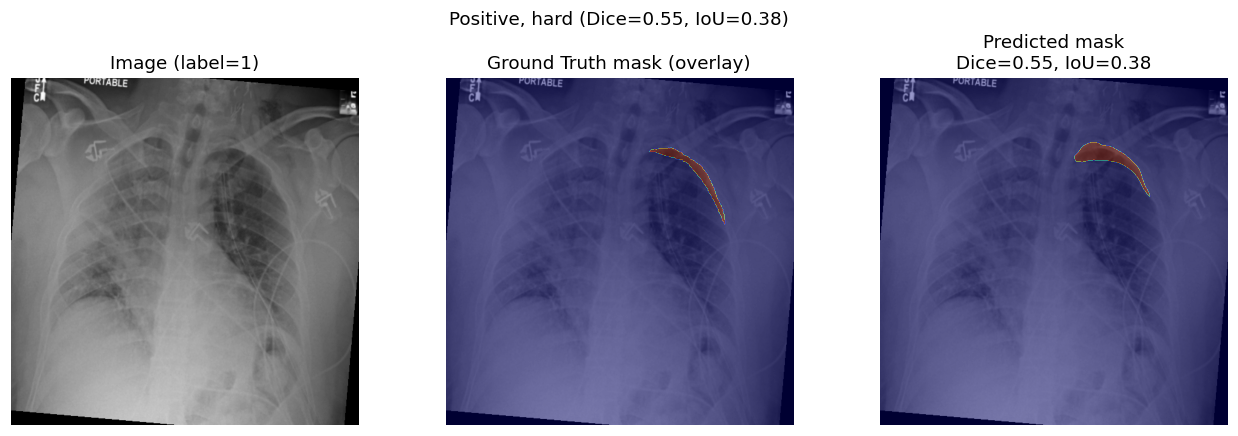

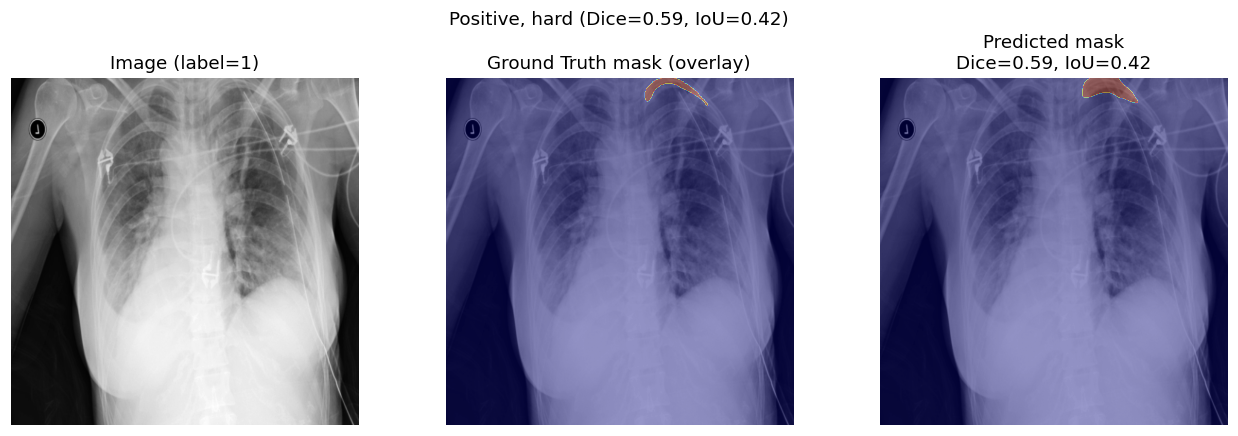

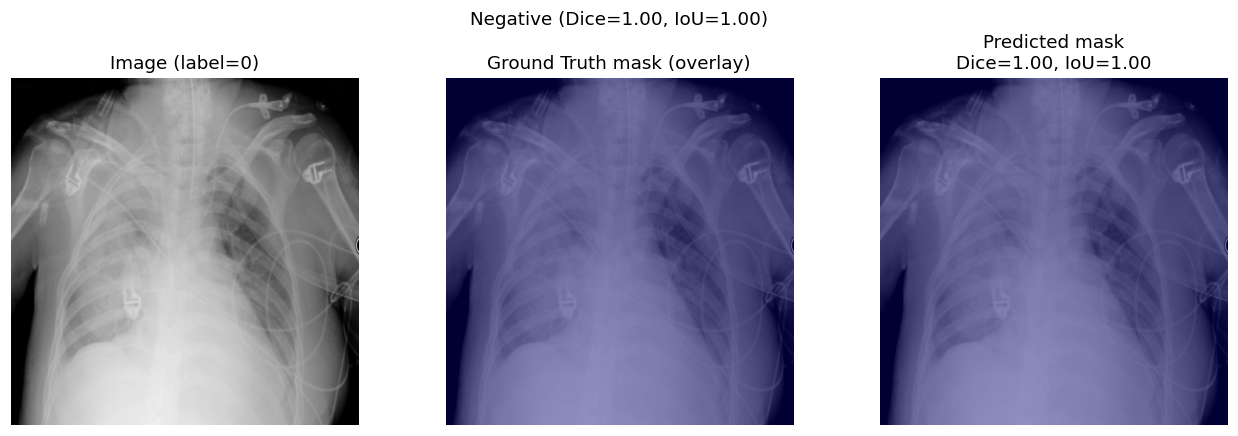

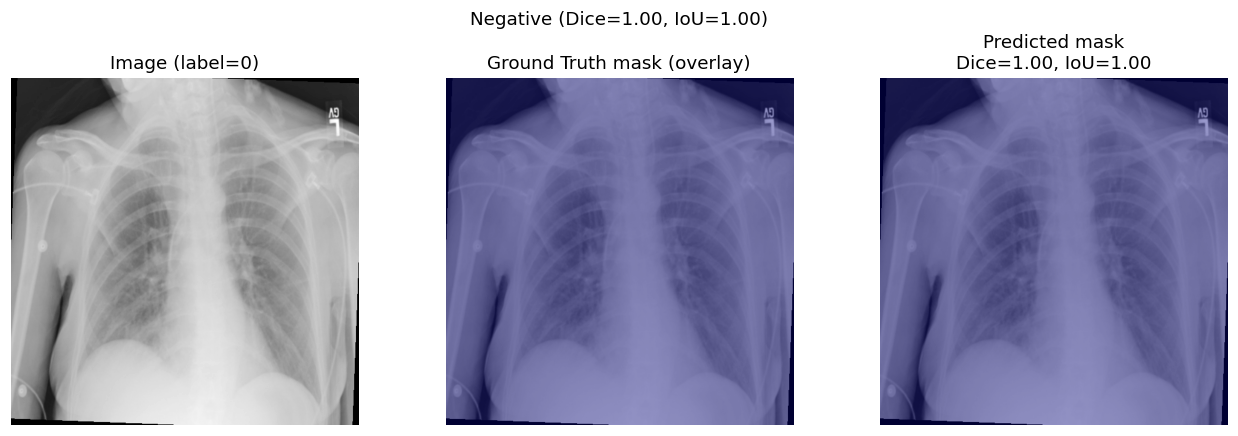

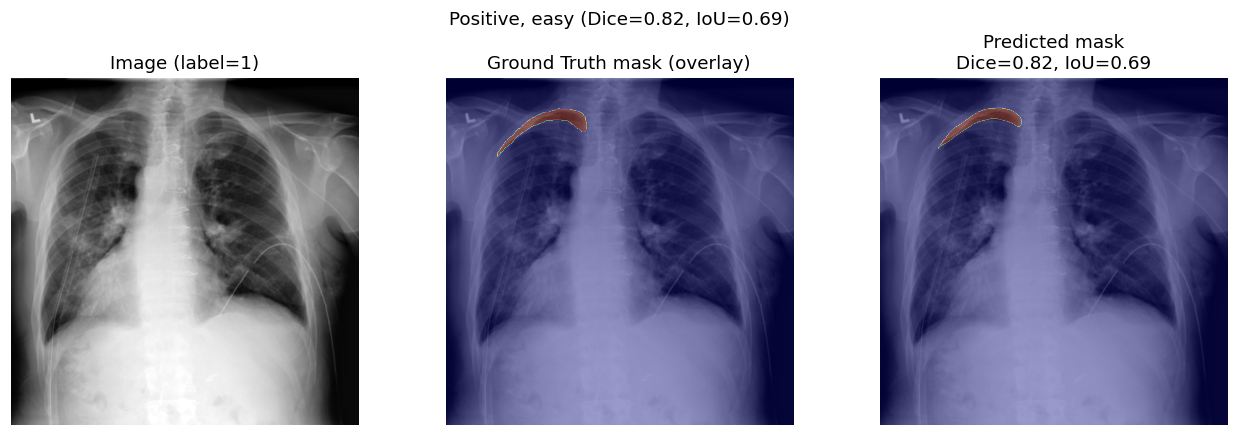

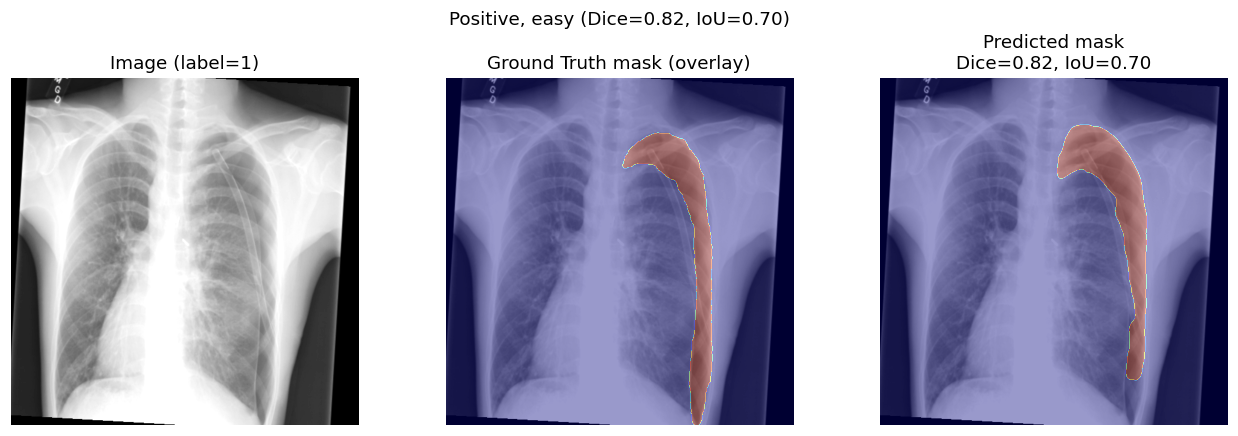

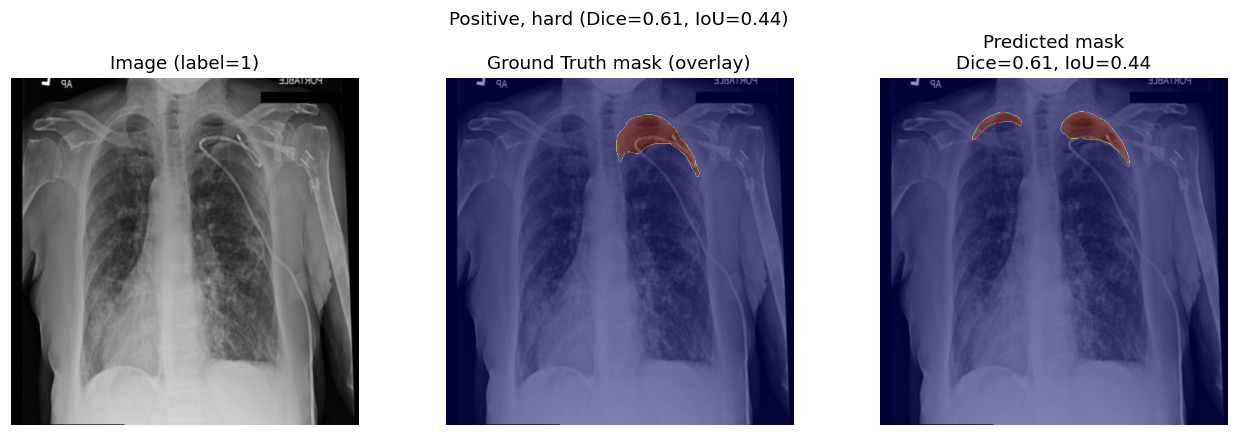

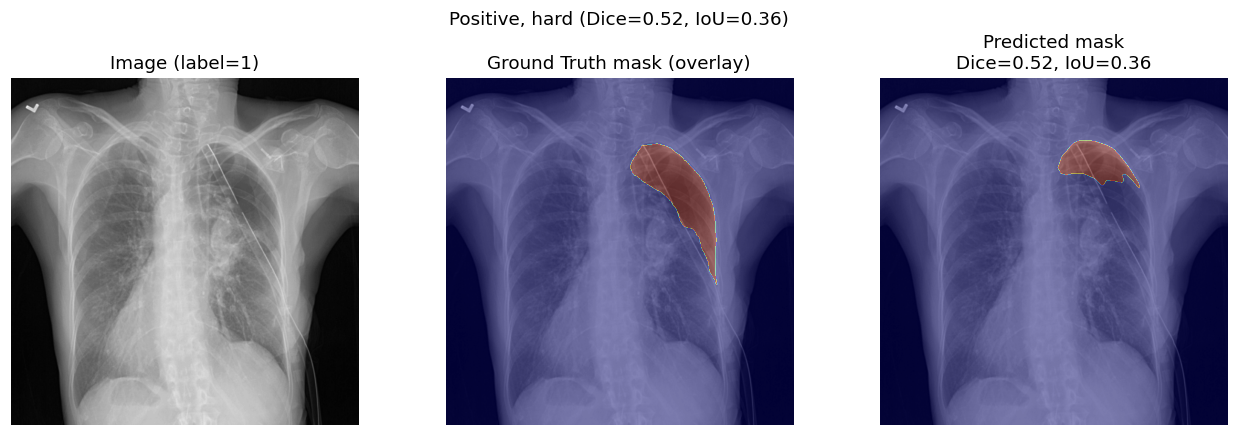

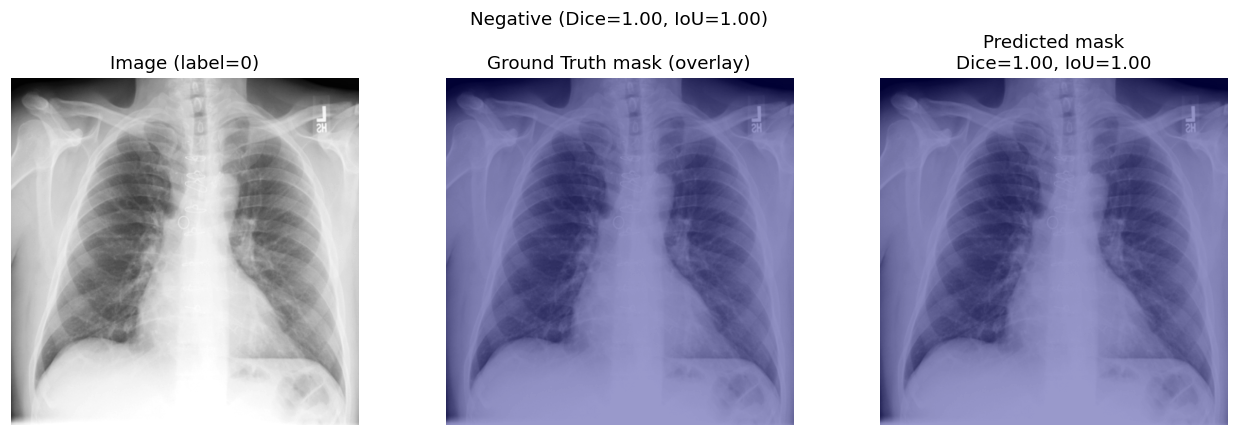

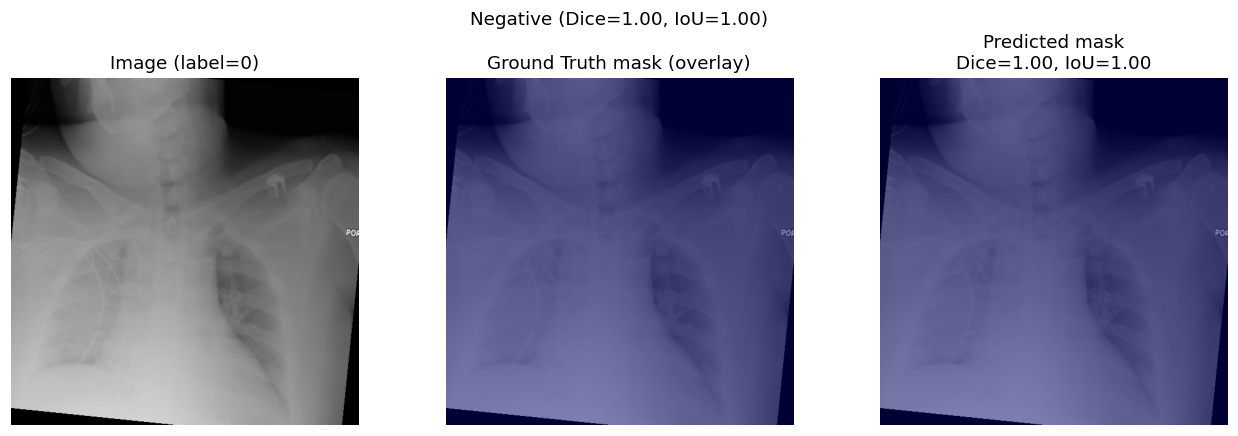

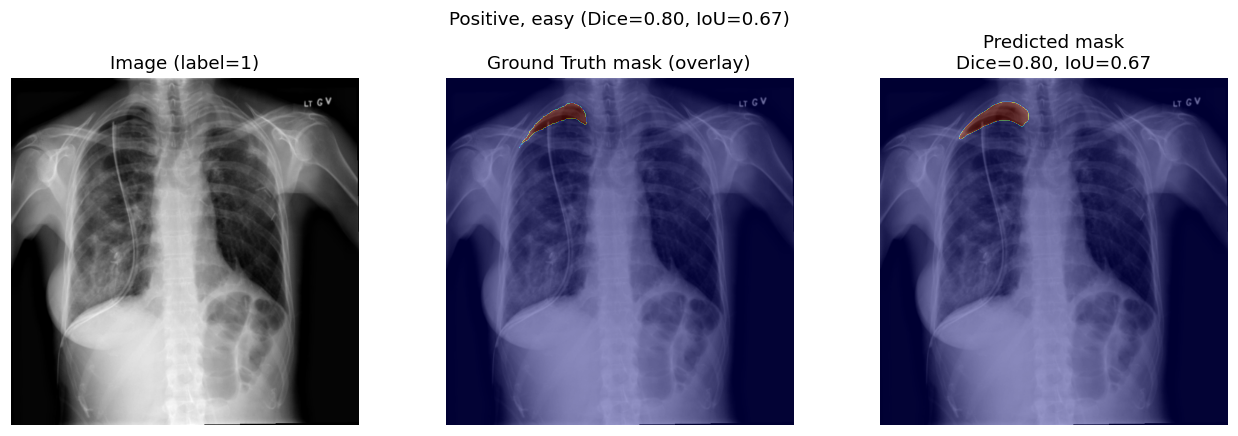

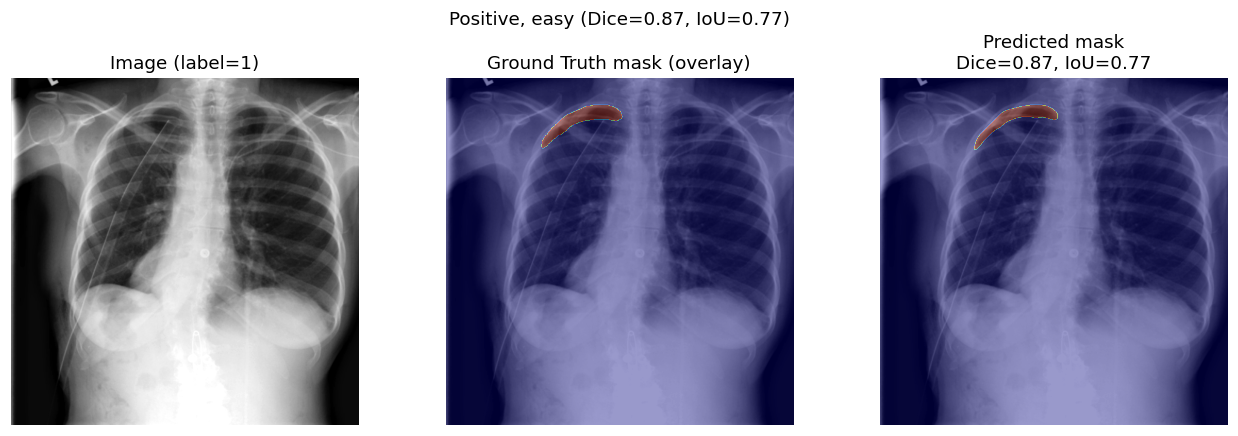

In [68]:
visualize_segmentation_examples(
    model=model,        
    loader=dl_train,    
    device=device,
    threshold=0.5,   
    num_pos=2,
    num_neg=2,
    num_hard=2,
    save_dir=OUT_DIR, 
    prefix="seg_train_examples"
)

eval_mask_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

ds_test_seg = PandasImageMaskDataset(test_df, mask_root=MASK_ROOT, joint_transform=eval_mask_tfms)
dl_test_seg = DataLoader(ds_test_seg, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

visualize_segmentation_examples(
    model=model,
    loader=dl_test_seg,
    device=device,
    threshold=0.5,
    num_pos=2,
    num_neg=2,
    num_hard=2,
    save_dir=OUT_DIR,
    prefix="seg_test_examples"
)


### 18.5 Segmentation metrics on Test set (Dice / IoU + hist) test

Seg Eval (Test):   0%|          | 0/302 [00:00<?, ?it/s]

[Seg @ Test, positive masks only]
Dice: mean=0.4589, median=0.4795
IoU : mean=0.3339, median=0.3153
Num positive masks: 266


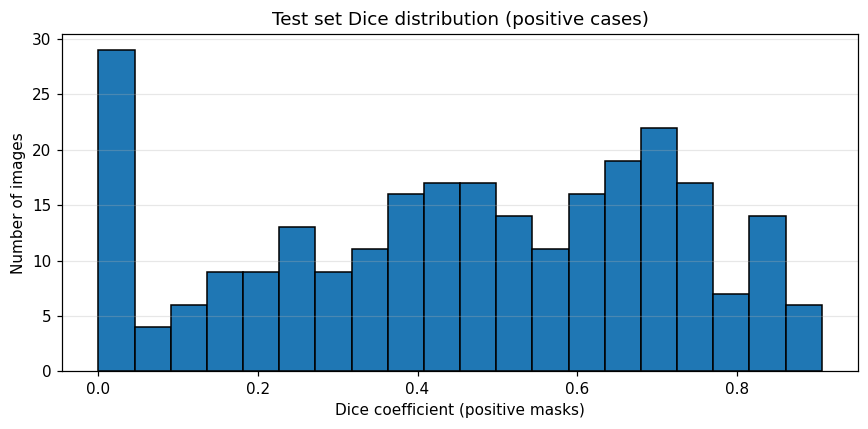

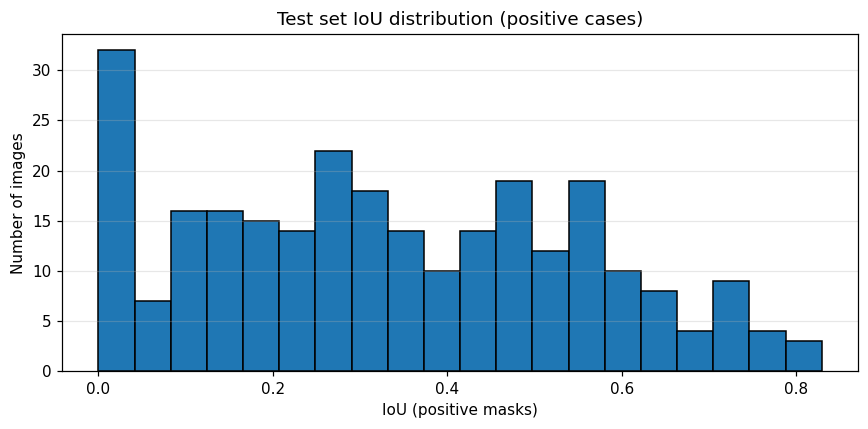

In [69]:
from tqdm.auto import tqdm
model.eval()

all_dice_pos = []
all_iou_pos  = []

with torch.no_grad():
    for xb, yb, mb in tqdm(dl_test_seg, desc="Seg Eval (Test)"):
        xb = xb.to(device)          
        mb = mb.to(device)          # GT mask, [B,1,H,W], 0/1

        cls_logits, seg_logits = model(xb)   # seg_logits: [B,1,H,W]

        seg_probs = torch.sigmoid(seg_logits)
        seg_pred  = (seg_probs > 0.5).float()

        dice_batch, iou_batch = compute_dice_iou(seg_pred, mb) 
        pos_mask = (mb.view(mb.size(0), -1).sum(dim=1) > 0)

        if pos_mask.any():
            all_dice_pos.extend(dice_batch[pos_mask].cpu().numpy().tolist())
            all_iou_pos.extend(iou_batch[pos_mask].cpu().numpy().tolist())

all_dice_pos = np.array(all_dice_pos)
all_iou_pos  = np.array(all_iou_pos)

print(f"[Seg @ Test, positive masks only]")
print(f"Dice: mean={all_dice_pos.mean():.4f}, median={np.median(all_dice_pos):.4f}")
print(f"IoU : mean={all_iou_pos .mean():.4f}, median={np.median(all_iou_pos ):.4f}")
print(f"Num positive masks: {len(all_dice_pos)}")

# np.save(os.path.join(OUT_DIR, "test_seg_dice_pos.npy"), all_dice_pos)
# np.save(os.path.join(OUT_DIR, "test_seg_iou_pos.npy"),  all_iou_pos)

plt.figure(figsize=(8, 4))
plt.hist(all_dice_pos, bins=20, edgecolor="black")
plt.xlabel("Dice coefficient (positive masks)")
plt.ylabel("Number of images")
plt.title("Test set Dice distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "test_seg_dice_hist_pos.png"), dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(all_iou_pos, bins=20, edgecolor="black")
plt.xlabel("IoU (positive masks)")
plt.ylabel("Number of images")
plt.title("Test set IoU distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "test_seg_iou_hist_pos.png"), dpi=300)
plt.show()


### 18.6 Segmentation metrics on Test set (Dice / IoU + hist) test

Seg Eval (Train):   0%|          | 0/2669 [00:00<?, ?it/s]

[Seg @ Train, positive masks only]
Dice: mean=0.5067, median=0.5593
IoU : mean=0.3805, median=0.3882
Num positive masks: 2373


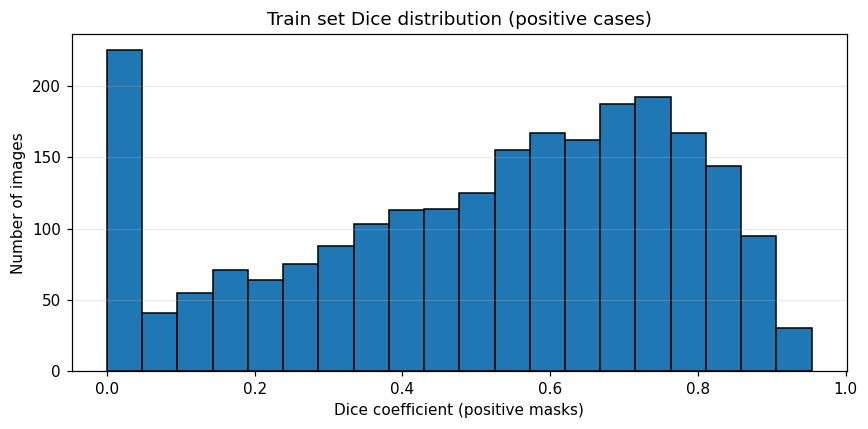

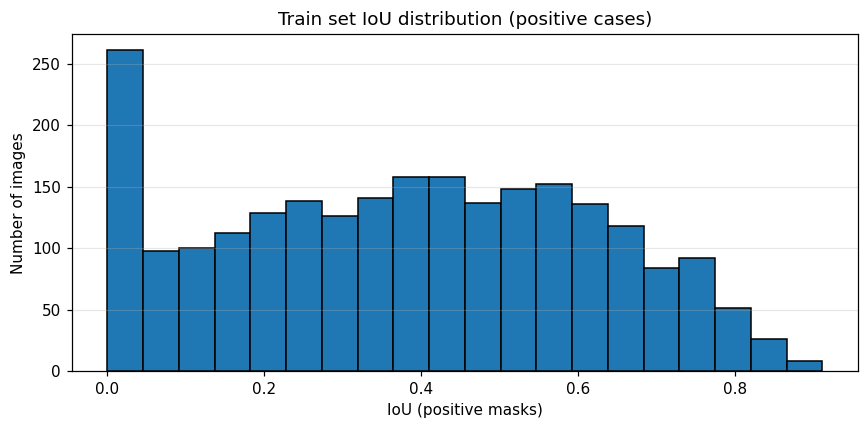

In [70]:
from tqdm.auto import tqdm
model.eval()

eval_train_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

ds_train_seg = PandasImageMaskDataset(train_df, mask_root=MASK_ROOT, joint_transform=eval_train_tfms)
dl_train_seg = DataLoader(ds_train_seg, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

all_dice_pos = []
all_iou_pos  = []

with torch.no_grad():
    for xb, yb, mb in tqdm(dl_train_seg, desc="Seg Eval (Train)"):
        xb = xb.to(device)          
        mb = mb.to(device)          # GT mask, [B,1,H,W], 0/1

        cls_logits, seg_logits = model(xb)   # seg_logits: [B,1,H,W]

        seg_probs = torch.sigmoid(seg_logits)
        seg_pred  = (seg_probs > 0.5).float()

        dice_batch, iou_batch = compute_dice_iou(seg_pred, mb) 
        pos_mask = (mb.view(mb.size(0), -1).sum(dim=1) > 0)

        if pos_mask.any():
            all_dice_pos.extend(dice_batch[pos_mask].cpu().numpy().tolist())
            all_iou_pos.extend(iou_batch[pos_mask].cpu().numpy().tolist())

all_dice_pos = np.array(all_dice_pos)
all_iou_pos  = np.array(all_iou_pos)

print(f"[Seg @ Train, positive masks only]")
print(f"Dice: mean={all_dice_pos.mean():.4f}, median={np.median(all_dice_pos):.4f}")
print(f"IoU : mean={all_iou_pos .mean():.4f}, median={np.median(all_iou_pos ):.4f}")
print(f"Num positive masks: {len(all_dice_pos)}")

# np.save(os.path.join(OUT_DIR, "train_seg_dice_pos.npy"), all_dice_pos)
# np.save(os.path.join(OUT_DIR, "train_seg_iou_pos.npy"),  all_iou_pos)

plt.figure(figsize=(8, 4))
plt.hist(all_dice_pos, bins=20, edgecolor="black")
plt.xlabel("Dice coefficient (positive masks)")
plt.ylabel("Number of images")
plt.title("Train set Dice distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "train_seg_dice_hist_pos.png"), dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(all_iou_pos, bins=20, edgecolor="black")
plt.xlabel("IoU (positive masks)")
plt.ylabel("Number of images")
plt.title("Train set IoU distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "train_seg_iou_hist_pos.png"), dpi=300)
plt.show()


### 18.7 Segmentation metrics on Test set (Dice / IoU + hist) val

Seg Eval (Val):   0%|          | 0/302 [00:00<?, ?it/s]

[Seg @ Val, positive masks only]
Dice: mean=0.4284, median=0.4838
IoU : mean=0.3153, median=0.3191
Num positive masks: 267


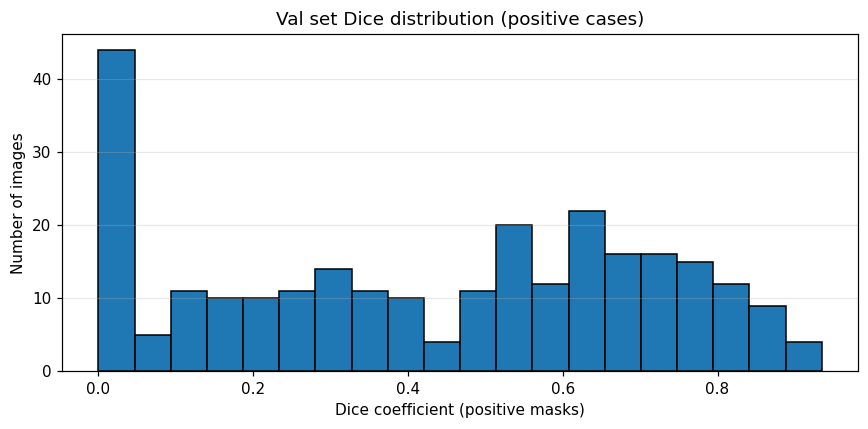

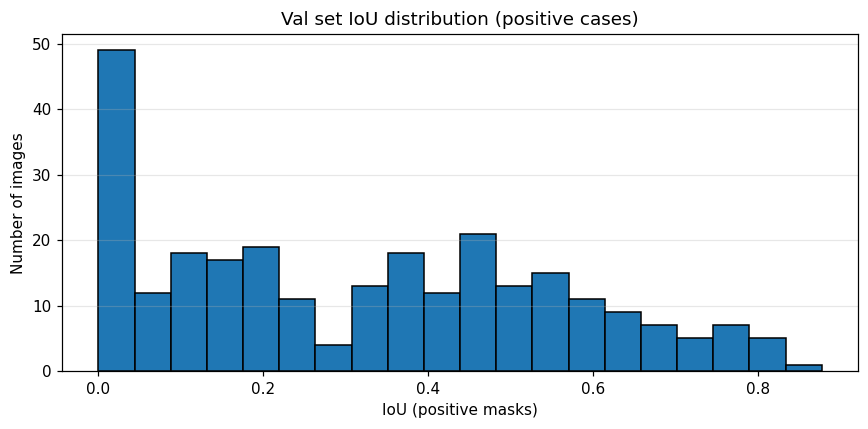

In [71]:
from tqdm.auto import tqdm
model.eval()

eval_val_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

ds_val_seg = PandasImageMaskDataset(val_df, mask_root=MASK_ROOT, joint_transform=eval_val_tfms)
dl_val_seg = DataLoader(ds_val_seg, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

all_dice_pos = []
all_iou_pos  = []

with torch.no_grad():
    for xb, yb, mb in tqdm(dl_val_seg, desc="Seg Eval (Val)"):
        xb = xb.to(device)          
        mb = mb.to(device)          # GT mask, [B,1,H,W], 0/1

        cls_logits, seg_logits = model(xb)   # seg_logits: [B,1,H,W]

        seg_probs = torch.sigmoid(seg_logits)
        seg_pred  = (seg_probs > 0.5).float()

        dice_batch, iou_batch = compute_dice_iou(seg_pred, mb) 
        pos_mask = (mb.view(mb.size(0), -1).sum(dim=1) > 0)

        if pos_mask.any():
            all_dice_pos.extend(dice_batch[pos_mask].cpu().numpy().tolist())
            all_iou_pos.extend(iou_batch[pos_mask].cpu().numpy().tolist())

all_dice_pos = np.array(all_dice_pos)
all_iou_pos  = np.array(all_iou_pos)

print(f"[Seg @ Val, positive masks only]")
print(f"Dice: mean={all_dice_pos.mean():.4f}, median={np.median(all_dice_pos):.4f}")
print(f"IoU : mean={all_iou_pos .mean():.4f}, median={np.median(all_iou_pos ):.4f}")
print(f"Num positive masks: {len(all_dice_pos)}")

# np.save(os.path.join(OUT_DIR, "val_seg_dice_pos.npy"), all_dice_pos)
# np.save(os.path.join(OUT_DIR, "val_seg_iou_pos.npy"),  all_iou_pos)

plt.figure(figsize=(8, 4))
plt.hist(all_dice_pos, bins=20, edgecolor="black")
plt.xlabel("Dice coefficient (positive masks)")
plt.ylabel("Number of images")
plt.title("Val set Dice distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "val_seg_dice_hist_pos.png"), dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(all_iou_pos, bins=20, edgecolor="black")
plt.xlabel("IoU (positive masks)")
plt.ylabel("Number of images")
plt.title("Val set IoU distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "val_seg_iou_hist_pos.png"), dpi=300)
plt.show()


## 19. Threshold tunning

In [72]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def sweep_thresholds(y_true, y_score, thresholds=None, sort_by="f1", verbose=True):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_score = np.asarray(y_score).ravel()

    if thresholds is None:
        thresholds = np.linspace(0.01, 0.95, 19)

    results = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)

        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")

        results.append({
            "threshold": t,
            "acc": acc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "spec": spec,
        })

    df_thr = pd.DataFrame(results)
    df_thr_sorted = df_thr.sort_values(sort_by, ascending=False).reset_index(drop=True)

    if verbose:
        print(f"\n=== Top 10 thresholds on val (sorted by {sort_by}) ===")
        tmp = df_thr_sorted.copy()
        for col in ["acc", "prec", "rec", "f1", "spec"]:
            tmp[col] = tmp[col] * 100.0
        print(tmp.head(10).to_string(
            index=False, 
            formatters={
                "threshold": "{:.3f}".format,
                "acc": "{:.3f}".format,
                "prec": "{:.3f}".format,
                "rec": "{:.3f}".format,
                "f1": "{:.3f}".format,
                "spec": "{:.3f}".format
            }
        ))

        best_row = df_thr_sorted.iloc[0]
        print("\nBest threshold on validation set (by {}):".format(sort_by))
        print(
            f"t = {best_row['threshold']:.3f}, "
            f"Acc={best_row['acc']*100:.3f}%, "
            f"Prec={best_row['prec']*100:.3f}%, "
            f"Rec={best_row['rec']*100:.3f}%, "
            f"F1={best_row['f1']*100:.3f}%, "
            f"Spec={best_row['spec']*100:.3f}%"
        )

    return df_thr_sorted


In [73]:
def plot_threshold_metrics(df_thr, out_dir, prefix="val_thr"):
    os.makedirs(out_dir, exist_ok=True)

    thr = df_thr["threshold"].values

    plt.figure(figsize=(6,4))
    for key, label in [
        ("acc",  "Acc"),
        ("f1",   "F1"),
        ("rec",  "Recall"),
        ("spec", "Specificity"),
    ]:
        if key in df_thr.columns:
            plt.plot(thr, df_thr[key].values * 100.0, marker="o", label=label)

    plt.xlabel("Threshold")
    plt.ylabel("Metric (%)")
    plt.title("Metrics vs Threshold (Validation)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_metrics_vs_threshold.png"), dpi=300)
    plt.show()

### 19.1 Find best threshold without calibration


=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.584 86.141 67.606 71.910 69.691 90.192
    0.532 83.237 58.760 81.648 68.339 83.689
    0.480 79.917 52.796 88.390 66.106 77.505
    0.637 85.560 71.233 58.427 64.198 93.284
    0.428 74.274 45.996 92.509 61.443 69.083
    0.376 67.718 40.287 94.757 56.536 60.021
    0.689 83.900 76.259 39.700 52.217 96.482
    0.323 60.664 35.645 96.255 52.024 50.533
    0.271 49.129 30.206 98.876 46.275 34.968
    0.219 37.344 26.078 99.625 41.336 19.616

Best threshold on validation set (by f1):
t = 0.584, Acc=86.141%, Prec=67.606%, Rec=71.910%, F1=69.691%, Spec=90.192%


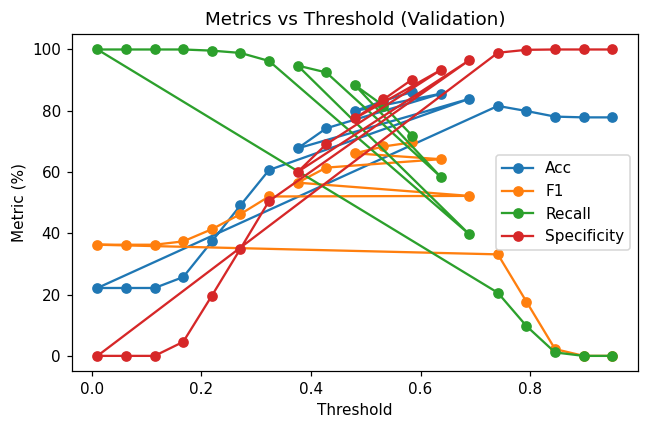


>>> The best threshold on validation set (noTTA): best_t_notta = 0.584
[Info] Saved best noTTA threshold to: ./Baseline+ECA(7000)_Output\best_threshold_noTTA.txt

=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.584 86.971 68.707 75.655 72.014 90.192
    0.532 85.145 62.291 83.521 71.360 85.608
    0.480 81.328 54.884 88.390 67.719 79.318
    0.637 85.975 72.685 58.801 65.010 93.710
    0.428 75.685 47.510 92.884 62.864 70.789
    0.376 69.461 41.762 95.880 58.182 61.940
    0.689 84.398 77.241 41.948 54.369 96.482
    0.323 59.668 35.302 98.502 51.976 48.614
    0.271 48.963 30.182 99.251 46.288 34.648
    0.219 37.095 26.002 99.625 41.240 19.296

Best threshold on validation set (by f1):
t = 0.584, Acc=86.971%, Prec=68.707%, Rec=75.655%, F1=72.014%, Spec=90.192%


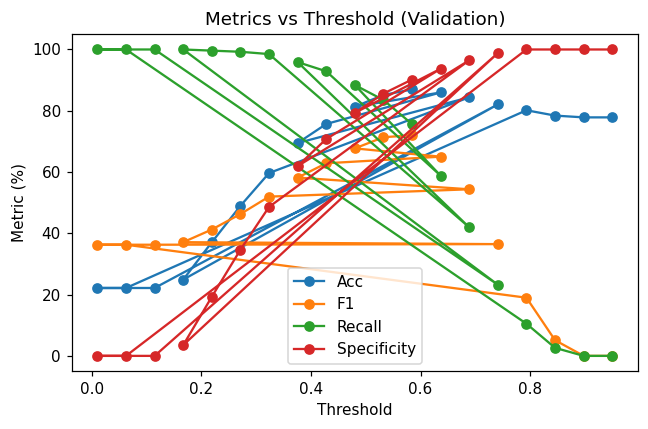


>>> The best threshold on validation set (TTA): best_t_tta = 0.584
[Info] Saved best TTA threshold to: ./Baseline+ECA(7000)_Output\best_threshold_TTA.txt

=== Summary: best thresholds on validation set ===
noTTA best_t = 0.584
TTA   best_t = 0.584


In [74]:
# ==========================
# 阈值扫描：noTTA
# ==========================
df_thr_val_notta = sweep_thresholds(
    yv_notta,
    sv_notta,
    sort_by="f1",
    verbose=True,
)
plot_threshold_metrics(
    df_thr_val_notta,
    OUT_DIR,
    prefix="val_thr_noTTA",
)

best_t_notta = float(df_thr_val_notta.iloc[0]["threshold"])
print(f"\n>>> The best threshold on validation set (noTTA): best_t_notta = {best_t_notta:.3f}")

thr_path_notta = os.path.join(OUT_DIR, "best_threshold_noTTA.txt")
with open(thr_path_notta, "w") as f:
    f.write(f"{best_t_notta:.6f}\n")
print(f"[Info] Saved best noTTA threshold to: {thr_path_notta}")


# ==========================
# 阈值扫描：TTA
# ==========================
df_thr_val_tta = sweep_thresholds(
    yv_tta,
    sv_tta,
    sort_by="f1",
    verbose=True,
)
plot_threshold_metrics(
    df_thr_val_tta,
    OUT_DIR,
    prefix="val_thr_TTA",
)

best_t_tta = float(df_thr_val_tta.iloc[0]["threshold"])
print(f"\n>>> The best threshold on validation set (TTA): best_t_tta = {best_t_tta:.3f}")

thr_path_tta = os.path.join(OUT_DIR, "best_threshold_TTA.txt")
with open(thr_path_tta, "w") as f:
    f.write(f"{best_t_tta:.6f}\n")
print(f"[Info] Saved best TTA threshold to: {thr_path_tta}")


# （可选）顺便打印一个对比，方便你写论文
print("\n=== Summary: best thresholds on validation set ===")
print(f"noTTA best_t = {best_t_notta:.3f}")
print(f"TTA   best_t = {best_t_tta:.3f}")


### 19.2 Re-evaluate using best threshold


[Best threshold model noTTA @ Test (t=0.584)]
Accuracy (%)        : 86.971
Precision (%)       : 69.366
Recall (%)          : 73.783
F1-Score (%)        : 71.506
Specificity (%)     : 90.725
ROC-AUC (%)         : 90.850
Precision-recall (%): 74.754

[Best threshold model noTTA @ Val (t=0.584)]
Accuracy (%)        : 86.141
Precision (%)       : 67.606
Recall (%)          : 71.910
F1-Score (%)        : 69.691
Specificity (%)     : 90.192
ROC-AUC (%)         : 89.959
Precision-recall (%): 72.442


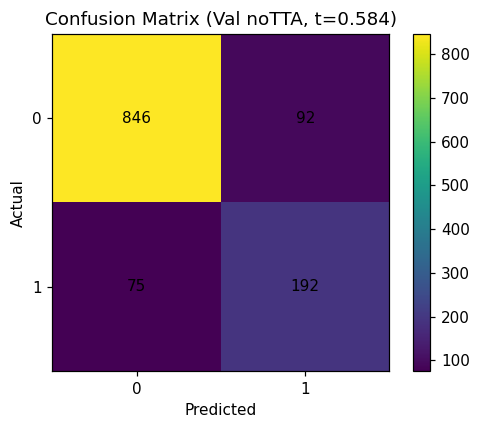

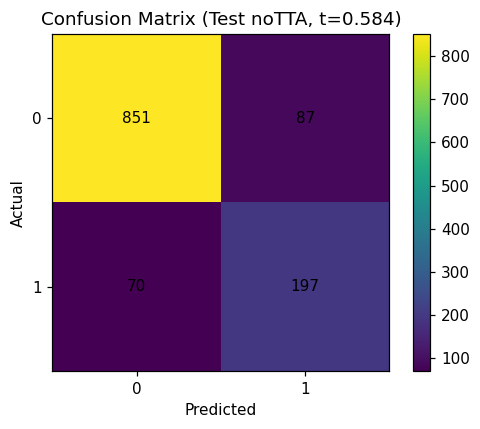


[Best threshold model TTA @ Test (t=0.584)]
Accuracy (%)        : 87.137
Precision (%)       : 70.438
Recall (%)          : 72.285
F1-Score (%)        : 71.349
Specificity (%)     : 91.365
ROC-AUC (%)         : 91.689
Precision-recall (%): 76.795

[Best threshold model TTA @ Val (t=0.584)]
Accuracy (%)        : 86.971
Precision (%)       : 68.707
Recall (%)          : 75.655
F1-Score (%)        : 72.014
Specificity (%)     : 90.192
ROC-AUC (%)         : 91.381
Precision-recall (%): 75.391


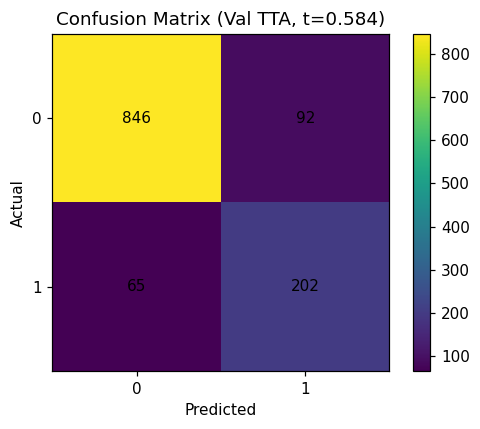

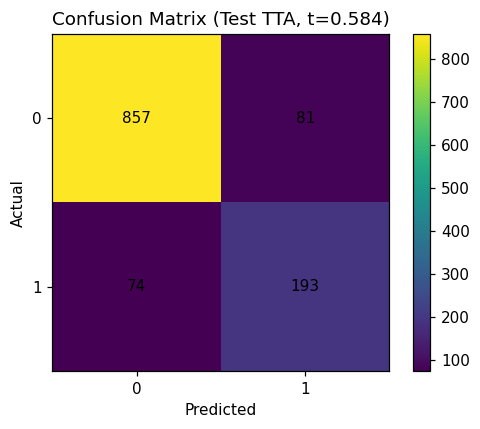


=== Summary: Val/Test @ best threshold (noTTA vs TTA) ===
Val  F1: noTTA = 69.691%,  TTA = 72.014%
Val  PR: noTTA = 72.442%,  TTA = 75.391%
Test F1: noTTA = 71.506%, TTA = 71.349%
Test PR: noTTA = 74.754%, TTA = 76.795%


In [75]:
# ==========================
# Best threshold 对比：noTTA vs TTA
# ==========================

# ---------- 1) noTTA：Val/Test @ best_t_notta ----------
yt_n = np.asarray(yt_notta).astype(int).ravel()
st_n = np.asarray(st_notta).ravel()

y_test_pred_notta = (st_n >= best_t_notta).astype(int)

test_acc_n  = accuracy_score(yt_n, y_test_pred_notta)
test_prec_n = precision_score(yt_n, y_test_pred_notta, zero_division=0)
test_rec_n  = recall_score(yt_n, y_test_pred_notta, zero_division=0)
test_f1_n   = f1_score(yt_n, y_test_pred_notta, zero_division=0)

cm_test_n = confusion_matrix(yt_n, y_test_pred_notta)
if cm_test_n.shape == (2, 2):
    tn, fp, fn, tp = cm_test_n.ravel()
    test_spec_n = tn / (tn + fp + 1e-8)
else:
    test_spec_n = float("nan")

test_roc_n = roc_auc_score(yt_n, st_n)
test_pr_n  = average_precision_score(yt_n, st_n)

print(f"\n[Best threshold model noTTA @ Test (t={best_t_notta:.3f})]")
print(f"Accuracy (%)        : {test_acc_n*100:.3f}")
print(f"Precision (%)       : {test_prec_n*100:.3f}")
print(f"Recall (%)          : {test_rec_n*100:.3f}")
print(f"F1-Score (%)        : {test_f1_n*100:.3f}")
print(f"Specificity (%)     : {test_spec_n*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc_n*100:.3f}")
print(f"Precision-recall (%): {test_pr_n*100:.3f}")

y_val_pred_notta = (np.asarray(sv_notta) >= best_t_notta).astype(int)
val_acc_n  = accuracy_score(yv_notta, y_val_pred_notta)
val_prec_n = precision_score(yv_notta, y_val_pred_notta, zero_division=0)
val_rec_n  = recall_score(yv_notta, y_val_pred_notta, zero_division=0)
val_f1_n   = f1_score(yv_notta, y_val_pred_notta, zero_division=0)

cm_val_n = confusion_matrix(yv_notta, y_val_pred_notta)
if cm_val_n.shape == (2, 2):
    tn, fp, fn, tp = cm_val_n.ravel()
    val_spec_n = tn / (tn + fp + 1e-8)
else:
    val_spec_n = float("nan")

val_roc_n = roc_auc_score(yv_notta, sv_notta)
val_pr_n  = average_precision_score(yv_notta, sv_notta)

print(f"\n[Best threshold model noTTA @ Val (t={best_t_notta:.3f})]")
print(f"Accuracy (%)        : {val_acc_n*100:.3f}")
print(f"Precision (%)       : {val_prec_n*100:.3f}")
print(f"Recall (%)          : {val_rec_n*100:.3f}")
print(f"F1-Score (%)        : {val_f1_n*100:.3f}")
print(f"Specificity (%)     : {val_spec_n*100:.3f}")
print(f"ROC-AUC (%)         : {val_roc_n*100:.3f}")
print(f"Precision-recall (%): {val_pr_n*100:.3f}")

plot_confusion_matrix(
    y_true=yv_notta,
    y_pred=y_val_pred_notta,
    out_path=os.path.join(OUT_DIR, f"confmat_val_best_t_notta_{best_t_notta:.3f}.png"),
    title=f"Confusion Matrix (Val noTTA, t={best_t_notta:.3f})"
)

plot_confusion_matrix(
    y_true=yt_n,
    y_pred=y_test_pred_notta,
    out_path=os.path.join(OUT_DIR, f"confmat_test_best_t_notta_{best_t_notta:.3f}.png"),
    title=f"Confusion Matrix (Test noTTA, t={best_t_notta:.3f})"
)


# ---------- 2) TTA：Val/Test @ best_t_tta ----------
yt_t = np.asarray(yt_tta).astype(int).ravel()
st_t = np.asarray(st_tta).ravel()

y_test_pred_tta = (st_t >= best_t_tta).astype(int)

test_acc_t  = accuracy_score(yt_t, y_test_pred_tta)
test_prec_t = precision_score(yt_t, y_test_pred_tta, zero_division=0)
test_rec_t  = recall_score(yt_t, y_test_pred_tta, zero_division=0)
test_f1_t   = f1_score(yt_t, y_test_pred_tta, zero_division=0)

cm_test_t = confusion_matrix(yt_t, y_test_pred_tta)
if cm_test_t.shape == (2, 2):
    tn, fp, fn, tp = cm_test_t.ravel()
    test_spec_t = tn / (tn + fp + 1e-8)
else:
    test_spec_t = float("nan")

test_roc_t = roc_auc_score(yt_t, st_t)
test_pr_t  = average_precision_score(yt_t, st_t)

print(f"\n[Best threshold model TTA @ Test (t={best_t_tta:.3f})]")
print(f"Accuracy (%)        : {test_acc_t*100:.3f}")
print(f"Precision (%)       : {test_prec_t*100:.3f}")
print(f"Recall (%)          : {test_rec_t*100:.3f}")
print(f"F1-Score (%)        : {test_f1_t*100:.3f}")
print(f"Specificity (%)     : {test_spec_t*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc_t*100:.3f}")
print(f"Precision-recall (%): {test_pr_t*100:.3f}")

y_val_pred_tta = (np.asarray(sv_tta) >= best_t_tta).astype(int)
val_acc_t  = accuracy_score(yv_tta, y_val_pred_tta)
val_prec_t = precision_score(yv_tta, y_val_pred_tta, zero_division=0)
val_rec_t  = recall_score(yv_tta, y_val_pred_tta, zero_division=0)
val_f1_t   = f1_score(yv_tta, y_val_pred_tta, zero_division=0)

cm_val_t = confusion_matrix(yv_tta, y_val_pred_tta)
if cm_val_t.shape == (2, 2):
    tn, fp, fn, tp = cm_val_t.ravel()
    val_spec_t = tn / (tn + fp + 1e-8)
else:
    val_spec_t = float("nan")

val_roc_t = roc_auc_score(yv_tta, sv_tta)
val_pr_t  = average_precision_score(yv_tta, sv_tta)

print(f"\n[Best threshold model TTA @ Val (t={best_t_tta:.3f})]")
print(f"Accuracy (%)        : {val_acc_t*100:.3f}")
print(f"Precision (%)       : {val_prec_t*100:.3f}")
print(f"Recall (%)          : {val_rec_t*100:.3f}")
print(f"F1-Score (%)        : {val_f1_t*100:.3f}")
print(f"Specificity (%)     : {val_spec_t*100:.3f}")
print(f"ROC-AUC (%)         : {val_roc_t*100:.3f}")
print(f"Precision-recall (%): {val_pr_t*100:.3f}")

plot_confusion_matrix(
    y_true=yv_tta,
    y_pred=y_val_pred_tta,
    out_path=os.path.join(OUT_DIR, f"confmat_val_best_t_tta_{best_t_tta:.3f}.png"),
    title=f"Confusion Matrix (Val TTA, t={best_t_tta:.3f})"
)

plot_confusion_matrix(
    y_true=yt_t,
    y_pred=y_test_pred_tta,
    out_path=os.path.join(OUT_DIR, f"confmat_test_best_t_tta_{best_t_tta:.3f}.png"),
    title=f"Confusion Matrix (Test TTA, t={best_t_tta:.3f})"
)


# ---------- 3) （可选）打印一个汇总对比，方便写论文 ----------
print("\n=== Summary: Val/Test @ best threshold (noTTA vs TTA) ===")
print(f"Val  F1: noTTA = {val_f1_n*100:.3f}%,  TTA = {val_f1_t*100:.3f}%")
print(f"Val  PR: noTTA = {val_pr_n*100:.3f}%,  TTA = {val_pr_t*100:.3f}%")
print(f"Test F1: noTTA = {test_f1_n*100:.3f}%, TTA = {test_f1_t*100:.3f}%")
print(f"Test PR: noTTA = {test_pr_n*100:.3f}%, TTA = {test_pr_t*100:.3f}%")


### 19.1.2 Train/Val/Test Comparison after threshold tunning

[Debug] metrics_df_overall columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
                    Split     acc    prec     rec      f1    spec  roc_auc  \
0      Train (noTTA @0.5)  90.529  87.143  95.086  90.941  85.971   97.044   
1      Val   (noTTA @0.5)  81.494  55.164  88.015  67.821  79.638   89.959   
2      Test  (noTTA @0.5)  81.577  55.639  83.146  66.667  81.130   90.850   
3  Val   (noTTA @t=0.584)  86.141  67.606  71.910  69.691  90.192   89.959   
4  Test  (noTTA @t=0.584)  86.971  69.366  73.783  71.506  90.725   90.850   

   pr_auc  
0  96.909  
1  72.442  
2  74.754  
3  72.442  
4  74.754  
[Info] Saved overall metrics summary to: ./Baseline+ECA(7000)_Output\metrics_summary_overall_notta_bestt.csv


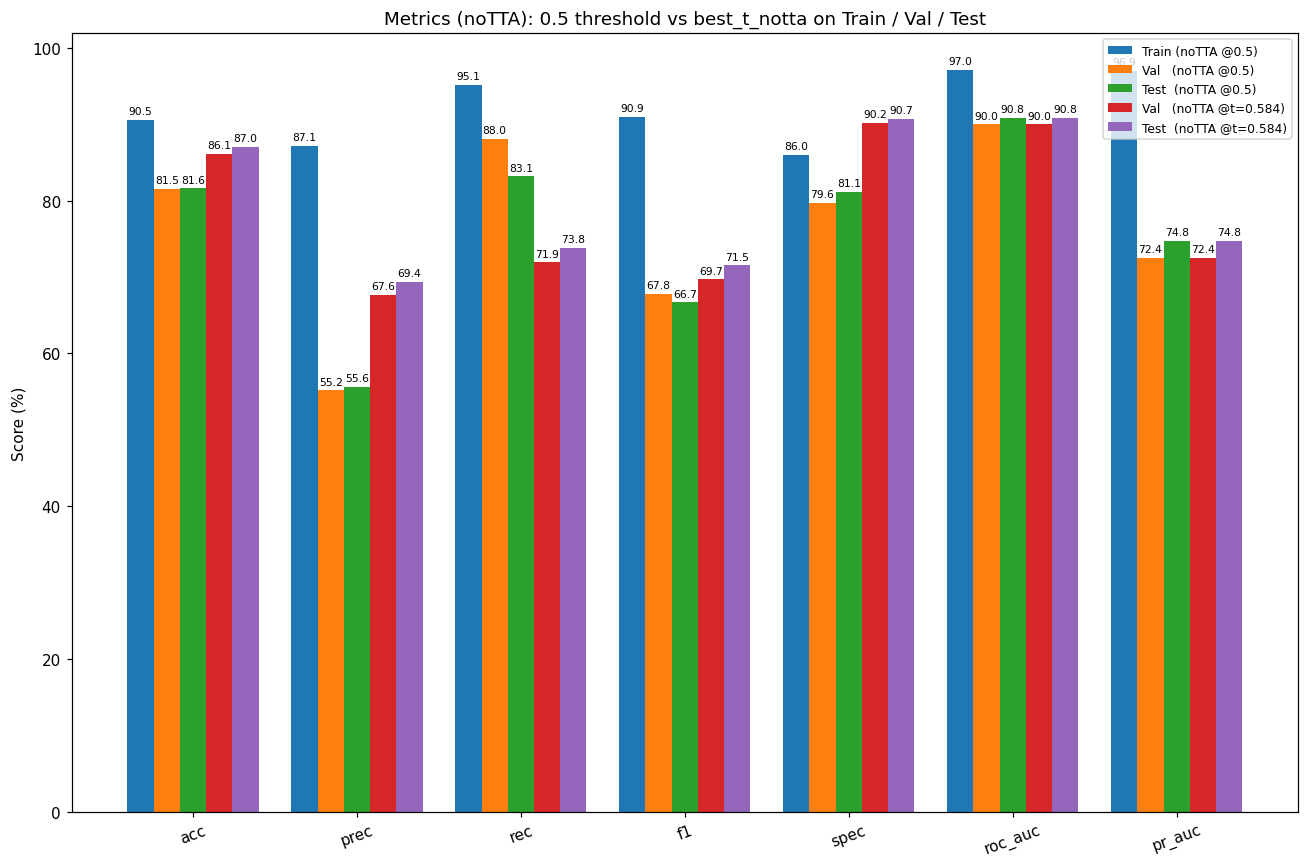

[Debug] metrics_df_val columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
                  Split     acc    prec     rec      f1    spec  roc_auc  \
0      Val (noTTA @0.5)  81.494  55.164  88.015  67.821  79.638   89.959   
1  Val (noTTA @t=0.584)  86.141  67.606  71.910  69.691  90.192   89.959   
2        Val (TTA @0.5)  83.237  58.186  86.517  69.578  82.303   91.381   
3    Val (TTA @t=0.584)  86.971  68.707  75.655  72.014  90.192   91.381   

   pr_auc  
0  72.442  
1  72.442  
2  75.391  
3  75.391  
[Info] Saved val metrics summary to: ./Baseline+ECA(7000)_Output\metrics_summary_val_notta_tta_bestt.csv


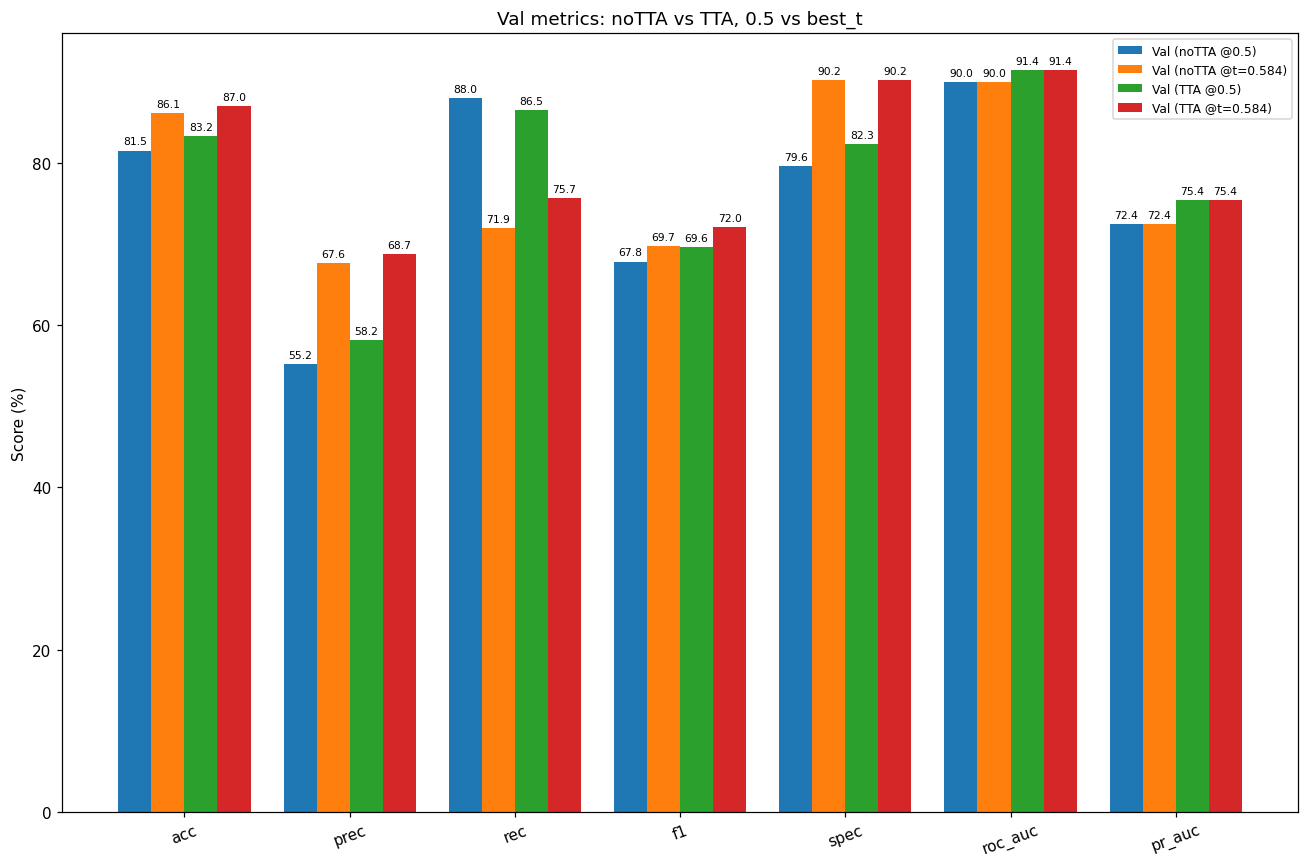

[Debug] metrics_df_test columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
                   Split     acc    prec     rec      f1    spec  roc_auc  \
0      Test (noTTA @0.5)  81.577  55.639  83.146  66.667  81.130   90.850   
1  Test (noTTA @t=0.584)  86.971  69.366  73.783  71.506  90.725   90.850   
2        Test (TTA @0.5)  82.822  57.463  86.517  69.058  81.770   91.689   
3    Test (TTA @t=0.584)  87.137  70.438  72.285  71.349  91.365   91.689   

   pr_auc  
0  74.754  
1  74.754  
2  76.795  
3  76.795  
[Info] Saved test metrics summary to: ./Baseline+ECA(7000)_Output\metrics_summary_test_notta_tta_bestt.csv


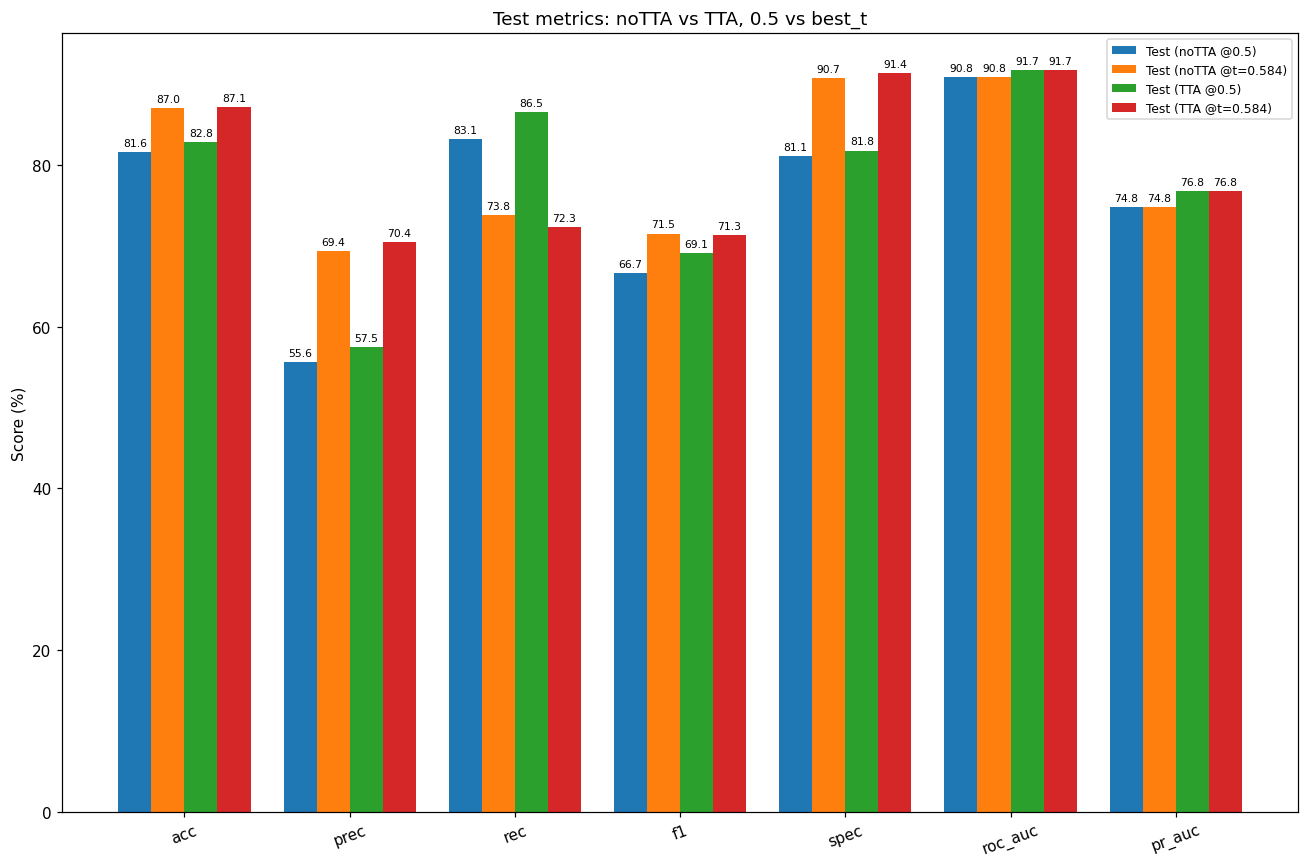

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# noTTA @ best_t_notta
val_pct_best_notta = {
    "acc":     round(val_acc_n  * 100, 3),
    "prec":    round(val_prec_n * 100, 3),
    "rec":     round(val_rec_n  * 100, 3),
    "f1":      round(val_f1_n   * 100, 3),
    "spec":    round(val_spec_n * 100, 3),
    "roc_auc": round(val_roc_n  * 100, 3),
    "pr_auc":  round(val_pr_n   * 100, 3),
}

test_pct_best_notta = {
    "acc":     round(test_acc_n  * 100, 3),
    "prec":    round(test_prec_n * 100, 3),
    "rec":     round(test_rec_n  * 100, 3),
    "f1":      round(test_f1_n   * 100, 3),
    "spec":    round(test_spec_n * 100, 3),
    "roc_auc": round(test_roc_n  * 100, 3),
    "pr_auc":  round(test_pr_n   * 100, 3),
}

# TTA @ best_t_tta
val_pct_best_tta = {
    "acc":     round(val_acc_t  * 100, 3),
    "prec":    round(val_prec_t * 100, 3),
    "rec":     round(val_rec_t  * 100, 3),
    "f1":      round(val_f1_t   * 100, 3),
    "spec":    round(val_spec_t * 100, 3),
    "roc_auc": round(val_roc_t  * 100, 3),
    "pr_auc":  round(val_pr_t   * 100, 3),
}

test_pct_best_tta = {
    "acc":     round(test_acc_t  * 100, 3),
    "prec":    round(test_prec_t * 100, 3),
    "rec":     round(test_rec_t  * 100, 3),
    "f1":      round(test_f1_t   * 100, 3),
    "spec":    round(test_spec_t * 100, 3),
    "roc_auc": round(test_roc_t  * 100, 3),
    "pr_auc":  round(test_pr_t   * 100, 3),
}

rows_overall = [
    {"Split": "Train (noTTA @0.5)", **train_pct},
    {"Split": "Val   (noTTA @0.5)", **val_pct},
    {"Split": "Test  (noTTA @0.5)", **test_pct},
    {"Split": f"Val   (noTTA @t={best_t_notta:.3f})",  **val_pct_best_notta},
    {"Split": f"Test  (noTTA @t={best_t_notta:.3f})", **test_pct_best_notta},
]

metrics_df_overall = pd.DataFrame(rows_overall)
metric_cols_overall = [c for c in metrics_df_overall.columns if c != "Split"]
metrics_df_overall = metrics_df_overall[["Split"] + metric_cols_overall]

print("[Debug] metrics_df_overall columns:", list(metrics_df_overall.columns))
print(metrics_df_overall)

metrics_csv_path_overall = os.path.join(OUT_DIR, "metrics_summary_overall_notta_bestt.csv")
metrics_df_overall.to_csv(metrics_csv_path_overall, index=False)
print(f"[Info] Saved overall metrics summary to: {metrics_csv_path_overall}")

x = np.arange(len(metric_cols_overall))
n_splits_overall = len(metrics_df_overall)
width = 0.8 / n_splits_overall

plt.figure(figsize=(12, 8))
for i, split in enumerate(metrics_df_overall["Split"]):
    values = metrics_df_overall.loc[i, metric_cols_overall].values.astype(float)
    offset = (i - (n_splits_overall - 1) / 2) * width
    plt.bar(x + offset, values, width, label=split)
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=7)

xtick_labels_overall = [c.replace("(%)", "").replace("%", "").strip()
                        for c in metric_cols_overall]
plt.xticks(x, xtick_labels_overall, rotation=20)
plt.ylabel("Score (%)")
plt.title("Metrics (noTTA): 0.5 threshold vs best_t_notta on Train / Val / Test")
plt.legend(fontsize=8)
plt.tight_layout()

bar_fig_path_overall = os.path.join(OUT_DIR, "metrics_bar_overall_notta_bestt.png")
plt.savefig(bar_fig_path_overall, dpi=300)
plt.show()

rows_val = [
    {"Split": "Val (noTTA @0.5)",            **val_pct},
    {"Split": f"Val (noTTA @t={best_t_notta:.3f})", **val_pct_best_notta},
    {"Split": "Val (TTA @0.5)",              **val_pct_TTA},
    {"Split": f"Val (TTA @t={best_t_tta:.3f})",     **val_pct_best_tta},
]

metrics_df_val = pd.DataFrame(rows_val)
metric_cols_val = [c for c in metrics_df_val.columns if c != "Split"]
metrics_df_val = metrics_df_val[["Split"] + metric_cols_val]

print("[Debug] metrics_df_val columns:", list(metrics_df_val.columns))
print(metrics_df_val)

metrics_csv_path_val = os.path.join(OUT_DIR, "metrics_summary_val_notta_tta_bestt.csv")
metrics_df_val.to_csv(metrics_csv_path_val, index=False)
print(f"[Info] Saved val metrics summary to: {metrics_csv_path_val}")

x = np.arange(len(metric_cols_val))
n_splits_val = len(metrics_df_val)
width = 0.8 / n_splits_val

plt.figure(figsize=(12, 8))
for i, split in enumerate(metrics_df_val["Split"]):
    values = metrics_df_val.loc[i, metric_cols_val].values.astype(float)
    offset = (i - (n_splits_val - 1) / 2) * width
    plt.bar(x + offset, values, width, label=split)
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=7)

xtick_labels_val = [c.replace("(%)", "").replace("%", "").strip()
                    for c in metric_cols_val]
plt.xticks(x, xtick_labels_val, rotation=20)
plt.ylabel("Score (%)")
plt.title("Val metrics: noTTA vs TTA, 0.5 vs best_t")
plt.legend(fontsize=8)
plt.tight_layout()

bar_fig_path_val = os.path.join(OUT_DIR, "metrics_bar_val_notta_tta_bestt.png")
plt.savefig(bar_fig_path_val, dpi=300)
plt.show()

rows_test = [
    {"Split": "Test (noTTA @0.5)",            **test_pct},
    {"Split": f"Test (noTTA @t={best_t_notta:.3f})", **test_pct_best_notta},
    {"Split": "Test (TTA @0.5)",              **test_pct_TTA},
    {"Split": f"Test (TTA @t={best_t_tta:.3f})",     **test_pct_best_tta},
]

metrics_df_test = pd.DataFrame(rows_test)
metric_cols_test = [c for c in metrics_df_test.columns if c != "Split"]
metrics_df_test = metrics_df_test[["Split"] + metric_cols_test]

print("[Debug] metrics_df_test columns:", list(metrics_df_test.columns))
print(metrics_df_test)

metrics_csv_path_test = os.path.join(OUT_DIR, "metrics_summary_test_notta_tta_bestt.csv")
metrics_df_test.to_csv(metrics_csv_path_test, index=False)
print(f"[Info] Saved test metrics summary to: {metrics_csv_path_test}")

x = np.arange(len(metric_cols_test))
n_splits_test = len(metrics_df_test)
width = 0.8 / n_splits_test

plt.figure(figsize=(12, 8))
for i, split in enumerate(metrics_df_test["Split"]):
    values = metrics_df_test.loc[i, metric_cols_test].values.astype(float)
    offset = (i - (n_splits_test - 1) / 2) * width
    plt.bar(x + offset, values, width, label=split)
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=7)

xtick_labels_test = [c.replace("(%)", "").replace("%", "").strip()
                     for c in metric_cols_test]
plt.xticks(x, xtick_labels_test, rotation=20)
plt.ylabel("Score (%)")
plt.title("Test metrics: noTTA vs TTA, 0.5 vs best_t")
plt.legend(fontsize=8)
plt.tight_layout()

bar_fig_path_test = os.path.join(OUT_DIR, "metrics_bar_test_notta_tta_bestt.png")
plt.savefig(bar_fig_path_test, dpi=300)
plt.show()

### 19.2 Find best threshold after calibration
Compare noTTA vs TTA threshold sweep AFTER calibration


=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.584 85.975 66.667 73.408 69.875 89.552
    0.532 83.237 58.621 82.772 68.634 83.369
    0.480 80.000 52.915 88.390 66.199 77.612
    0.637 85.062 68.511 60.300 64.143 92.111
    0.428 74.606 46.314 91.760 61.558 69.723
    0.689 84.979 76.875 46.067 57.611 96.055
    0.376 68.714 41.042 94.382 57.208 61.407
    0.323 61.743 36.299 96.255 52.718 51.919
    0.271 51.618 31.146 97.753 47.240 38.486
    0.219 40.830 27.198 99.625 42.731 24.094

Best threshold on validation set (by f1):
t = 0.584, Acc=85.975%, Prec=66.667%, Rec=73.408%, F1=69.875%, Spec=89.552%


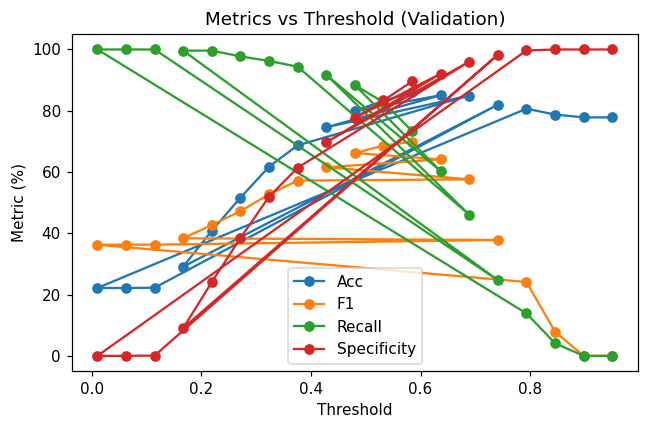


>>> [noTTA] Best threshold on validation set AFTER calibration: best_t_notta_cal = 0.584
[Info] Saved calibrated best threshold (noTTA) to: ./Baseline+ECA(7000)_Output\best_threshold_notta_calibrated.txt

[noTTA Val @ T_opt + best_t_notta_cal]
Accuracy (%)        : 85.975
Precision (%)       : 66.667
Recall (%)          : 73.408
F1-Score (%)        : 69.875
Specificity (%)     : 89.552
ROC-AUC (%)         : 89.959
Precision-recall (%): 72.442

[noTTA Test @ T_opt + best_t_notta_cal]
Accuracy (%)        : 86.556
Precision (%)       : 67.918
Recall (%)          : 74.532
F1-Score (%)        : 71.071
Specificity (%)     : 89.979
ROC-AUC (%)         : 90.850
Precision-recall (%): 74.754


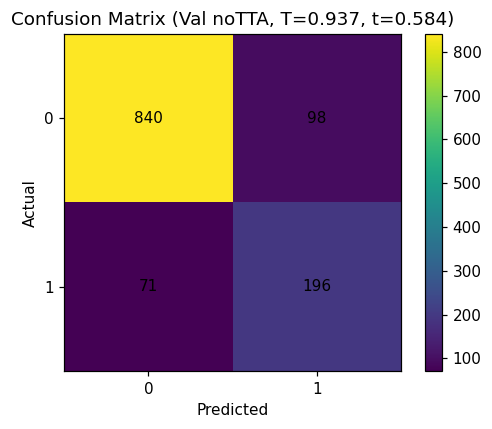

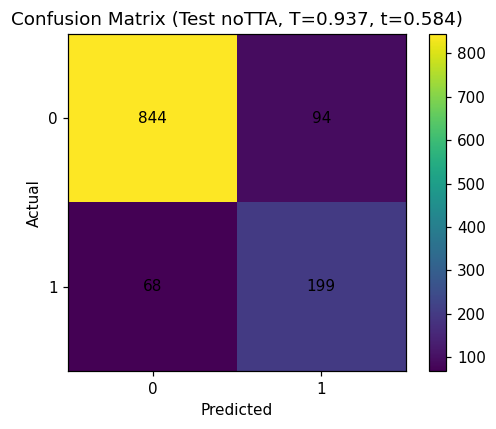


=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.584 87.054 68.317 77.528 72.632 89.765
    0.532 85.228 62.396 83.895 71.565 85.608
    0.480 81.577 55.269 88.390 68.012 79.638
    0.637 86.390 72.889 61.423 66.667 93.497
    0.428 76.515 48.438 92.884 63.671 71.855
    0.376 70.456 42.571 95.506 58.891 63.326
    0.689 85.145 77.848 46.067 57.882 96.269
    0.323 62.324 36.850 98.127 53.579 52.132
    0.271 50.539 30.805 98.876 46.975 36.780
    0.219 40.083 26.950 99.625 42.424 23.134

Best threshold on validation set (by f1):
t = 0.584, Acc=87.054%, Prec=68.317%, Rec=77.528%, F1=72.632%, Spec=89.765%


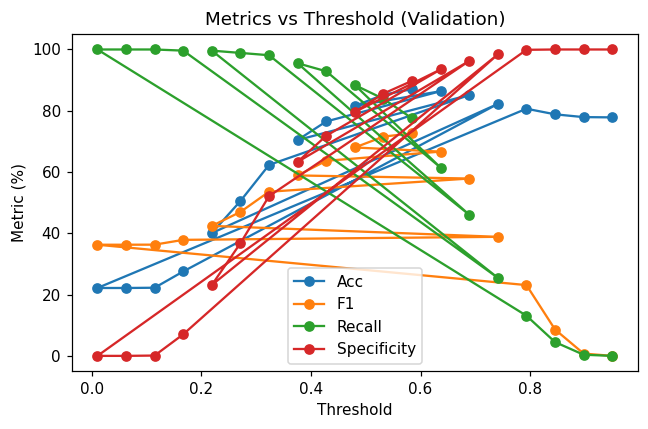


>>> [TTA] Best threshold on validation set AFTER calibration: best_t_tta_cal = 0.584
[Info] Saved calibrated best threshold (TTA) to: ./Baseline+ECA(7000)_Output\best_threshold_tta_calibrated.txt

[TTA Val @ T_opt + best_t_tta_cal]
Accuracy (%)        : 87.054
Precision (%)       : 68.317
Recall (%)          : 77.528
F1-Score (%)        : 72.632
Specificity (%)     : 89.765
ROC-AUC (%)         : 91.381
Precision-recall (%): 75.391

[TTA Test @ T_opt + best_t_tta_cal]
Accuracy (%)        : 87.054
Precision (%)       : 69.611
Recall (%)          : 73.783
F1-Score (%)        : 71.636
Specificity (%)     : 90.832
ROC-AUC (%)         : 91.689
Precision-recall (%): 76.795


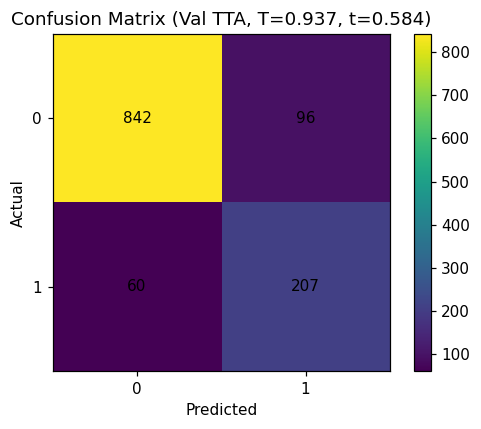

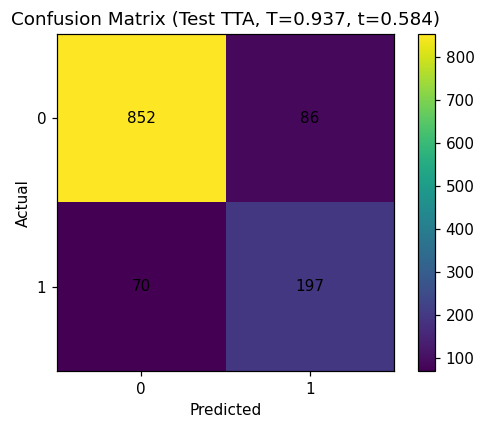

In [77]:
# ============================================
# 19.2 Find best threshold after calibration
# Compare noTTA vs TTA threshold sweep AFTER calibration
# ============================================

df_thr_val_notta_cal = sweep_thresholds(
    yv_cal_notta,
    sv_cal_notta,
    sort_by="f1",
    verbose=True,
)
plot_threshold_metrics(
    df_thr_val_notta_cal,
    OUT_DIR,
    prefix="val_thr_notta_calibrated",
)

best_t_notta_cal = float(df_thr_val_notta_cal.iloc[0]["threshold"])
print(f"\n>>> [noTTA] Best threshold on validation set AFTER calibration: best_t_notta_cal = {best_t_notta_cal:.3f}")

thr_path_notta_cal = os.path.join(OUT_DIR, "best_threshold_notta_calibrated.txt")
with open(thr_path_notta_cal, "w") as f:
    f.write(f"{best_t_notta_cal:.6f}\n")
print(f"[Info] Saved calibrated best threshold (noTTA) to: {thr_path_notta_cal}")

yv_arr_n = np.asarray(yv_cal_notta).astype(int).ravel()
sv_arr_n = np.asarray(sv_cal_notta).ravel()

yt_arr_n = np.asarray(yt_cal_notta).astype(int).ravel()
st_arr_n = np.asarray(st_cal_notta).ravel()

# Using best_t_notta_cal to get predictions
y_val_pred_notta_cal_t  = (sv_arr_n >= best_t_notta_cal).astype(int)
y_test_pred_notta_cal_t = (st_arr_n >= best_t_notta_cal).astype(int)

# Val metrics @ T_opt + best_t_notta_cal
val_acc_notta_cal   = accuracy_score(yv_arr_n, y_val_pred_notta_cal_t)
val_prec_notta_cal  = precision_score(yv_arr_n, y_val_pred_notta_cal_t, zero_division=0)
val_rec_notta_cal   = recall_score(yv_arr_n, y_val_pred_notta_cal_t, zero_division=0)
val_f1_notta_cal    = f1_score(yv_arr_n, y_val_pred_notta_cal_t, zero_division=0)

cm_val_notta_cal = confusion_matrix(yv_arr_n, y_val_pred_notta_cal_t)
if cm_val_notta_cal.shape == (2, 2):
    tn, fp, fn, tp = cm_val_notta_cal.ravel()
    val_spec_notta_cal = tn / (tn + fp + 1e-8)
else:
    val_spec_notta_cal = float("nan")

val_roc_notta_cal = roc_auc_score(yv_arr_n, sv_arr_n)
val_pr_notta_cal  = average_precision_score(yv_arr_n, sv_arr_n)

# Test metrics @ T_opt + best_t_notta_cal
test_acc_notta_cal  = accuracy_score(yt_arr_n, y_test_pred_notta_cal_t)
test_prec_notta_cal = precision_score(yt_arr_n, y_test_pred_notta_cal_t, zero_division=0)
test_rec_notta_cal  = recall_score(yt_arr_n, y_test_pred_notta_cal_t, zero_division=0)
test_f1_notta_cal   = f1_score(yt_arr_n, y_test_pred_notta_cal_t, zero_division=0)

cm_test_notta_cal = confusion_matrix(yt_arr_n, y_test_pred_notta_cal_t)
if cm_test_notta_cal.shape == (2, 2):
    tn, fp, fn, tp = cm_test_notta_cal.ravel()
    test_spec_notta_cal = tn / (tn + fp + 1e-8)
else:
    test_spec_notta_cal = float("nan")

test_roc_notta_cal = roc_auc_score(yt_arr_n, st_arr_n)
test_pr_notta_cal  = average_precision_score(yt_arr_n, st_arr_n)

print("\n[noTTA Val @ T_opt + best_t_notta_cal]")
print(f"Accuracy (%)        : {val_acc_notta_cal*100:.3f}")
print(f"Precision (%)       : {val_prec_notta_cal*100:.3f}")
print(f"Recall (%)          : {val_rec_notta_cal*100:.3f}")
print(f"F1-Score (%)        : {val_f1_notta_cal*100:.3f}")
print(f"Specificity (%)     : {val_spec_notta_cal*100:.3f}")
print(f"ROC-AUC (%)         : {val_roc_notta_cal*100:.3f}")
print(f"Precision-recall (%): {val_pr_notta_cal*100:.3f}")

print("\n[noTTA Test @ T_opt + best_t_notta_cal]")
print(f"Accuracy (%)        : {test_acc_notta_cal*100:.3f}")
print(f"Precision (%)       : {test_prec_notta_cal*100:.3f}")
print(f"Recall (%)          : {test_rec_notta_cal*100:.3f}")
print(f"F1-Score (%)        : {test_f1_notta_cal*100:.3f}")
print(f"Specificity (%)     : {test_spec_notta_cal*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc_notta_cal*100:.3f}")
print(f"Precision-recall (%): {test_pr_notta_cal*100:.3f}")

# CM（noTTA）
plot_confusion_matrix(
    y_true=yv_arr_n,
    y_pred=y_val_pred_notta_cal_t,
    out_path=os.path.join(OUT_DIR, f"confmat_val_notta_T{T_opt:.3f}_t{best_t_notta_cal:.3f}.png"),
    title=f"Confusion Matrix (Val noTTA, T={T_opt:.3f}, t={best_t_notta_cal:.3f})"
)

plot_confusion_matrix(
    y_true=yt_arr_n,
    y_pred=y_test_pred_notta_cal_t,
    out_path=os.path.join(OUT_DIR, f"confmat_test_notta_T{T_opt:.3f}_t{best_t_notta_cal:.3f}.png"),
    title=f"Confusion Matrix (Test noTTA, T={T_opt:.3f}, t={best_t_notta_cal:.3f})"
)

df_thr_val_tta_cal = sweep_thresholds(
    yv_tta,
    sv_val_tta_cal, 
    sort_by="f1",
    verbose=True,
)
plot_threshold_metrics(
    df_thr_val_tta_cal,
    OUT_DIR,
    prefix="val_thr_tta_calibrated",
)

best_t_tta_cal = float(df_thr_val_tta_cal.iloc[0]["threshold"])
print(f"\n>>> [TTA] Best threshold on validation set AFTER calibration: best_t_tta_cal = {best_t_tta_cal:.3f}")

thr_path_tta_cal = os.path.join(OUT_DIR, "best_threshold_tta_calibrated.txt")
with open(thr_path_tta_cal, "w") as f:
    f.write(f"{best_t_tta_cal:.6f}\n")
print(f"[Info] Saved calibrated best threshold (TTA) to: {thr_path_tta_cal}")

yv_arr_t = np.asarray(yv_tta).astype(int).ravel()
sv_arr_t = np.asarray(sv_val_tta_cal).ravel()

yt_arr_t = np.asarray(yt_tta).astype(int).ravel()
st_arr_t = np.asarray(st_test_tta_cal).ravel()

y_val_pred_tta_cal_t  = (sv_arr_t >= best_t_tta_cal).astype(int)
y_test_pred_tta_cal_t = (st_arr_t >= best_t_tta_cal).astype(int)

# Val metrics @ T_opt + best_t_tta_cal
val_acc_tta_cal   = accuracy_score(yv_arr_t, y_val_pred_tta_cal_t)
val_prec_tta_cal  = precision_score(yv_arr_t, y_val_pred_tta_cal_t, zero_division=0)
val_rec_tta_cal   = recall_score(yv_arr_t, y_val_pred_tta_cal_t, zero_division=0)
val_f1_tta_cal    = f1_score(yv_arr_t, y_val_pred_tta_cal_t, zero_division=0)

cm_val_tta_cal = confusion_matrix(yv_arr_t, y_val_pred_tta_cal_t)
if cm_val_tta_cal.shape == (2, 2):
    tn, fp, fn, tp = cm_val_tta_cal.ravel()
    val_spec_tta_cal = tn / (tn + fp + 1e-8)
else:
    val_spec_tta_cal = float("nan")

val_roc_tta_cal = roc_auc_score(yv_arr_t, sv_arr_t)
val_pr_tta_cal  = average_precision_score(yv_arr_t, sv_arr_t)

# Test metrics @ T_opt + best_t_tta_cal
test_acc_tta_cal  = accuracy_score(yt_arr_t, y_test_pred_tta_cal_t)
test_prec_tta_cal = precision_score(yt_arr_t, y_test_pred_tta_cal_t, zero_division=0)
test_rec_tta_cal  = recall_score(yt_arr_t, y_test_pred_tta_cal_t, zero_division=0)
test_f1_tta_cal   = f1_score(yt_arr_t, y_test_pred_tta_cal_t, zero_division=0)

cm_test_tta_cal = confusion_matrix(yt_arr_t, y_test_pred_tta_cal_t)
if cm_test_tta_cal.shape == (2, 2):
    tn, fp, fn, tp = cm_test_tta_cal.ravel()
    test_spec_tta_cal = tn / (tn + fp + 1e-8)
else:
    test_spec_tta_cal = float("nan")

test_roc_tta_cal = roc_auc_score(yt_arr_t, st_arr_t)
test_pr_tta_cal  = average_precision_score(yt_arr_t, st_arr_t)

print("\n[TTA Val @ T_opt + best_t_tta_cal]")
print(f"Accuracy (%)        : {val_acc_tta_cal*100:.3f}")
print(f"Precision (%)       : {val_prec_tta_cal*100:.3f}")
print(f"Recall (%)          : {val_rec_tta_cal*100:.3f}")
print(f"F1-Score (%)        : {val_f1_tta_cal*100:.3f}")
print(f"Specificity (%)     : {val_spec_tta_cal*100:.3f}")
print(f"ROC-AUC (%)         : {val_roc_tta_cal*100:.3f}")
print(f"Precision-recall (%): {val_pr_tta_cal*100:.3f}")

print("\n[TTA Test @ T_opt + best_t_tta_cal]")
print(f"Accuracy (%)        : {test_acc_tta_cal*100:.3f}")
print(f"Precision (%)       : {test_prec_tta_cal*100:.3f}")
print(f"Recall (%)          : {test_rec_tta_cal*100:.3f}")
print(f"F1-Score (%)        : {test_f1_tta_cal*100:.3f}")
print(f"Specificity (%)     : {test_spec_tta_cal*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc_tta_cal*100:.3f}")
print(f"Precision-recall (%): {test_pr_tta_cal*100:.3f}")

# CM（TTA）
plot_confusion_matrix(
    y_true=yv_arr_t,
    y_pred=y_val_pred_tta_cal_t,
    out_path=os.path.join(OUT_DIR, f"confmat_val_tta_T{T_opt:.3f}_t{best_t_tta_cal:.3f}.png"),
    title=f"Confusion Matrix (Val TTA, T={T_opt:.3f}, t={best_t_tta_cal:.3f})"
)

plot_confusion_matrix(
    y_true=yt_arr_t,
    y_pred=y_test_pred_tta_cal_t,
    out_path=os.path.join(OUT_DIR, f"confmat_test_tta_T{T_opt:.3f}_t{best_t_tta_cal:.3f}.png"),
    title=f"Confusion Matrix (Test TTA, T={T_opt:.3f}, t={best_t_tta_cal:.3f})"
)


[Debug] metrics_df_val columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
                        Split     acc    prec     rec      f1    spec  \
0  Val (noTTA Raw,   t=0.584)  86.141  67.606  71.910  69.691  90.192   
1  Val (noTTA Calib, t=0.584)  85.975  66.667  73.408  69.875  89.552   
2  Val (TTA Raw,     t=0.584)  86.971  68.707  75.655  72.014  90.192   
3  Val (TTA Calib,   t=0.584)  87.054  68.317  77.528  72.632  89.765   

   roc_auc  pr_auc  
0   89.959  72.442  
1   89.959  72.442  
2   91.381  75.391  
3   91.381  75.391  
[Info] Saved VAL metrics summary to: ./Baseline+ECA(7000)_Output\metrics_summary_val_notta_tta_raw_vs_calibrated_bestt.csv


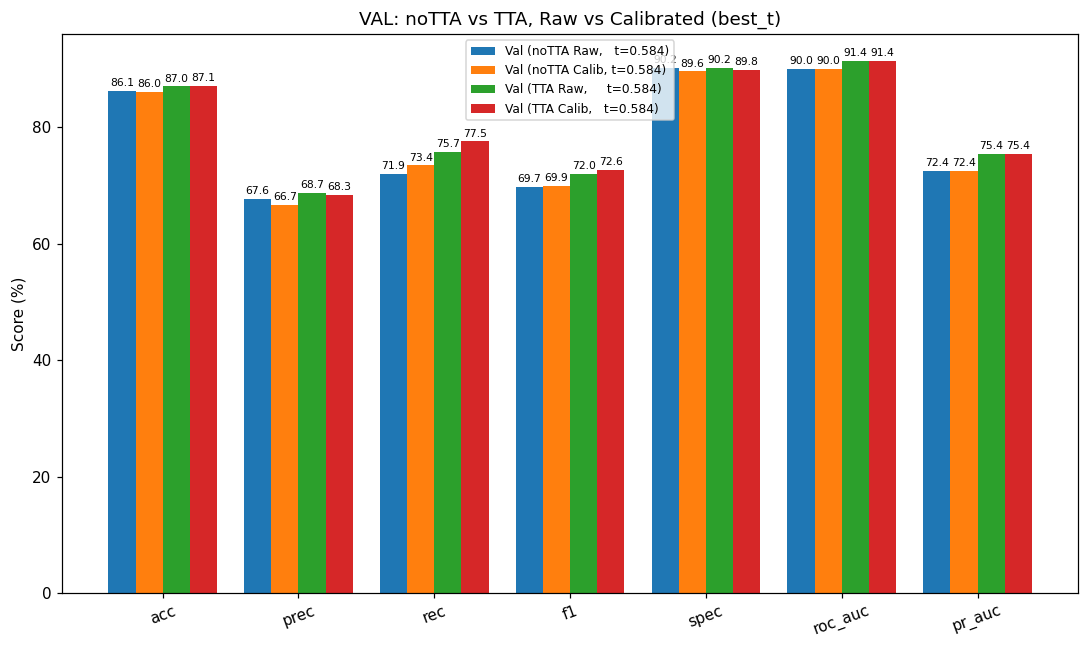

[Debug] metrics_df_test columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
                         Split     acc    prec     rec      f1    spec  \
0  Test (noTTA Raw,   t=0.584)  86.971  69.366  73.783  71.506  90.725   
1  Test (noTTA Calib, t=0.584)  86.556  67.918  74.532  71.071  89.979   
2  Test (TTA Raw,     t=0.584)  87.137  70.438  72.285  71.349  91.365   
3  Test (TTA Calib,   t=0.584)  87.054  69.611  73.783  71.636  90.832   

   roc_auc  pr_auc  
0   90.850  74.754  
1   90.850  74.754  
2   91.689  76.795  
3   91.689  76.795  
[Info] Saved TEST metrics summary to: ./Baseline+ECA(7000)_Output\metrics_summary_test_notta_tta_raw_vs_calibrated_bestt.csv


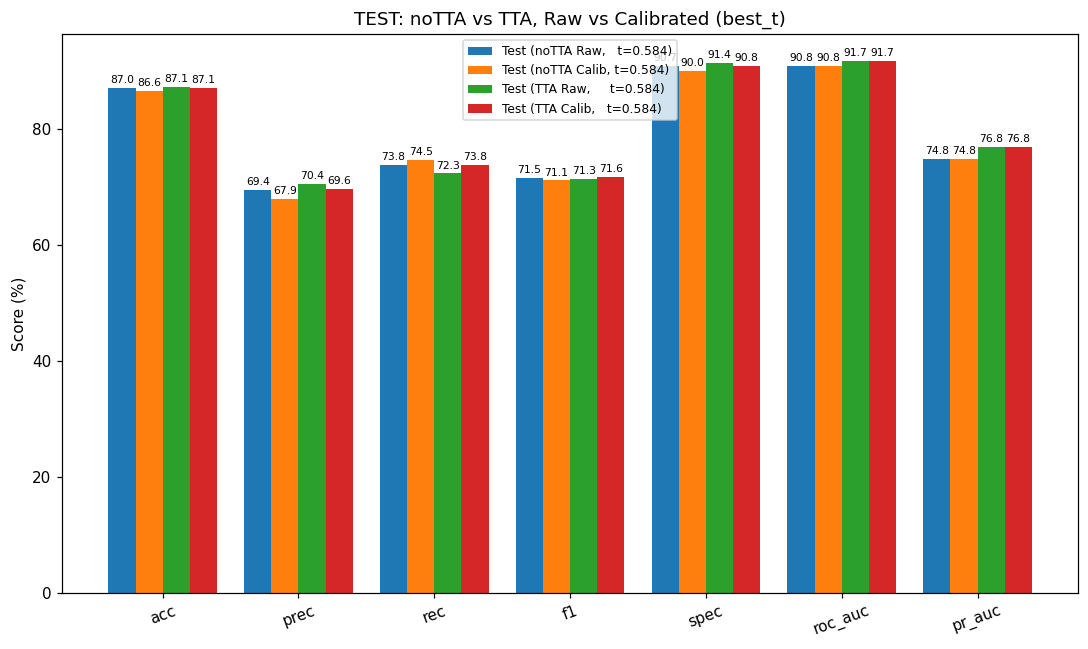

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def _metrics_from_probs(y_true, y_prob, thr):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).ravel()
    y_pred = (y_prob >= thr).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        spec = tn / (tn + fp + 1e-8)
    else:
        spec = float("nan")

    roc = roc_auc_score(y_true, y_prob)
    pr  = average_precision_score(y_true, y_prob)

    return {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "spec": spec,
        "roc_auc": roc,
        "pr_auc": pr,
    }

# ---- ① noTTA Raw @ best_t_notta ----
val_notta_raw  = _metrics_from_probs(yv_notta, sv_notta,        best_t_notta)
test_notta_raw = _metrics_from_probs(yt_notta, st_notta,        best_t_notta)

# ---- ② noTTA Calibrated @ best_t_notta_cal ----
val_notta_cal  = _metrics_from_probs(yv_cal_notta, sv_cal_notta, best_t_notta_cal)
test_notta_cal = _metrics_from_probs(yt_cal_notta, st_cal_notta, best_t_notta_cal)

# ---- ③ TTA Raw @ best_t_tta ----
val_tta_raw  = _metrics_from_probs(yv_tta, sv_tta,            best_t_tta)
test_tta_raw = _metrics_from_probs(yt_tta, st_tta,            best_t_tta)

val_tta_cal  = _metrics_from_probs(yv_tta, sv_val_tta_cal,    best_t_tta_cal)
test_tta_cal = _metrics_from_probs(yt_tta, st_test_tta_cal,   best_t_tta_cal)


def _pct_dict(m):
    return {k: round(v * 100, 3) for k, v in m.items()}

val_pct_notta_raw   = _pct_dict(val_notta_raw)
val_pct_notta_cal   = _pct_dict(val_notta_cal)
val_pct_tta_raw     = _pct_dict(val_tta_raw)
val_pct_tta_cal     = _pct_dict(val_tta_cal)

test_pct_notta_raw  = _pct_dict(test_notta_raw)
test_pct_notta_cal  = _pct_dict(test_notta_cal)
test_pct_tta_raw    = _pct_dict(test_tta_raw)
test_pct_tta_cal    = _pct_dict(test_tta_cal)

rows_val = [
    {"Split": f"Val (noTTA Raw,   t={best_t_notta:.3f})",      **val_pct_notta_raw},
    {"Split": f"Val (noTTA Calib, t={best_t_notta_cal:.3f})", **val_pct_notta_cal},
    {"Split": f"Val (TTA Raw,     t={best_t_tta:.3f})",       **val_pct_tta_raw},
    {"Split": f"Val (TTA Calib,   t={best_t_tta_cal:.3f})",   **val_pct_tta_cal},
]

metrics_df_val = pd.DataFrame(rows_val)
metric_cols_val = [c for c in metrics_df_val.columns if c != "Split"]
metrics_df_val = metrics_df_val[["Split"] + metric_cols_val]

print("[Debug] metrics_df_val columns:", list(metrics_df_val.columns))
print(metrics_df_val)

metrics_csv_path_val = os.path.join(OUT_DIR, "metrics_summary_val_notta_tta_raw_vs_calibrated_bestt.csv")
metrics_df_val.to_csv(metrics_csv_path_val, index=False)
print(f"[Info] Saved VAL metrics summary to: {metrics_csv_path_val}")

x = np.arange(len(metric_cols_val))
n_splits_val = len(metrics_df_val)
width = 0.8 / n_splits_val

plt.figure(figsize=(10, 6))
for i, split in enumerate(metrics_df_val["Split"]):
    values = metrics_df_val.loc[i, metric_cols_val].values.astype(float)
    offset = (i - (n_splits_val - 1) / 2) * width
    plt.bar(x + offset, values, width, label=split)
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=7)

xtick_labels_val = [c.replace("(%)", "").replace("%", "").strip()
                    for c in metric_cols_val]
plt.xticks(x, xtick_labels_val, rotation=20)
plt.ylabel("Score (%)")
plt.title("VAL: noTTA vs TTA, Raw vs Calibrated (best_t)")
plt.legend(fontsize=8)
plt.tight_layout()

bar_fig_path_val = os.path.join(OUT_DIR, "metrics_bar_val_notta_tta_raw_vs_calibrated_bestt.png")
plt.savefig(bar_fig_path_val, dpi=300)
plt.show()


rows_test = [
    {"Split": f"Test (noTTA Raw,   t={best_t_notta:.3f})",      **test_pct_notta_raw},
    {"Split": f"Test (noTTA Calib, t={best_t_notta_cal:.3f})", **test_pct_notta_cal},
    {"Split": f"Test (TTA Raw,     t={best_t_tta:.3f})",       **test_pct_tta_raw},
    {"Split": f"Test (TTA Calib,   t={best_t_tta_cal:.3f})",   **test_pct_tta_cal},
]

metrics_df_test = pd.DataFrame(rows_test)
metric_cols_test = [c for c in metrics_df_test.columns if c != "Split"]
metrics_df_test = metrics_df_test[["Split"] + metric_cols_test]

print("[Debug] metrics_df_test columns:", list(metrics_df_test.columns))
print(metrics_df_test)

metrics_csv_path_test = os.path.join(OUT_DIR, "metrics_summary_test_notta_tta_raw_vs_calibrated_bestt.csv")
metrics_df_test.to_csv(metrics_csv_path_test, index=False)
print(f"[Info] Saved TEST metrics summary to: {metrics_csv_path_test}")

x = np.arange(len(metric_cols_test))
n_splits_test = len(metrics_df_test)
width = 0.8 / n_splits_test

plt.figure(figsize=(10, 6))
for i, split in enumerate(metrics_df_test["Split"]):
    values = metrics_df_test.loc[i, metric_cols_test].values.astype(float)
    offset = (i - (n_splits_test - 1) / 2) * width
    plt.bar(x + offset, values, width, label=split)
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=7)

xtick_labels_test = [c.replace("(%)", "").replace("%", "").strip()
                     for c in metric_cols_test]
plt.xticks(x, xtick_labels_test, rotation=20)
plt.ylabel("Score (%)")
plt.title("TEST: noTTA vs TTA, Raw vs Calibrated (best_t)")
plt.legend(fontsize=8)
plt.tight_layout()

bar_fig_path_test = os.path.join(OUT_DIR, "metrics_bar_test_notta_tta_raw_vs_calibrated_bestt.png")
plt.savefig(bar_fig_path_test, dpi=300)
plt.show()


In [79]:
temp_path = os.path.join(OUT_DIR, "best_temperature.txt")
if os.path.exists(temp_path):
    with open(temp_path, "r") as f:
        T_opt = float(f.read().strip())
    print(f"[Calib] Loaded temperature T_opt = {T_opt:.4f} from {temp_path}")
else:
    T_opt = 1.0
    print("[Calib] best_temperature.txt not found, use T_opt = 1.0 (no scaling).")

thr_cal_path = os.path.join(OUT_DIR, "best_threshold_calibrated.txt")
if os.path.exists(thr_cal_path):
    with open(thr_cal_path, "r") as f:
        best_t_cal = float(f.read().strip())
    print(f"[Calib] Loaded best_t_cal = {best_t_cal:.4f} from {thr_cal_path}")
else:
    best_t_cal = 0.5
    print("[Calib] best_threshold_calibrated.txt not found, use best_t_cal = 0.5.")


[Calib] Loaded temperature T_opt = 0.9368 from ./Baseline+ECA(7000)_Output\best_temperature.txt
[Calib] best_threshold_calibrated.txt not found, use best_t_cal = 0.5.


## 20. Model explainability

### 20.1 Model explainability function

In [80]:
class GradCAM:

    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            # Save the activations of the target layer
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            # Save the gradients of the target layer
            self.gradients = grad_output[0].detach()

        self.hooks.append(
            self.target_layer.register_forward_hook(forward_hook)
        )

        if hasattr(self.target_layer, "register_full_backward_hook"):
            self.hooks.append(
                self.target_layer.register_full_backward_hook(backward_hook)
            )
        else:
            self.hooks.append(
                self.target_layer.register_backward_hook(backward_hook)
            )

    def remove_hooks(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []

    def __call__(self, x, class_idx=None):
        
        device = next(self.model.parameters()).device
        x = x.to(device)

        self.model.eval()
        self.model.zero_grad()

        # forward propagation
        out = self.model(x)
        if isinstance(out, tuple):
            cls_logits, _ = out       # (cls_logits, seg_logits)
        else:
            cls_logits = out

        if class_idx is None:
            scores = cls_logits
        else:
            scores = cls_logits[:, class_idx]

        loss = scores.sum()
        loss.backward()

        grads = self.gradients       # [B, C, H', W']
        activs = self.activations    # [B, C, H', W']

        weights = grads.mean(dim=(2, 3), keepdim=True)       # [B, C, 1, 1]
        cam = (weights * activs).sum(dim=1, keepdim=True)    # [B, 1, H', W']
        cam = F.relu(cam)

        cam = F.interpolate(
            cam,
            size=x.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        cam_min = cam.amin(dim=(2, 3), keepdim=True)
        cam_max = cam.amax(dim=(2, 3), keepdim=True)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)

        return cam

In [81]:
# Initialize GradCAM with the model and target layer
target_layer = model.eca4 
gradcam = GradCAM(model, target_layer)
print("[Info] GradCAM initialized on:", target_layer)

[Info] GradCAM initialized on: ECALayer(
  (avg_pool): AdaptiveAvgPool2d(output_size=1)
  (conv): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (sigmoid): Sigmoid()
)


### 20.2 CAM plot

In [82]:
def visualize_gradcam_example(
    img_tensor: torch.Tensor, 
    cam_tensor: torch.Tensor, 
    title: str = None,
    out_path: str = None,
):
    img_np = denormalize(img_tensor)               # [H,W], 0~1
    cam_np = cam_tensor.detach().cpu().numpy()     # [H,W], 0~1

    plt.figure(figsize=(10, 4))

    # 1) Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_np, cmap="gray")
    plt.axis("off")
    plt.title("Original X-ray", fontsize=10)

    # 2) Grad-CAM
    plt.subplot(1, 3, 2)
    plt.imshow(cam_np, cmap="jet")
    plt.axis("off")
    plt.title("Grad-CAM", fontsize=10)

    # 3) Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img_np, cmap="gray")
    plt.imshow(cam_np, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("Overlay", fontsize=10)

    if title is not None:
        plt.suptitle(title, fontsize=12)

    plt.tight_layout()
    if out_path is not None:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=300)
    plt.show()

### 20.3 Interpretability

In [83]:
def get_one_batch(loader):
    for xb, yb in loader:
        return xb, yb
    return None, None


def explain_with_gradcam_on_batch(
    model,
    gradcam,
    xb,         
    yb,          
    device,
    T_opt: float,
    best_t_cal: float,
    save_dir: str,
    prefix: str = "gradcam_explain",
    max_examples: int = 4,
):
    model.eval()
    xb = xb.to(device, non_blocking=True)
    yb = yb.to(device, non_blocking=True)

    # 1) Classification logits
    with torch.no_grad():
        out = model(xb)
        if isinstance(out, tuple):
            cls_logits, _ = out
        else:
            cls_logits = out

    # 2) Outputs before and after calibration
    logits_raw = cls_logits
    probs_raw  = torch.sigmoid(logits_raw)

    logits_cal = logits_raw / T_opt
    probs_cal  = torch.sigmoid(logits_cal)

    # 3) Grad-CAM
    cam = gradcam(xb)    # [B,1,H,W]

    os.makedirs(save_dir, exist_ok=True)

    B = xb.size(0)
    num_to_show = min(B, max_examples)

    for i in range(num_to_show):
        img_i  = xb[i]           # [1,H,W]
        cam_i  = cam[i, 0]       # [H,W]
        y_true = int(yb[i].cpu().item())

        p_raw = float(probs_raw[i].cpu().item())
        p_cal = float(probs_cal[i].cpu().item())

        y_pred_cal = int(p_cal >= best_t_cal)

        title = (
            f"y_true={y_true}, y_pred_cal={y_pred_cal}\n"
            f"p_raw={p_raw:.3f}, p_cal={p_cal:.3f} (T={T_opt:.3f}, t={best_t_cal:.3f})"
        )

        out_path = os.path.join(
            save_dir,
            f"{prefix}_idx{i}_y{y_true}_pred{y_pred_cal}.png"
        )

        visualize_gradcam_example(
            img_tensor=img_i,
            cam_tensor=cam_i,
            title=title,
            out_path=out_path,
        )

    print(f"[Info] Saved {num_to_show} Grad-CAM explainability examples to {save_dir}")

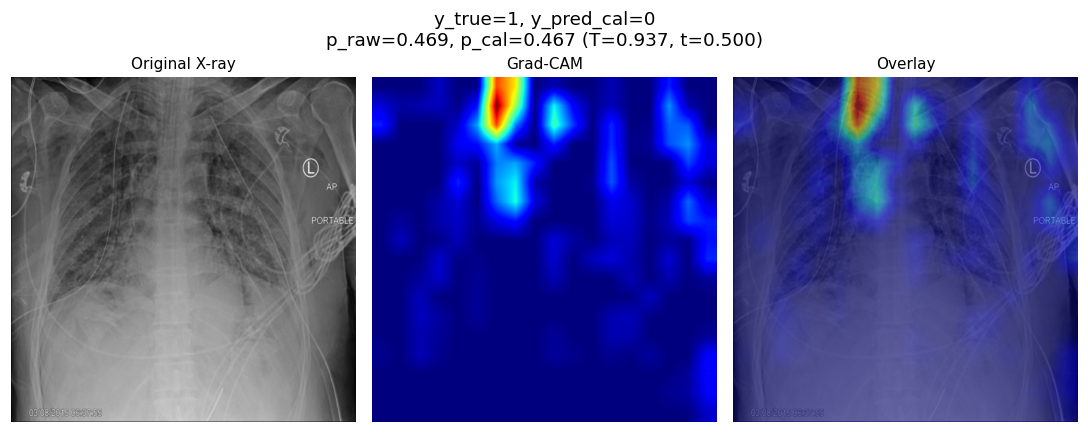

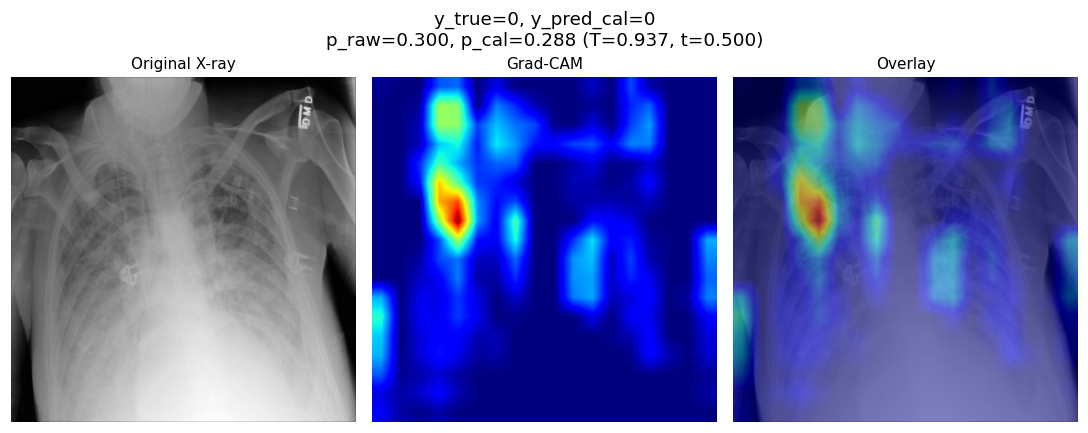

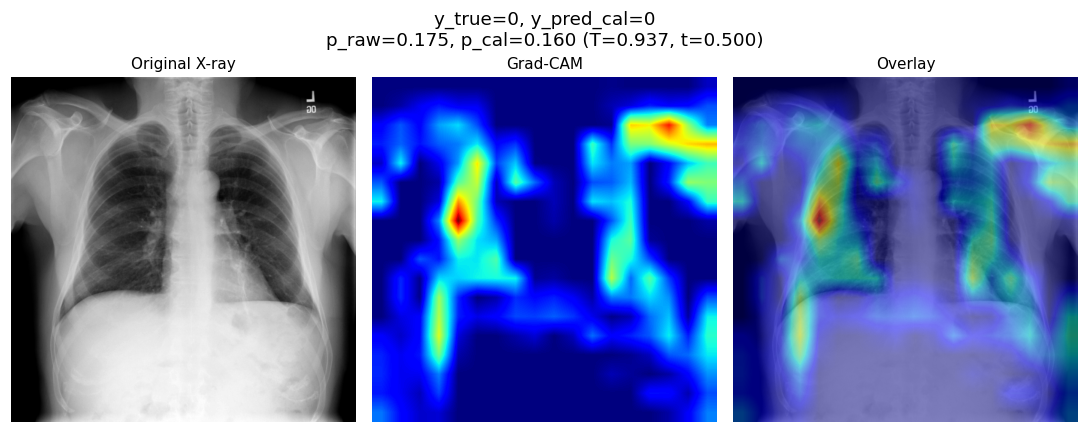

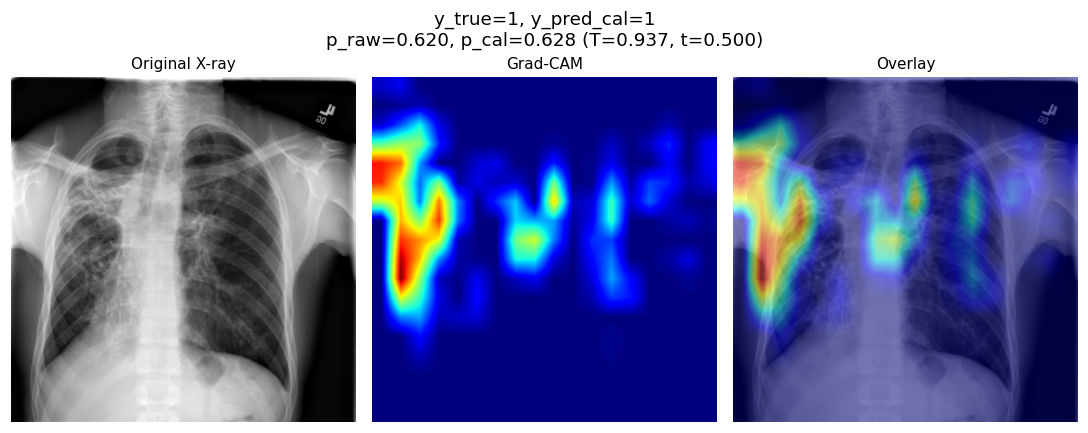

[Info] Saved 4 Grad-CAM explainability examples to ./Baseline+ECA(7000)_Output\explainability_val


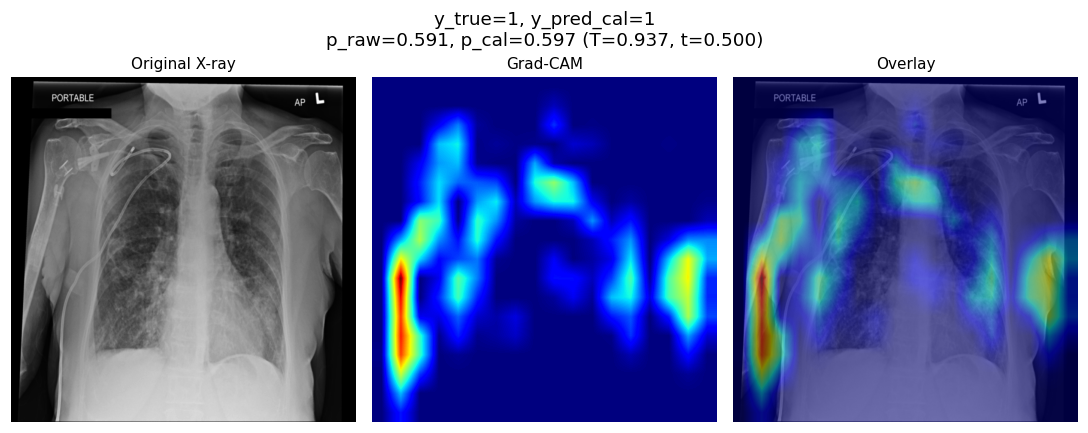

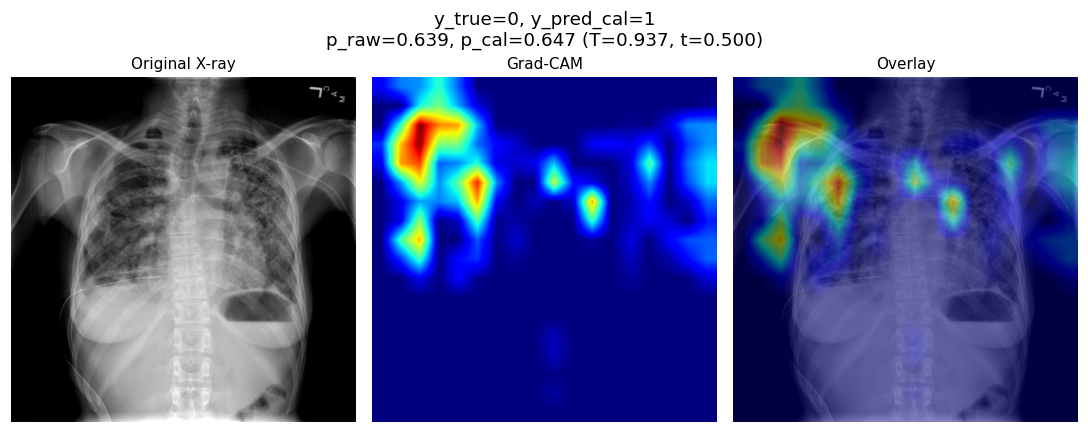

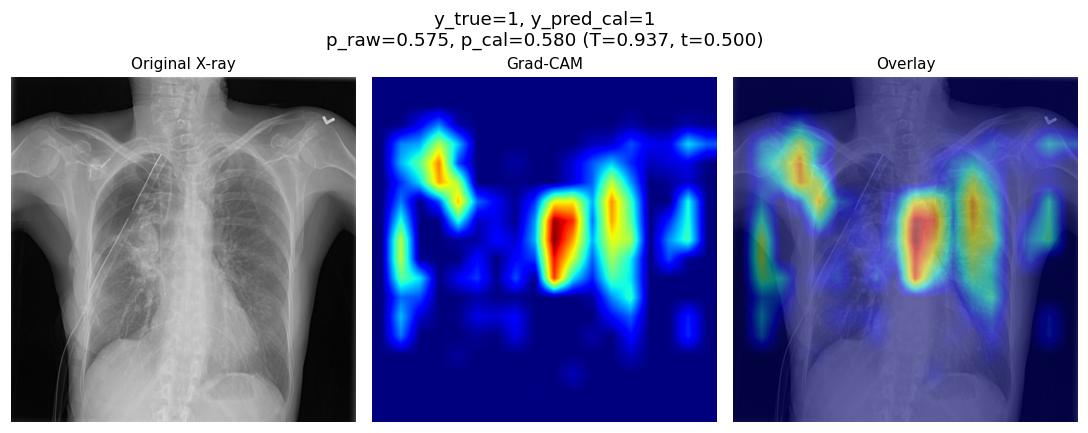

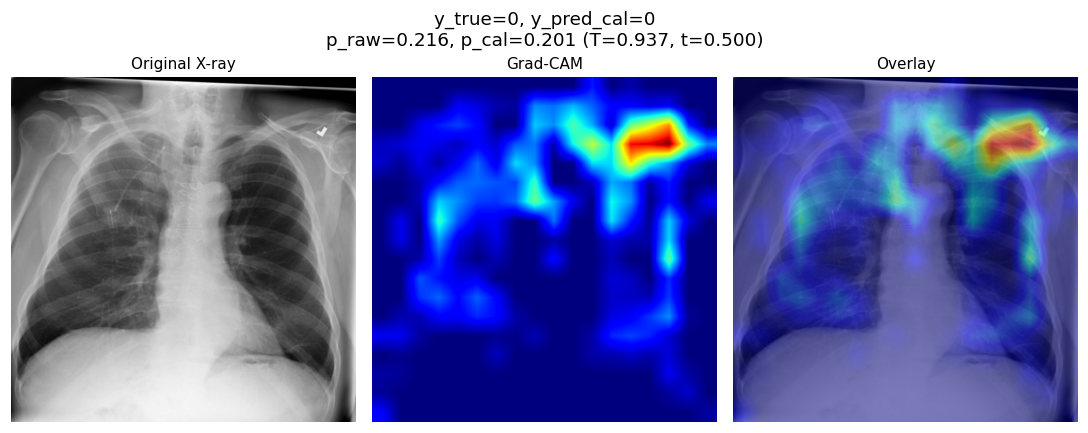

[Info] Saved 4 Grad-CAM explainability examples to ./Baseline+ECA(7000)_Output\explainability_test


In [84]:
xb_val, yb_val = get_one_batch(dl_val)
explain_with_gradcam_on_batch(
    model=model,
    gradcam=gradcam,
    xb=xb_val,
    yb=yb_val,
    device=device,
    T_opt=T_opt,
    best_t_cal=best_t_cal,
    save_dir=os.path.join(OUT_DIR, "explainability_val"),
    prefix="val_gradcam",
    max_examples=4,  
)

xb_test, yb_test = get_one_batch(dl_test)
explain_with_gradcam_on_batch(
    model=model,
    gradcam=gradcam,
    xb=xb_test,
    yb=yb_test,
    device=device,
    T_opt=T_opt,
    best_t_cal=best_t_cal,
    save_dir=os.path.join(OUT_DIR, "explainability_test"),
    prefix="test_gradcam",
    max_examples=4,
)